In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
#smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
num=5000
n_classes=12
n_epochs=500
#pzflow_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{pzflow_suffix}"

dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)

In [4]:
dataset_bank_tns_df_resampled_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21abmgtat                   0.121904   
ZTF18achdfqm                   0.470350   
ZTF21aagsihi                   1.877941   
ZTF19aapswkx                   0.186474   
ZTF20aclkhnm                   0.739245   
...                                 ...   
ZTFabc32249                    0.306052   
ZTFabc66465                    0.320692   
ZTFabc13108                    1.144730   
ZTFabc14043                    0.086057   
ZTFabc48563                    0.864527   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21abmgtat                                 0.230847   
ZTF18achdfqm                                 0.474306   
ZTF21aagsihi                                 1.139061   
ZTF19aapswkx                                 0.116516   
ZTF20aclkhnm                                 1.139875   
...                                               ...   
ZTFabc32249                                  0.832189   
ZTFabc66465                                 -0.050042   
ZTFabc13108                                  1.864203   
ZTFabc14043                                  0.127764   
ZTFabc48563                                  0.204443   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21abmgtat                      0.333333                     0.000000   
ZTF18achdfqm                      0.333333                     0.000000   
ZTF21aagsihi                      0.375000                     0.000000   
ZTF19aapswkx                      0.500000                     0.000000   
ZTF20aclkhnm                      0.166667                     0.083333   
...                                    ...                          ...   
ZTFabc32249                       0.405396                    -0.000035   
ZTFabc66465                       0.176314                    -0.000567   
ZTFabc13108                       0.313520                     0.000197   
ZTFabc14043                       0.512966                    -0.000260   
ZTFabc48563                       0.376493                    -0.000568   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21abmgtat               0.261333                                 0.243809   
ZTF18achdfqm               0.417916                                 0.940701   
ZTF21aagsihi               0.450437                                 3.729228   
ZTF19aapswkx               0.418552                                 0.372948   
ZTF20aclkhnm               0.395673                                 1.478491   
...                             ...                                      ...   
ZTFabc32249                0.395407                                 2.542010   
ZTFabc66465                0.360731                                 0.322312   
ZTFabc13108                0.400653                                 2.590977   
ZTFabc14043                0.419987                                 1.934345   
ZTFabc48563                0.420825                                 0.708473   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21abmgtat                                   0.230761   
ZTF18achdfqm                                   0.908838   
ZTF21aagsihi                                   3.119188   
ZTF19aapswkx                                   0.372948   
ZTF20aclkhnm                                   1.095229   
...                                                 ...   
ZTFabc32249                                    2.605509   
ZTFabc66465                                    0.288168   
ZTFabc13108                                    1.433474   
ZTFabc14043                                    

In [5]:
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

In [6]:
n_estimators=500 #3500
max_depth=15 #35
random_state=10
max_features=15 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10

In [7]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, max_features=max_features)
clf.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

CPU times: user 6min 36s, sys: 792 ms, total: 6min 37s
Wall time: 6min 38s


RandomForestClassifier(max_depth=15, max_features=15, n_estimators=500,
                       random_state=10)

In [8]:
pkl_path = f"../pickles/{pzflow_suffix}/"
if not os.path.exists(pkl_path):
    os.makedirs(pkl_path)
pickle.dump(clf, open(f'../pickles/{pzflow_suffix}/pzflow_RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}.pkl', 'wb'))

### Load pickle

In [9]:
with open(f'../pickles/{pzflow_suffix}/pzflow_RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}.pkl', 'rb') as f:
    clf = pickle.load(f)

In [10]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(dataset_bank_tns_df_resampled_test.iloc[:, 0:120])

In [11]:
clf.classes_

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [12]:
# Predicted Probability to be ['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
#                              'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE']
predicted_probability

array([[4.72281812e+01, 8.66893019e-01, 5.91748122e-01, ...,
        1.89880393e+00, 3.33080640e+00, 5.51521492e+00],
       [1.26347861e+01, 1.96078431e-03, 6.09199054e+00, ...,
        1.89845378e+01, 1.55750887e+00, 3.48300645e-01],
       [3.36586607e+01, 3.75963882e-01, 8.41756790e+00, ...,
        9.00468698e-01, 2.10162249e+00, 8.04477410e+00],
       ...,
       [2.69331158e+01, 1.22572649e-01, 8.09138269e-01, ...,
        3.71775261e+00, 3.70521495e+00, 2.98663619e+00],
       [2.81732077e+01, 6.78207214e+00, 5.22646092e+00, ...,
        2.43956652e+00, 5.72408165e+00, 5.83262318e+00],
       [2.04341045e+01, 2.17236819e+00, 3.61134570e+00, ...,
        2.32379513e+00, 8.87381076e+00, 4.28165479e+00]])

In [13]:
clf.classes_[1:]

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [14]:
predicted_probability.shape

(300, 12)

In [15]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(dataset_bank_tns_df_resampled_test.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
# clf.classes_[1:] and row.values[1:] ignores the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[1:][np.argmax(row.values[1:])], axis=1)
df

None    SLSN-II      SN II     SN IIP     SN IIb  \
ztf_object_id                                                          
ZTF21aazebgh   47.228181   0.866893   0.591748   1.049390   1.646532   
ZTF21acgxypn   12.634786   0.001961   6.091991  11.027786  22.856544   
ZTF19aapqqrb   33.658661   0.375964   8.417568  13.431092   1.483712   
ZTF21aasbxng    4.287385   0.110237   2.983886   2.969528   4.939651   
ZTF21aaglgcb   27.838591  34.100164   2.218761   0.020266   0.372690   
...                  ...        ...        ...        ...        ...   
ZTF21acbntop   14.030677   0.239605   2.665919   2.121636   9.474961   
ZTF21acjgmiy   52.463392   0.050079  10.274621  17.057664   0.905027   
ZTF22aaagxev   26.933116   0.122573   0.809138   5.629440   2.483741   
ZTF21abtdvpg   28.173208   6.782072   5.226461   2.389333   4.279927   
ZTF20acjfimy   20.434105   2.172368   3.611346   1.955390   3.999333   

                  SN IIn      SN Ia  SN Ia-91T-like      SN Ib      SN Ic  \
ztf_object_id                                                               
ZTF21aazebgh    1.980979  24.174253        6.108048   5.609151   1.898804   
ZTF21acgxypn    5.035794   9.494931        1.355284  10.610576  18.984538   
ZTF19aapqqrb    1.128846  19.913108        4.822232   5.721953   0.900469   
ZTF21aasbxng    4.503203  34.897491       18.213732   4.781248   8.929559   
ZTF21aaglgcb    3.886258  21.004808        5.104118   0.550938   0.655683   
...                  ...        ...             ...        ...        ...   
ZTF21acbntop    5.749546  27.814270        7.645468   9.238084  12.626131   
ZTF21acjgmiy    0.257755  11.827390        0.787717   4.838907   0.204602   
ZTF22aaagxev    1.336193  23.464768        9.722071  19.089356   3.717753   
ZTF21abtdvpg   21.765850  10.764187        6.042565   0.580127   2.439567   
ZTF20acjfimy    9.833075  27.326421       11.680459   3.508243   2.323795   

                SN Ic-BL       TDE RFC_best_cls  
ztf_object_id                                    
ZTF21aazebgh    3.330806  5.515215        SN Ia  
ZTF21acgxypn    1.557509  0.348301       SN IIb  
ZTF19aapqqrb    2.101622  8.044774        SN Ia  
ZTF21aasbxng   10.607921  2.776160        SN Ia  
ZTF21aaglgcb    1.780656  2.467066      SLSN-II  
...                  ...       ...          ...  
ZTF21acbntop    4.305917  4.087786        SN Ia  
ZTF21acjgmiy    0.682375  0.650471       SN IIP  
ZTF22aaagxev    3.705215  2.986636        SN Ia  
ZTF21abtdvpg    5.724082  5.832623       SN IIn  
ZTF20acjfimy    8.873811  4.281655        SN Ia  

[300 rows x 13 columns]

In [16]:
df2 = pd.concat([dataset_bank_tns_df_resampled_test, df], axis=1)
df2

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

In [17]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(20, 14)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

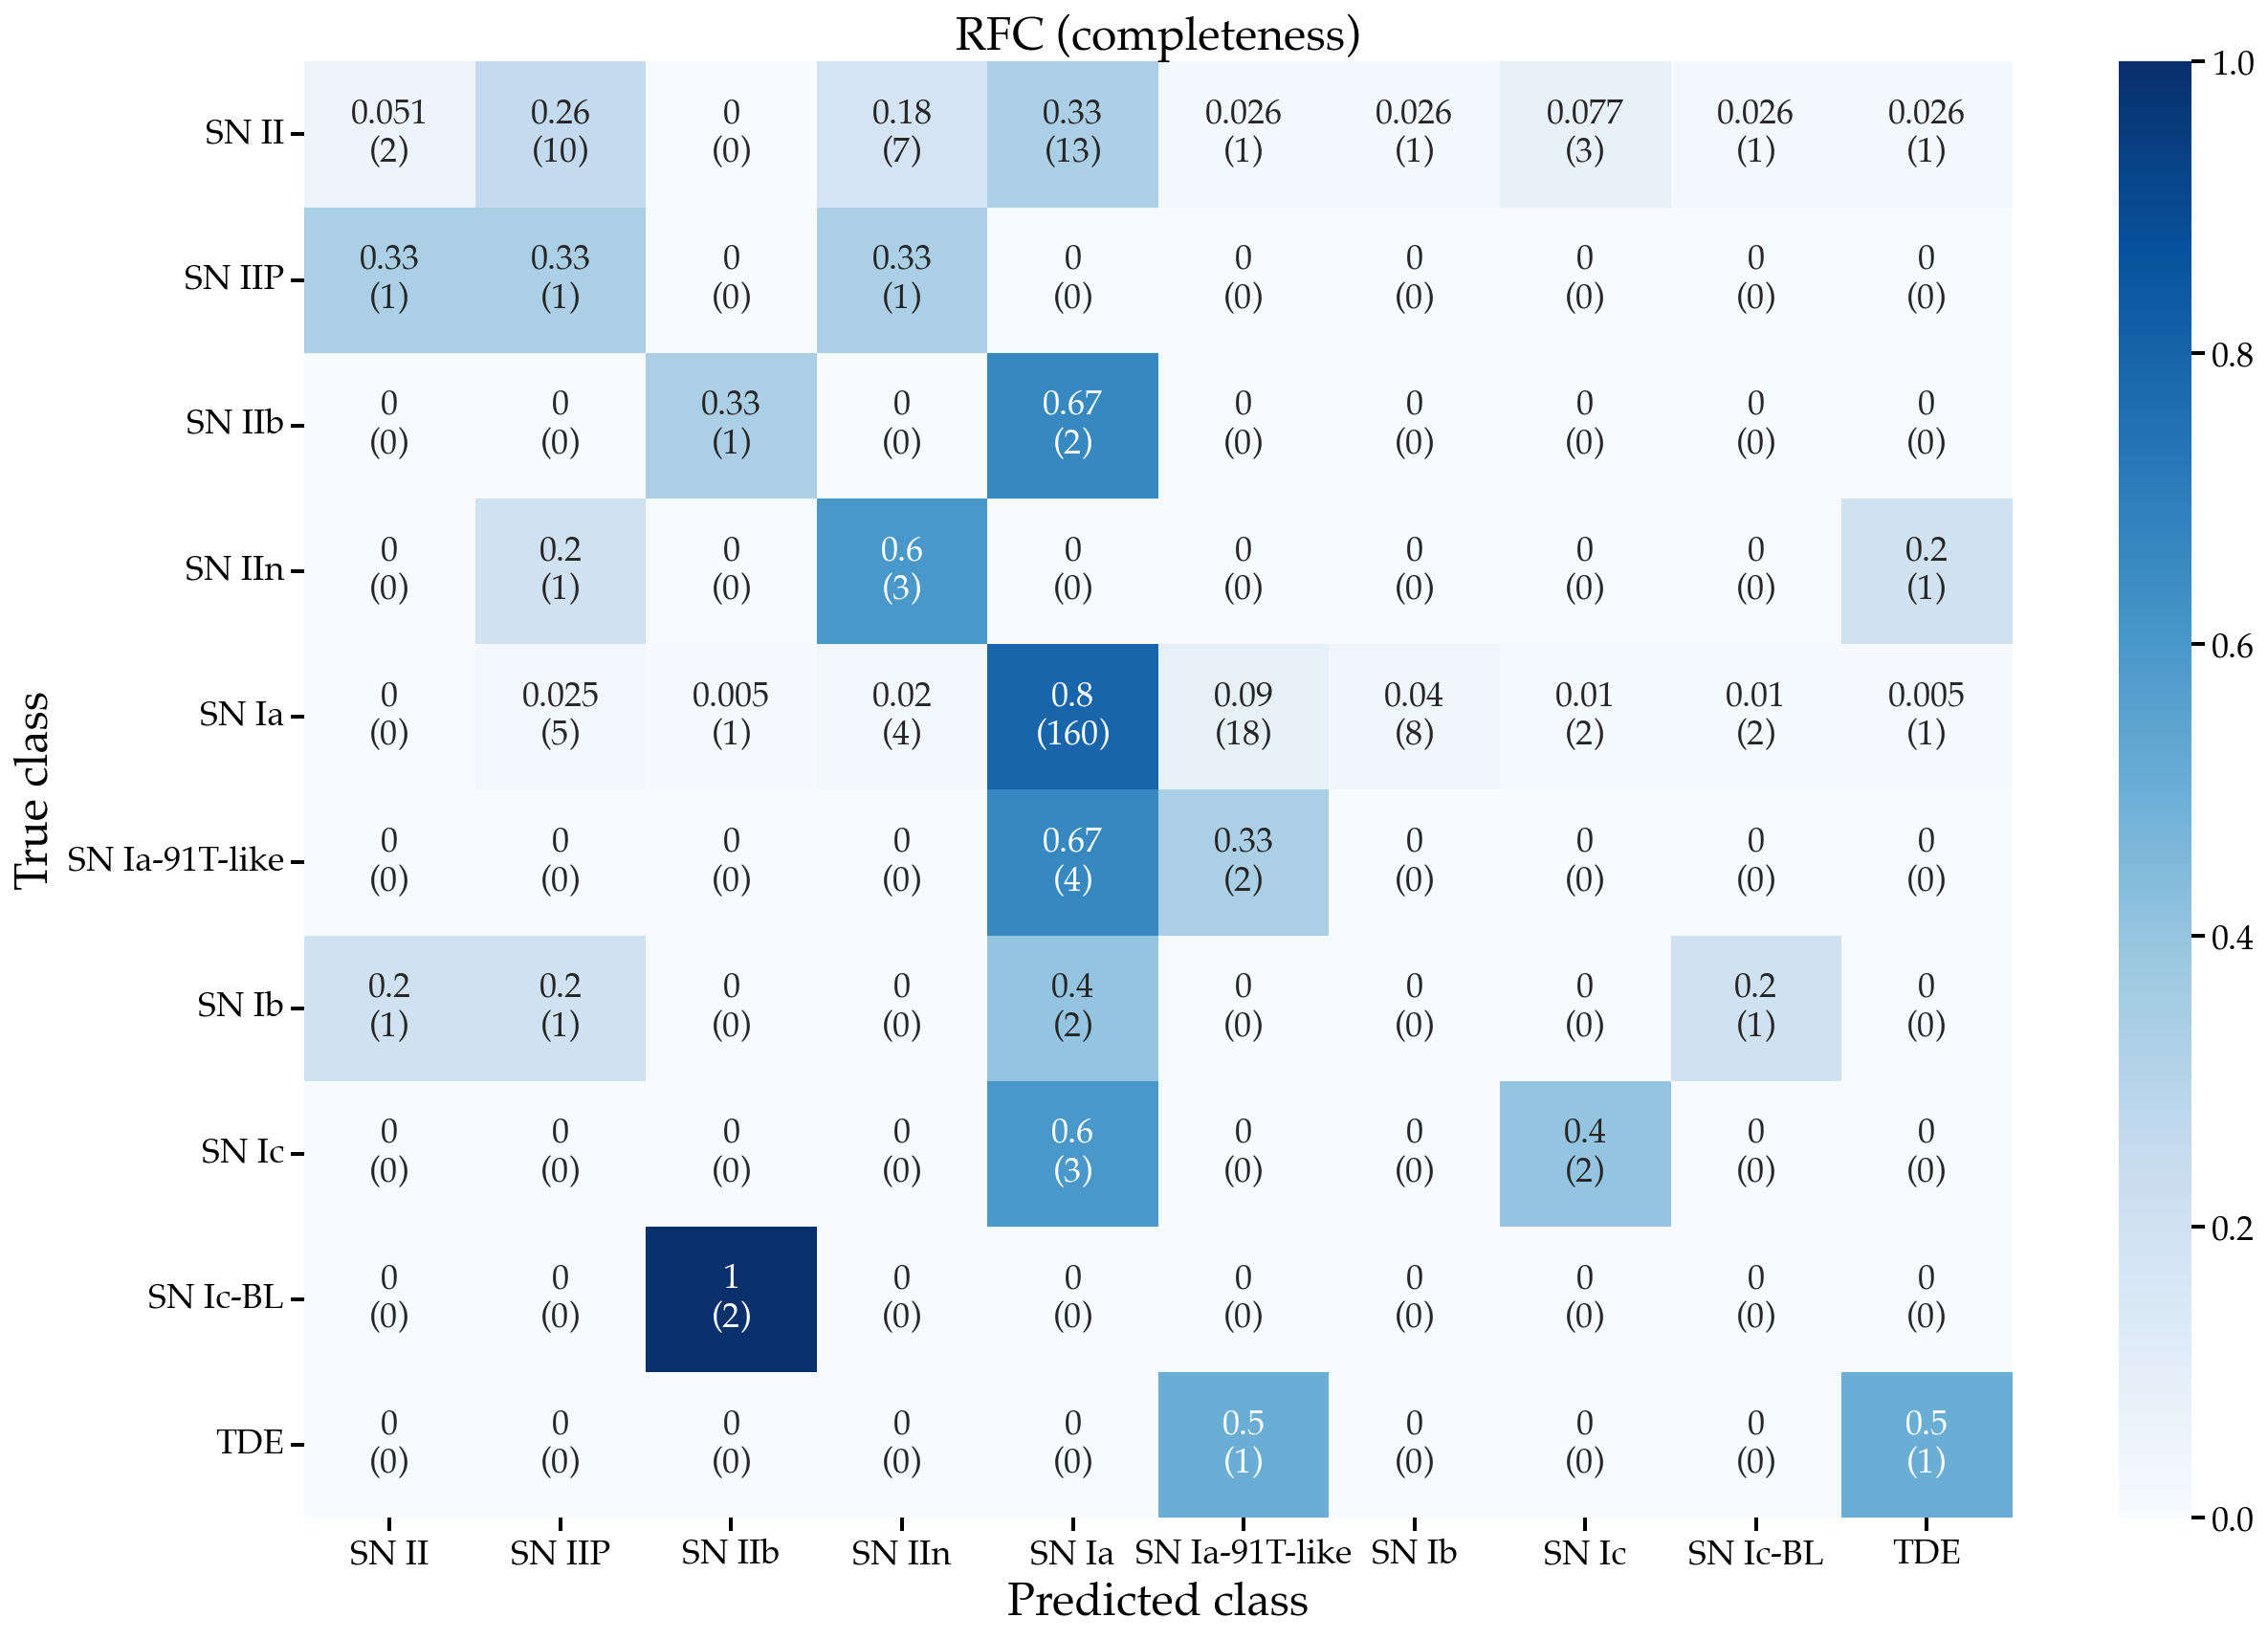

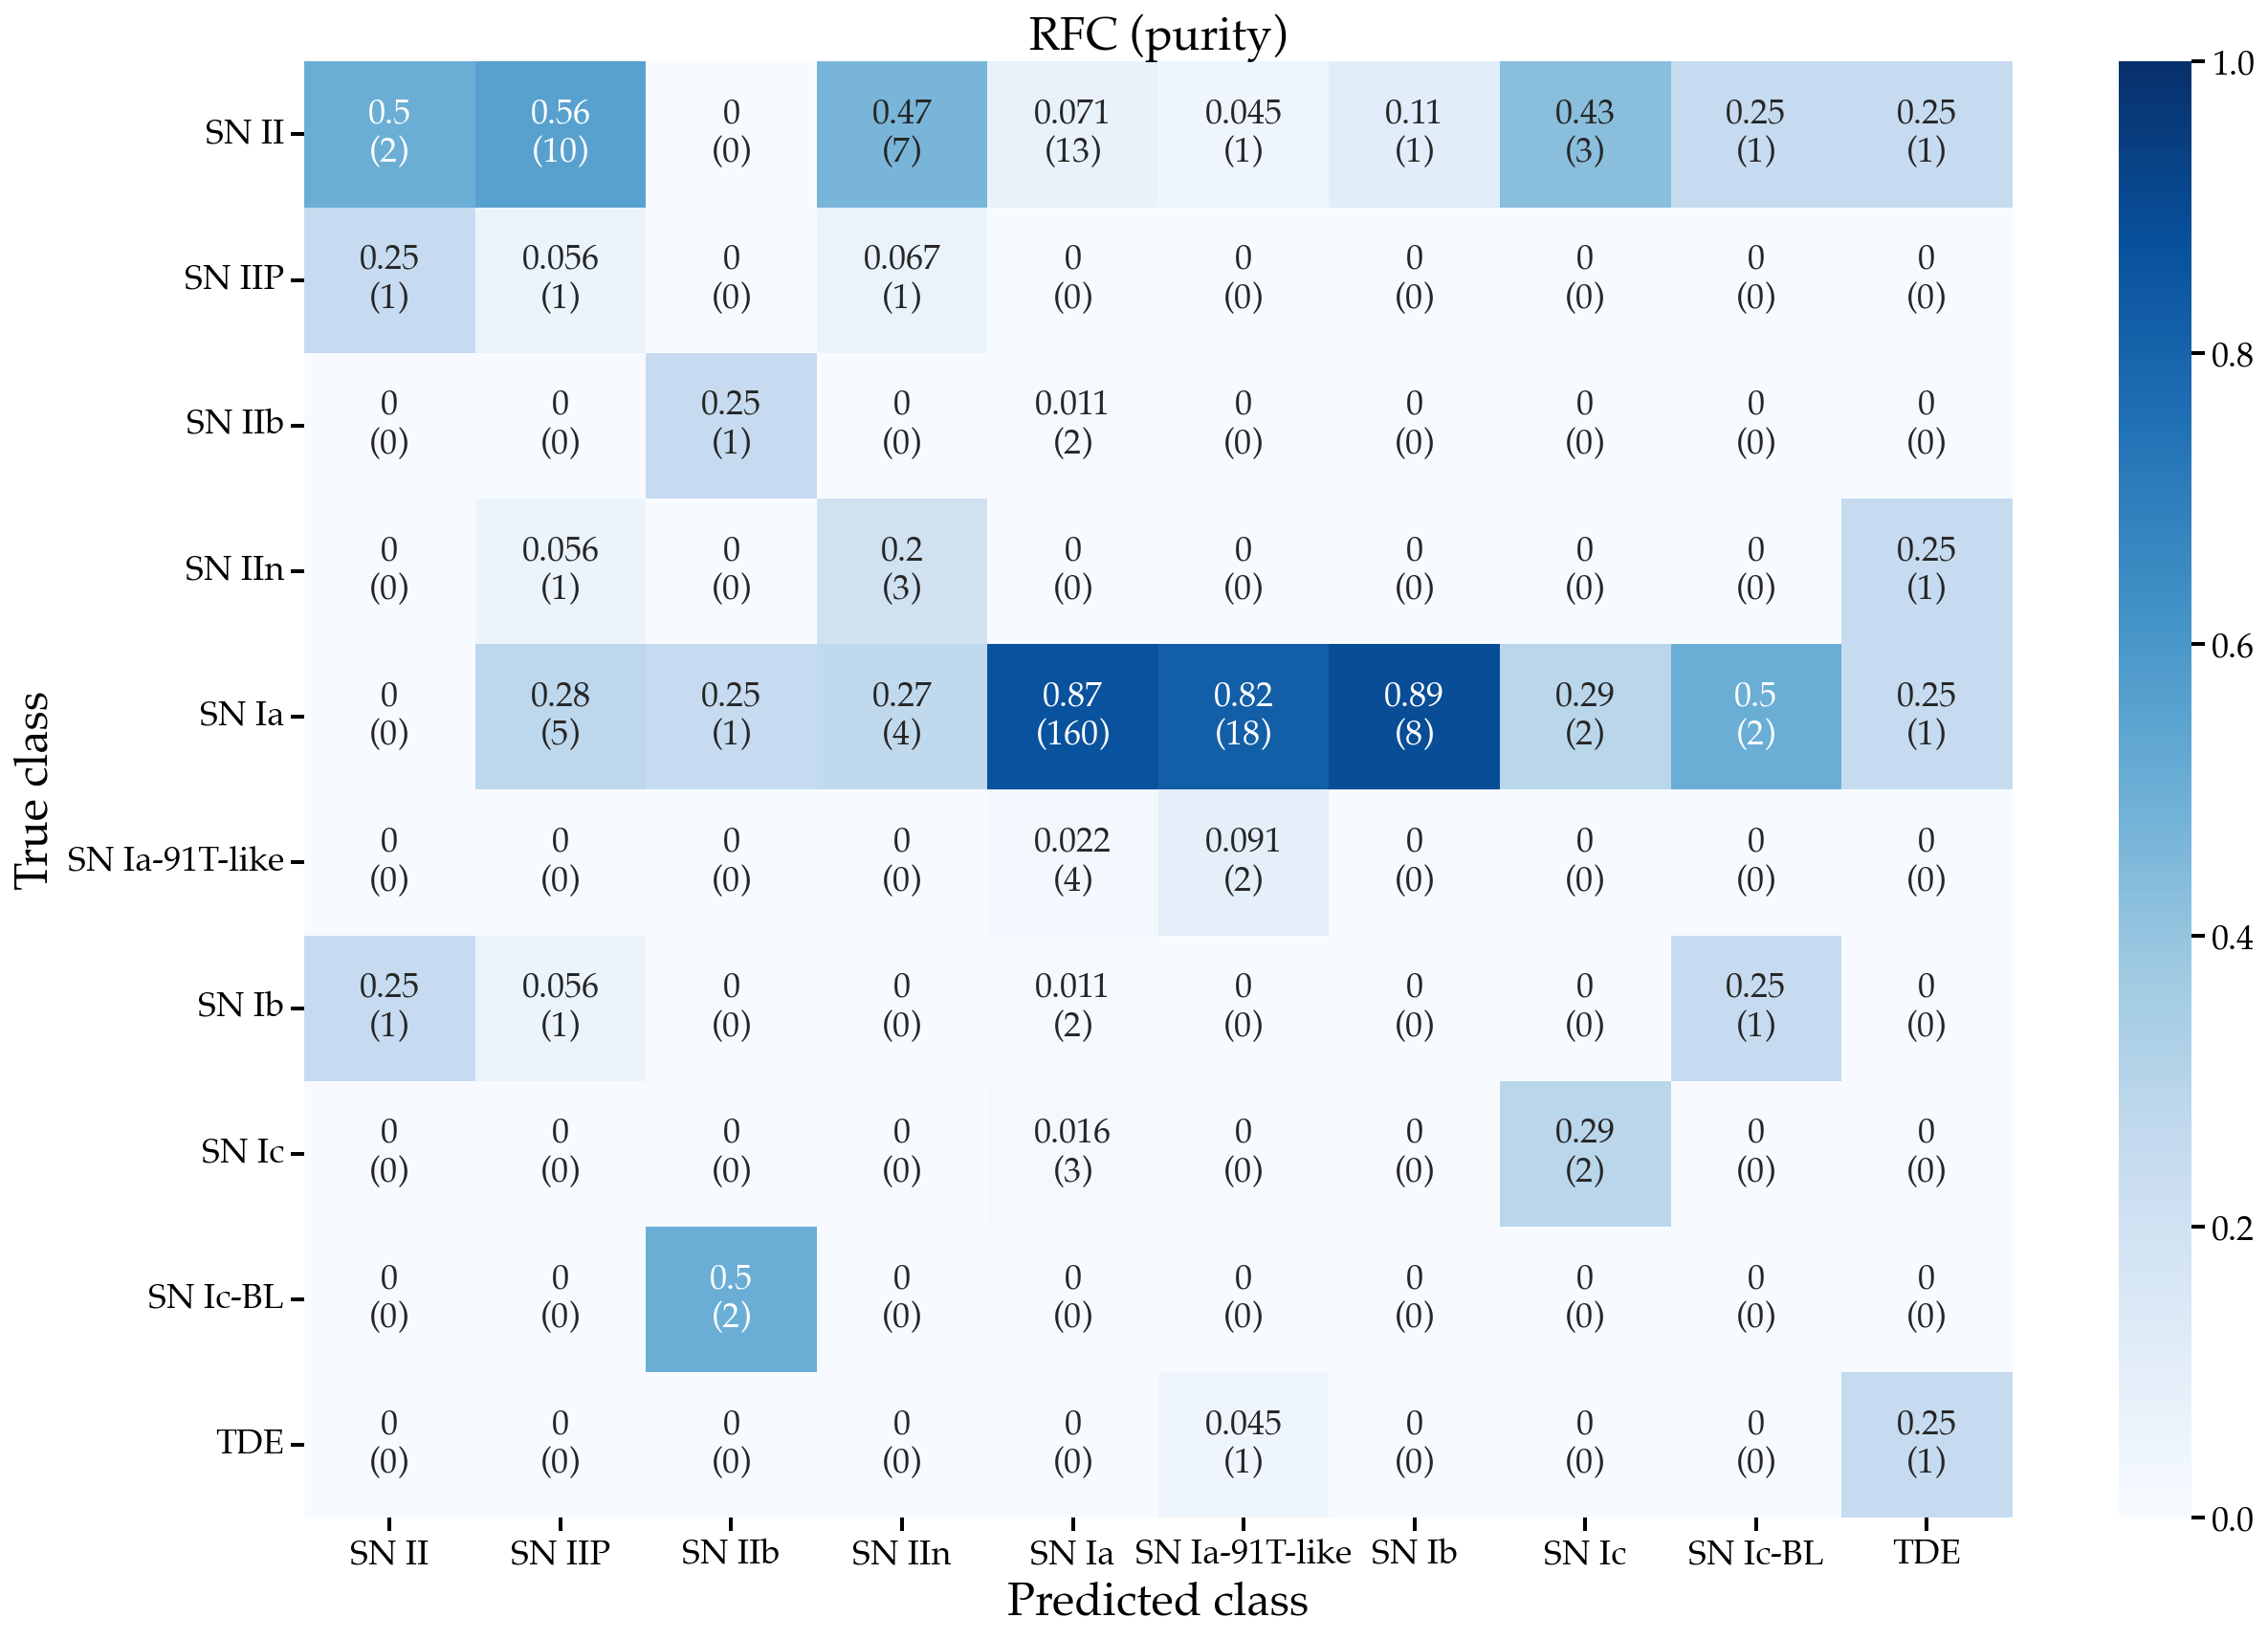

In [18]:
# Confusion matrices
title='RFC'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

folder_path = f"../figures/confusion_matrix/{suffix}/n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}__max_features={max_features}/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [19]:
sim_class_di = {'CV': 'CV', 
      'SLSN-I': 'SLSN', 
      'SLSN-II': 'SLSN', 
      'SN II': 'SN II', 
      'SN IIP': 'SN II', 
      'SN IIb': 'SN II', 
      'SN IIn': 'SN II',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN Ibc', 
      'SN Ib/c': 'SN Ibc',
      'SN Ibn': 'SN Ibc', 
      'SN Ic': 'SN Ibc',
      'SN Ic-BL': 'SN Ibc', 
      'TDE': 'TDE',
      'None': 'None',
      'SN': 'SN',
      'SN I': 'SN I',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_sim_class = df2.copy()
ann0_ann1_df_noNone_sim_class['tns_cls'] = ann0_ann1_df_noNone_sim_class['tns_cls'].map(sim_class_di)
ann0_ann1_df_noNone_sim_class['RFC_best_cls'] = ann0_ann1_df_noNone_sim_class['RFC_best_cls'].map(sim_class_di)
#ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'].map(sim_class_di)

In [20]:
ann0_ann1_df_noNone_sim_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

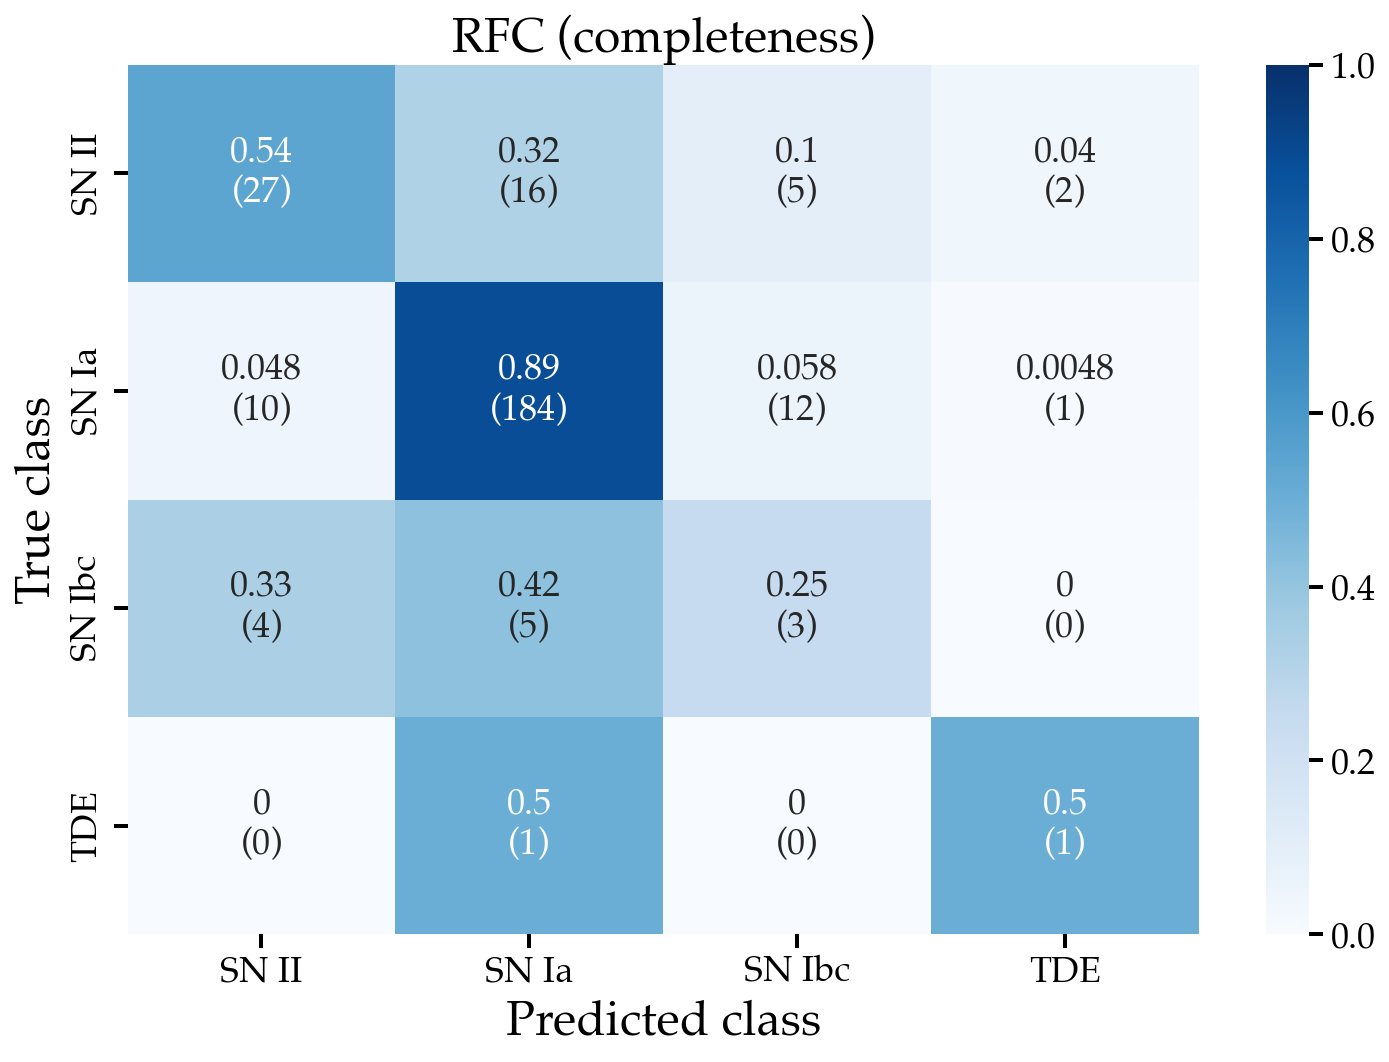

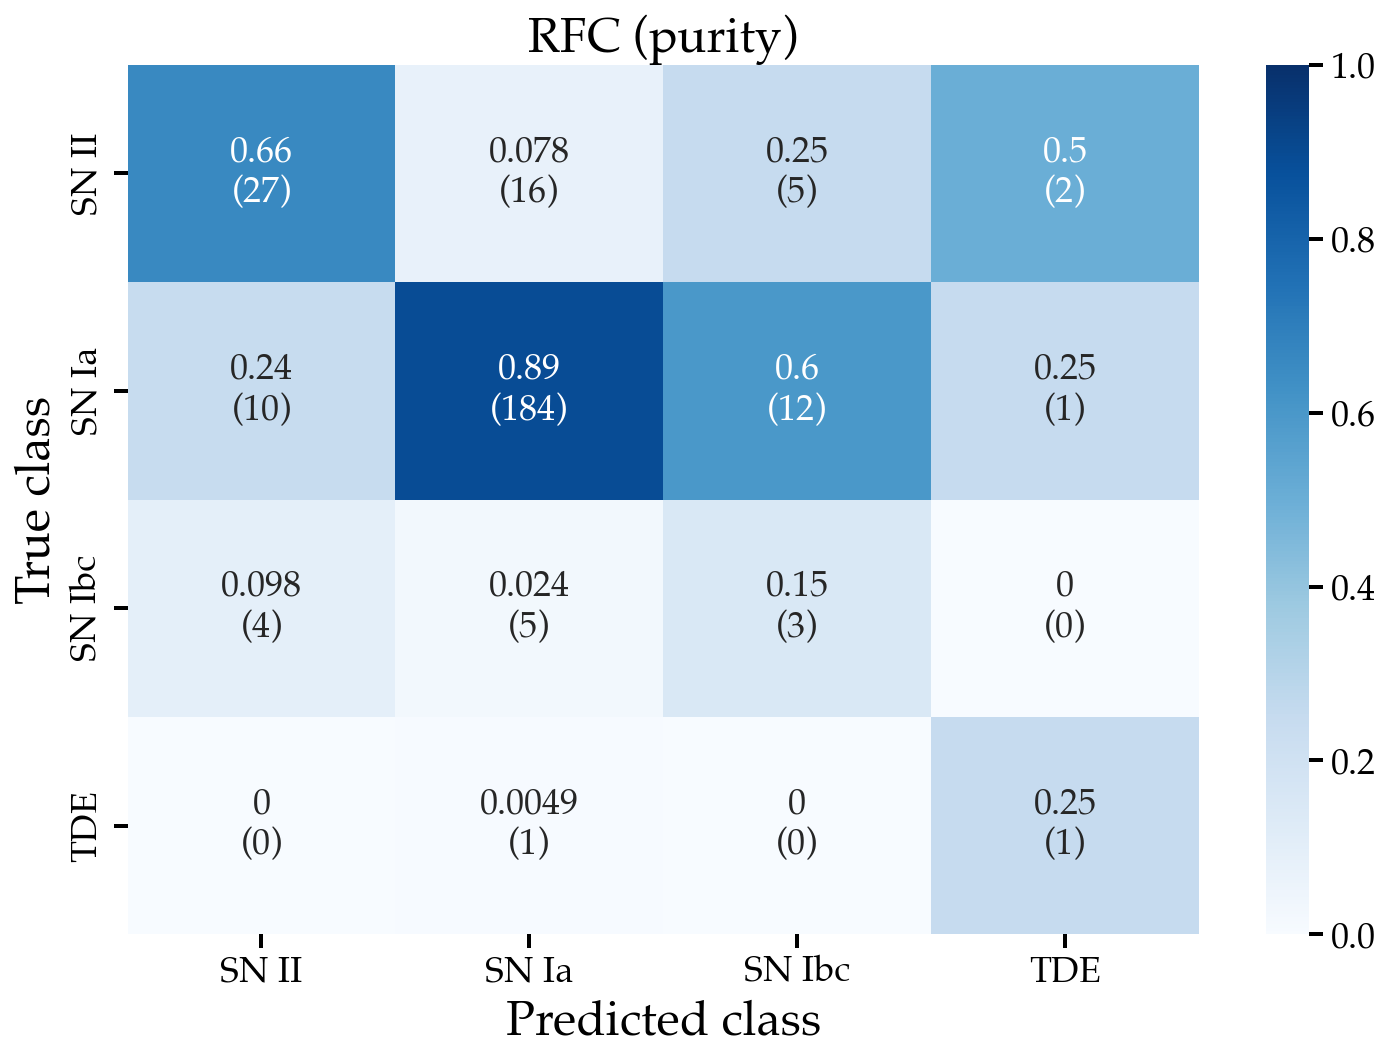

In [21]:
# Confusion matrices
df = ann0_ann1_df_noNone_sim_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(12, 8))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_similar_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [22]:
### CC vs Ia vs Exotic (TDE, SLSN)

bin_class_di = {'CV': 'CV', 
      'SLSN-I': 'Exotic', 
      'SLSN-II': 'Exotic', 
      'SN II': 'SN CC', 
      'SN IIP': 'SN CC', 
      'SN IIb': 'SN CC', 
      'SN IIn': 'SN CC',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN CC', 
      'SN Ib/c': 'SN CC',
      'SN Ibn': 'SN CC', 
      'SN Ic': 'SN CC',
      'SN Ic-BL': 'SN CC', 
      'TDE': 'Exotic',
      'None': 'None',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_bin_class = df2.copy()
ann0_ann1_df_noNone_bin_class['tns_cls'] = ann0_ann1_df_noNone_bin_class['tns_cls'].map(bin_class_di)
ann0_ann1_df_noNone_bin_class['RFC_best_cls'] = ann0_ann1_df_noNone_bin_class['RFC_best_cls'].map(bin_class_di)
#ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'].map(bin_class_di)

In [23]:
mask = (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'AGN') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'CV') & (ann0_ann1_df_noNone_bin_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone_bin_class[mask]
ann0_ann1_df_noNone_bin_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

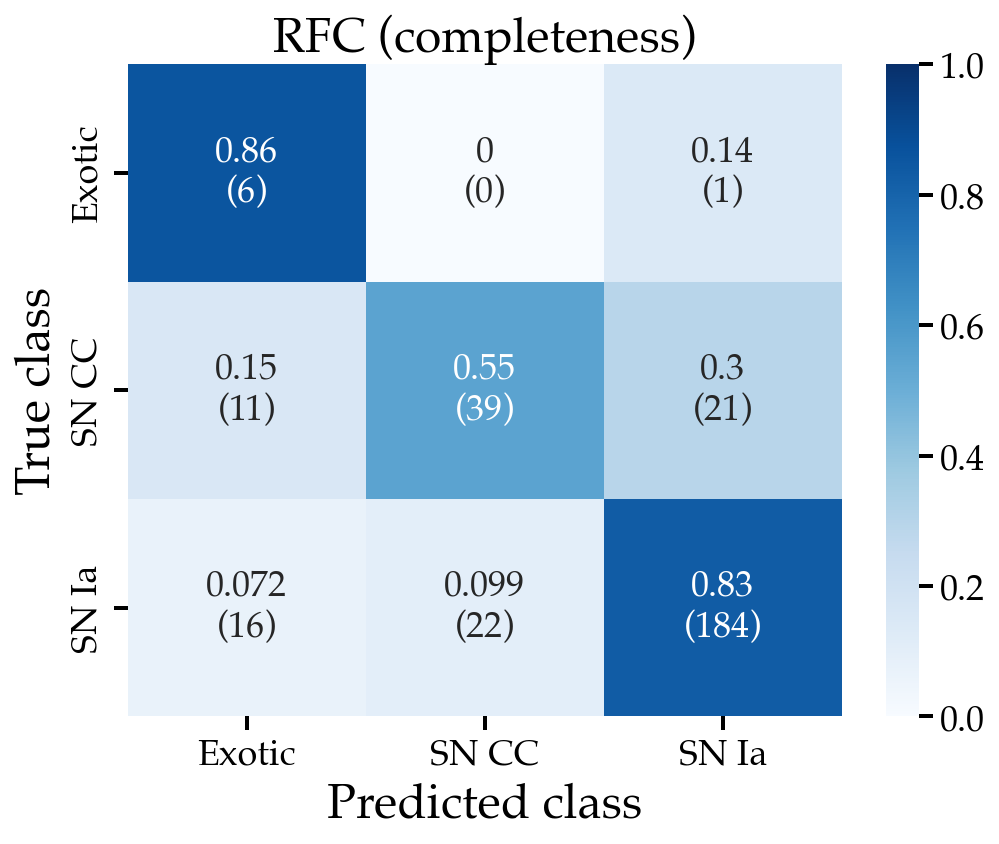

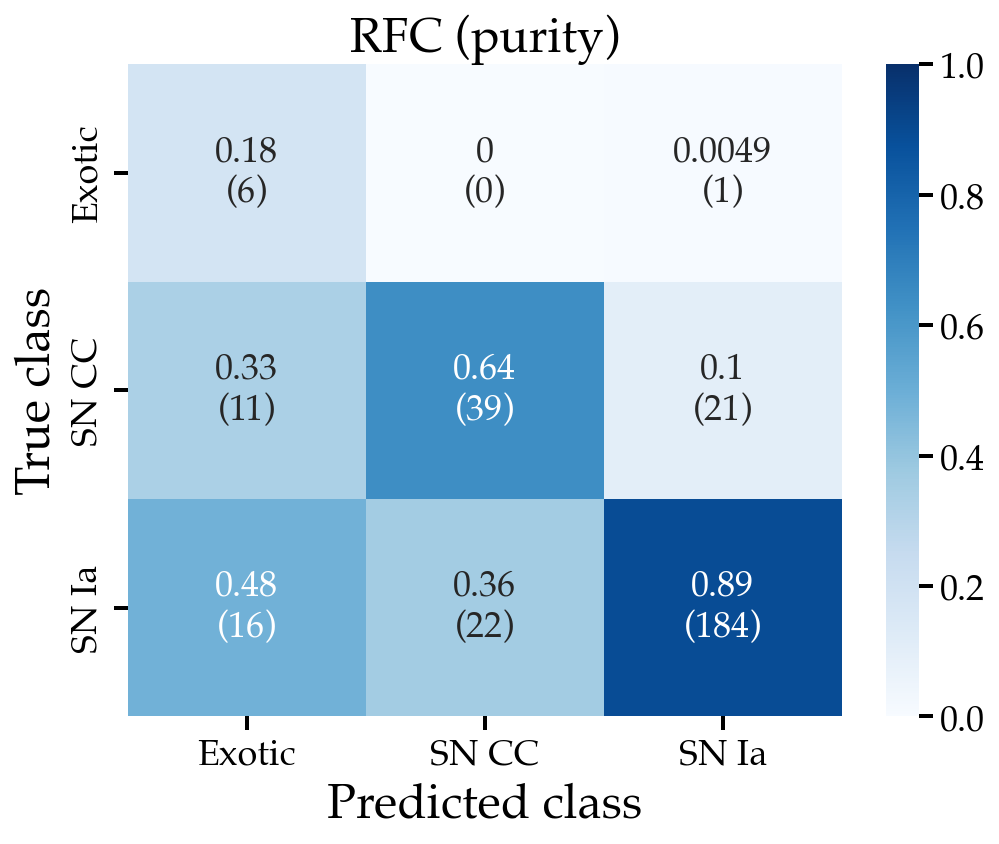

In [24]:
# Confusion matrices
df = ann0_ann1_df_noNone_bin_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(8, 6))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_binary_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here are Ia and rare Ia subtypes. Results w/o redshift too! And only 2 pbs

In [25]:
rare_v_not_class_di = {'CV': 'Not SN', 
      'SLSN-I': 'Rare', 
      'SLSN-II': 'Rare', 
      'SN II': 'Rare', 
      'SN IIP': 'Rare', 
      'SN IIb': 'Rare', 
      'SN IIn': 'Rare',
      'SN Ia': 'NOT Rare', 
      'SN Ia-91T-like': 'Rare', 
      'SN Ia-CSM': 'Rare',
      'SN Ia-91bg-like': 'Rare',
      'SN Ia-pec': 'Rare', 
      'SN Ib': 'Rare', 
      'SN Ib/c': 'Rare',
      'SN Ibn': 'Rare',
      'SN Ic': 'Rare',
      'SN Ic-BL': 'Rare', 
      'TDE': 'Rare',
      'None': 'NOT Rare',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'Not SN'}


ann0_ann1_df_noNone_rare_v_not_class = df2.copy()
ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['tns_cls'].map(rare_v_not_class_di)
ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'] = ann0_ann1_df_noNone_rare_v_not_class['RFC_best_cls'].map(rare_v_not_class_di)
#ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'].map(rare_v_not_class_di)

In [26]:
mask = (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Not SN') & (ann0_ann1_df_noNone_rare_v_not_class['tns_cls'] != 'Other')
ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone_rare_v_not_class[mask]
ann0_ann1_df_noNone_rare_v_not_class

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acbntop                   0.899363   
ZTF21acjgmiy                   0.195485   
ZTF22aaagxev                   0.393591   
ZTF21abtdvpg                   0.660813   
ZTF20acjfimy                   0.759288   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acbntop                                 0.548262   
ZTF21acjgmiy                                 0.345411   
ZTF22aaagxev                                 0.331851   
ZTF21abtdvpg                                 1.068944   
ZTF20acjfimy                                 0.419054   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acbntop                      0.142857                     0.000000   
ZTF21acjgmiy                      0.428571                     0.000000   
ZTF22aaagxev                      0.200000                     0.000000   
ZTF21abtdvpg                      0.157895                     0.105263   
ZTF20acjfimy                      0.285714                     0.071429   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acbntop               0.384089                                 1.798725   
ZTF21acjgmiy               0.381873                                 0.390970   
ZTF22aaagxev               0.363693                                 0.787182   
ZTF21abtdvpg               0.356518                                 1.321627   
ZTF20acjfimy               0.393095                                 1.518576   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acbntop                                   1.640747   
ZTF21acjgmiy                                   0.369406   
ZTF22aaagxev                                   0.787182   
ZTF21abtdvpg                                   

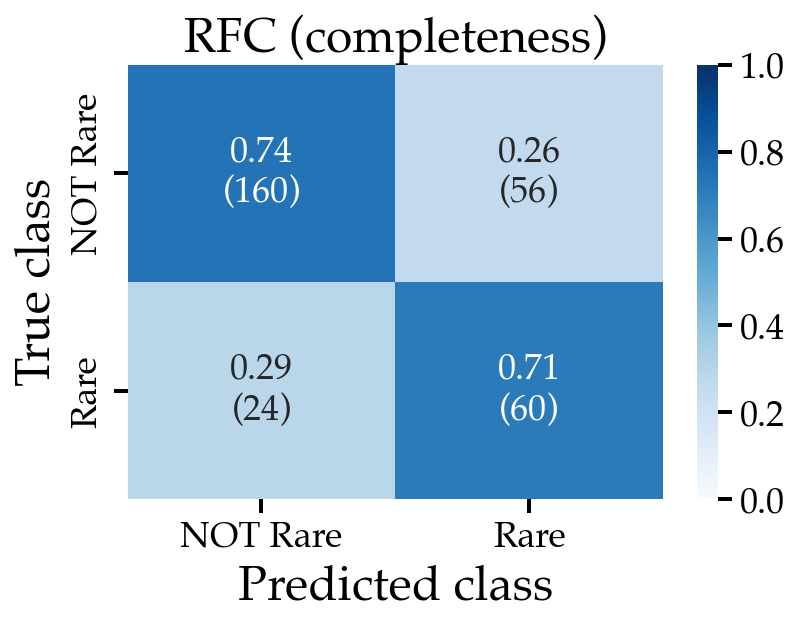

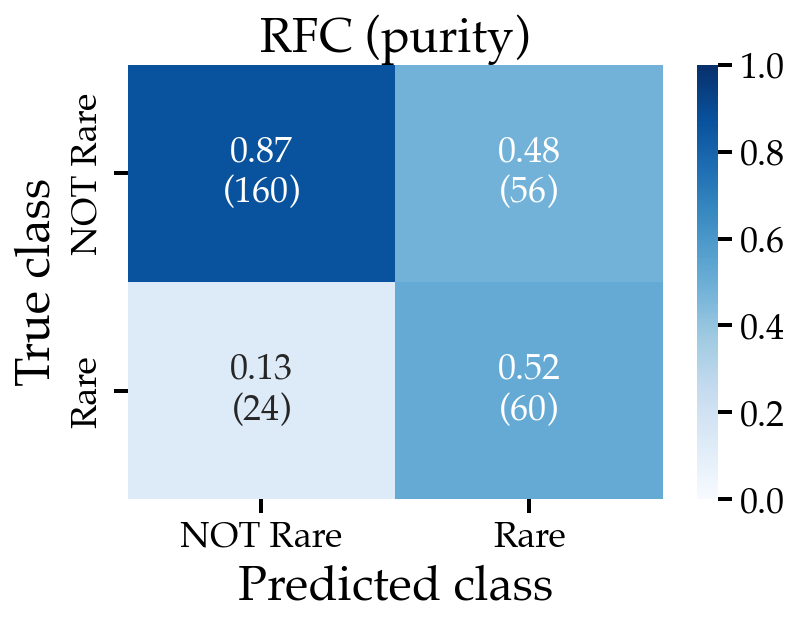

In [27]:
# Confusion matrices
df = ann0_ann1_df_noNone_rare_v_not_class
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(6, 4))
    plt.savefig(f'{folder_path}/confmatrix_nclasses={nclasses}_noNone_rare_v_not_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Remember, the Ia here is Ia-norm ONLY. The rare Ia subtypes are in the "Rare" classification. Results w/o redshift too! And only 2 pbs

In [28]:
%%time 
# In summary, you train your Random Forest Classifier to classify your data, 
# and then use the Isolation Forest algorithm on the output probabilities of the Random Forest Classifier 
# to detect anomalies.

from sklearn.ensemble import IsolationForest

anomaly_scores = IsolationForest(n_estimators=500, random_state=10).fit(predicted_probability).decision_function(predicted_probability)

CPU times: user 782 ms, sys: 37.1 ms, total: 820 ms
Wall time: 678 ms


In [29]:
most_anomalous_indices = np.argsort(anomaly_scores)[:25]
most_anomalous_samples = df2.iloc[most_anomalous_indices]
most_anomalous_samples

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF22aaaepao                   0.121577   
ZTF21abidxwo                   0.296384   
ZTF21aaagypx                   0.588448   
ZTF21abccaue                   0.259191   
ZTF20accmtgt                   1.348523   
ZTF21aavrvuj                   0.242250   
ZTF20acfkyll                   0.446079   
ZTF21aabygea                   1.121072   
ZTF21abcdtoi                   1.375365   
ZTF21aaizyqc                   1.022863   
ZTF21aaigdly                   0.367897   
ZTF21aapkhsc                   1.413270   
ZTF20achmmex                   0.469156   
ZTF21aalxurx                   0.784800   
ZTF21acgxypn                   0.541942   
ZTF21achfddh                   0.214568   
ZTF20abwxywy                   1.634157   
ZTF20acngnrs                   0.800957   
ZTF20acwfftd                   0.940681   
ZTF21abcixor                   0.340009   
ZTF21abicckd                   0.737504   
ZTF21aagmoqw                   0.622931   
ZTF21abfxjkq                   1.175756   
ZTF21abcmtev                   0.453838   
ZTF21aagyxgr                   0.586423   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF22aaaepao                                 0.670996   
ZTF21abidxwo                                 0.248318   
ZTF21aaagypx                                 1.259935   
ZTF21abccaue                                 1.356116   
ZTF20accmtgt                                 0.240779   
ZTF21aavrvuj                                 0.419557   
ZTF20acfkyll                                 0.839118   
ZTF21aabygea                                 4.941580   
ZTF21abcdtoi                                 0.455160   
ZTF21aaizyqc                                 2.109273   
ZTF21aaigdly                                 0.558708   
ZTF21aapkhsc                                 0.743122   
ZTF20achmmex                                 0.207091   
ZTF21aalxurx                                 3.179191   
ZTF21acgxypn                                 0.743175   
ZTF21achfddh                                 0.669495   
ZTF20abwxywy                                 0.994964   
ZTF20acngnrs                                 1.615917   
ZTF20acwfftd                                 4.199886   
ZTF21abcixor                                 0.843537   
ZTF21abicckd                                 0.145873   
ZTF21aagmoqw                                 0.967726   
ZTF21abfxjkq                                 2.274387   
ZTF21abcmtev                                 0.294889   
ZTF21aagyxgr                                 0.724265   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF22aaaepao                      0.250000                     0.000000   
ZTF21abidxwo                      0.476190                     0.000000   
ZTF21aaagypx                      0.236842                     0.039474   
ZTF21abccaue                      0.125000                     0.125000   
ZTF20accmtgt                      0.347826                     0.000000   
ZTF21aavrvuj                      0.421053                     0.000000   
ZTF20acfkyll                      0.340426                     0.021277   
ZTF21aabygea                      0.173913                     0.086957   
ZTF21abcdtoi                      0.333333                     0.000000   
ZTF21aaizyqc                      0.279070                     0.046512   
ZTF21aaigdly                      0.357143                     0.000000   
ZTF21aapkhsc                      0.461538                     0.000000   
ZTF20achmmex                      0.346154                     0.038462   
ZTF21aalxurx                      0.121951                     0.048780   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF21achfddh                      0.30

In [30]:
for obj, cls, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls)

https://alerce.online/object/ZTF22aaaepao SN II SN IIP
https://alerce.online/object/ZTF21abidxwo SN II SN IIP
https://alerce.online/object/ZTF21aaagypx SN IIP SN II
https://alerce.online/object/ZTF21abccaue SN Ib SN II
https://alerce.online/object/ZTF20accmtgt SN Ia SN IIb
https://alerce.online/object/ZTF21aavrvuj SN II SN IIP
https://alerce.online/object/ZTF20acfkyll SN II SN II
https://alerce.online/object/ZTF21aabygea SN II SN IIn
https://alerce.online/object/ZTF21abcdtoi SN Ia SN Ia
https://alerce.online/object/ZTF21aaizyqc SN II SN IIn
https://alerce.online/object/ZTF21aaigdly SN II SN IIP
https://alerce.online/object/ZTF21aapkhsc SN Ia SN Ia
https://alerce.online/object/ZTF20achmmex SN II SN IIP
https://alerce.online/object/ZTF21aalxurx SN II SN IIP
https://alerce.online/object/ZTF21acgxypn SN Ic-BL SN IIb
https://alerce.online/object/ZTF21achfddh SN IIn SN IIP
https://alerce.online/object/ZTF20abwxywy SN Ic SN Ic
https://alerce.online/object/ZTF20acngnrs SN IIP SN IIn
https://al

In [31]:
# All long lived or big color difference

In [32]:
Counter(most_anomalous_samples['tns_cls'])

Counter({'SN II': 12,
         'SN IIP': 2,
         'SN Ib': 1,
         'SN Ia': 7,
         'SN Ic-BL': 1,
         'SN IIn': 1,
         'SN Ic': 1})

In [33]:
Counter(most_anomalous_samples['RFC_best_cls'])

Counter({'SN IIP': 8,
         'SN II': 3,
         'SN IIb': 2,
         'SN IIn': 4,
         'SN Ia': 2,
         'SN Ic': 2,
         'SLSN-II': 1,
         'SN Ic-BL': 1,
         'SN Ib': 2})

### Feature importance

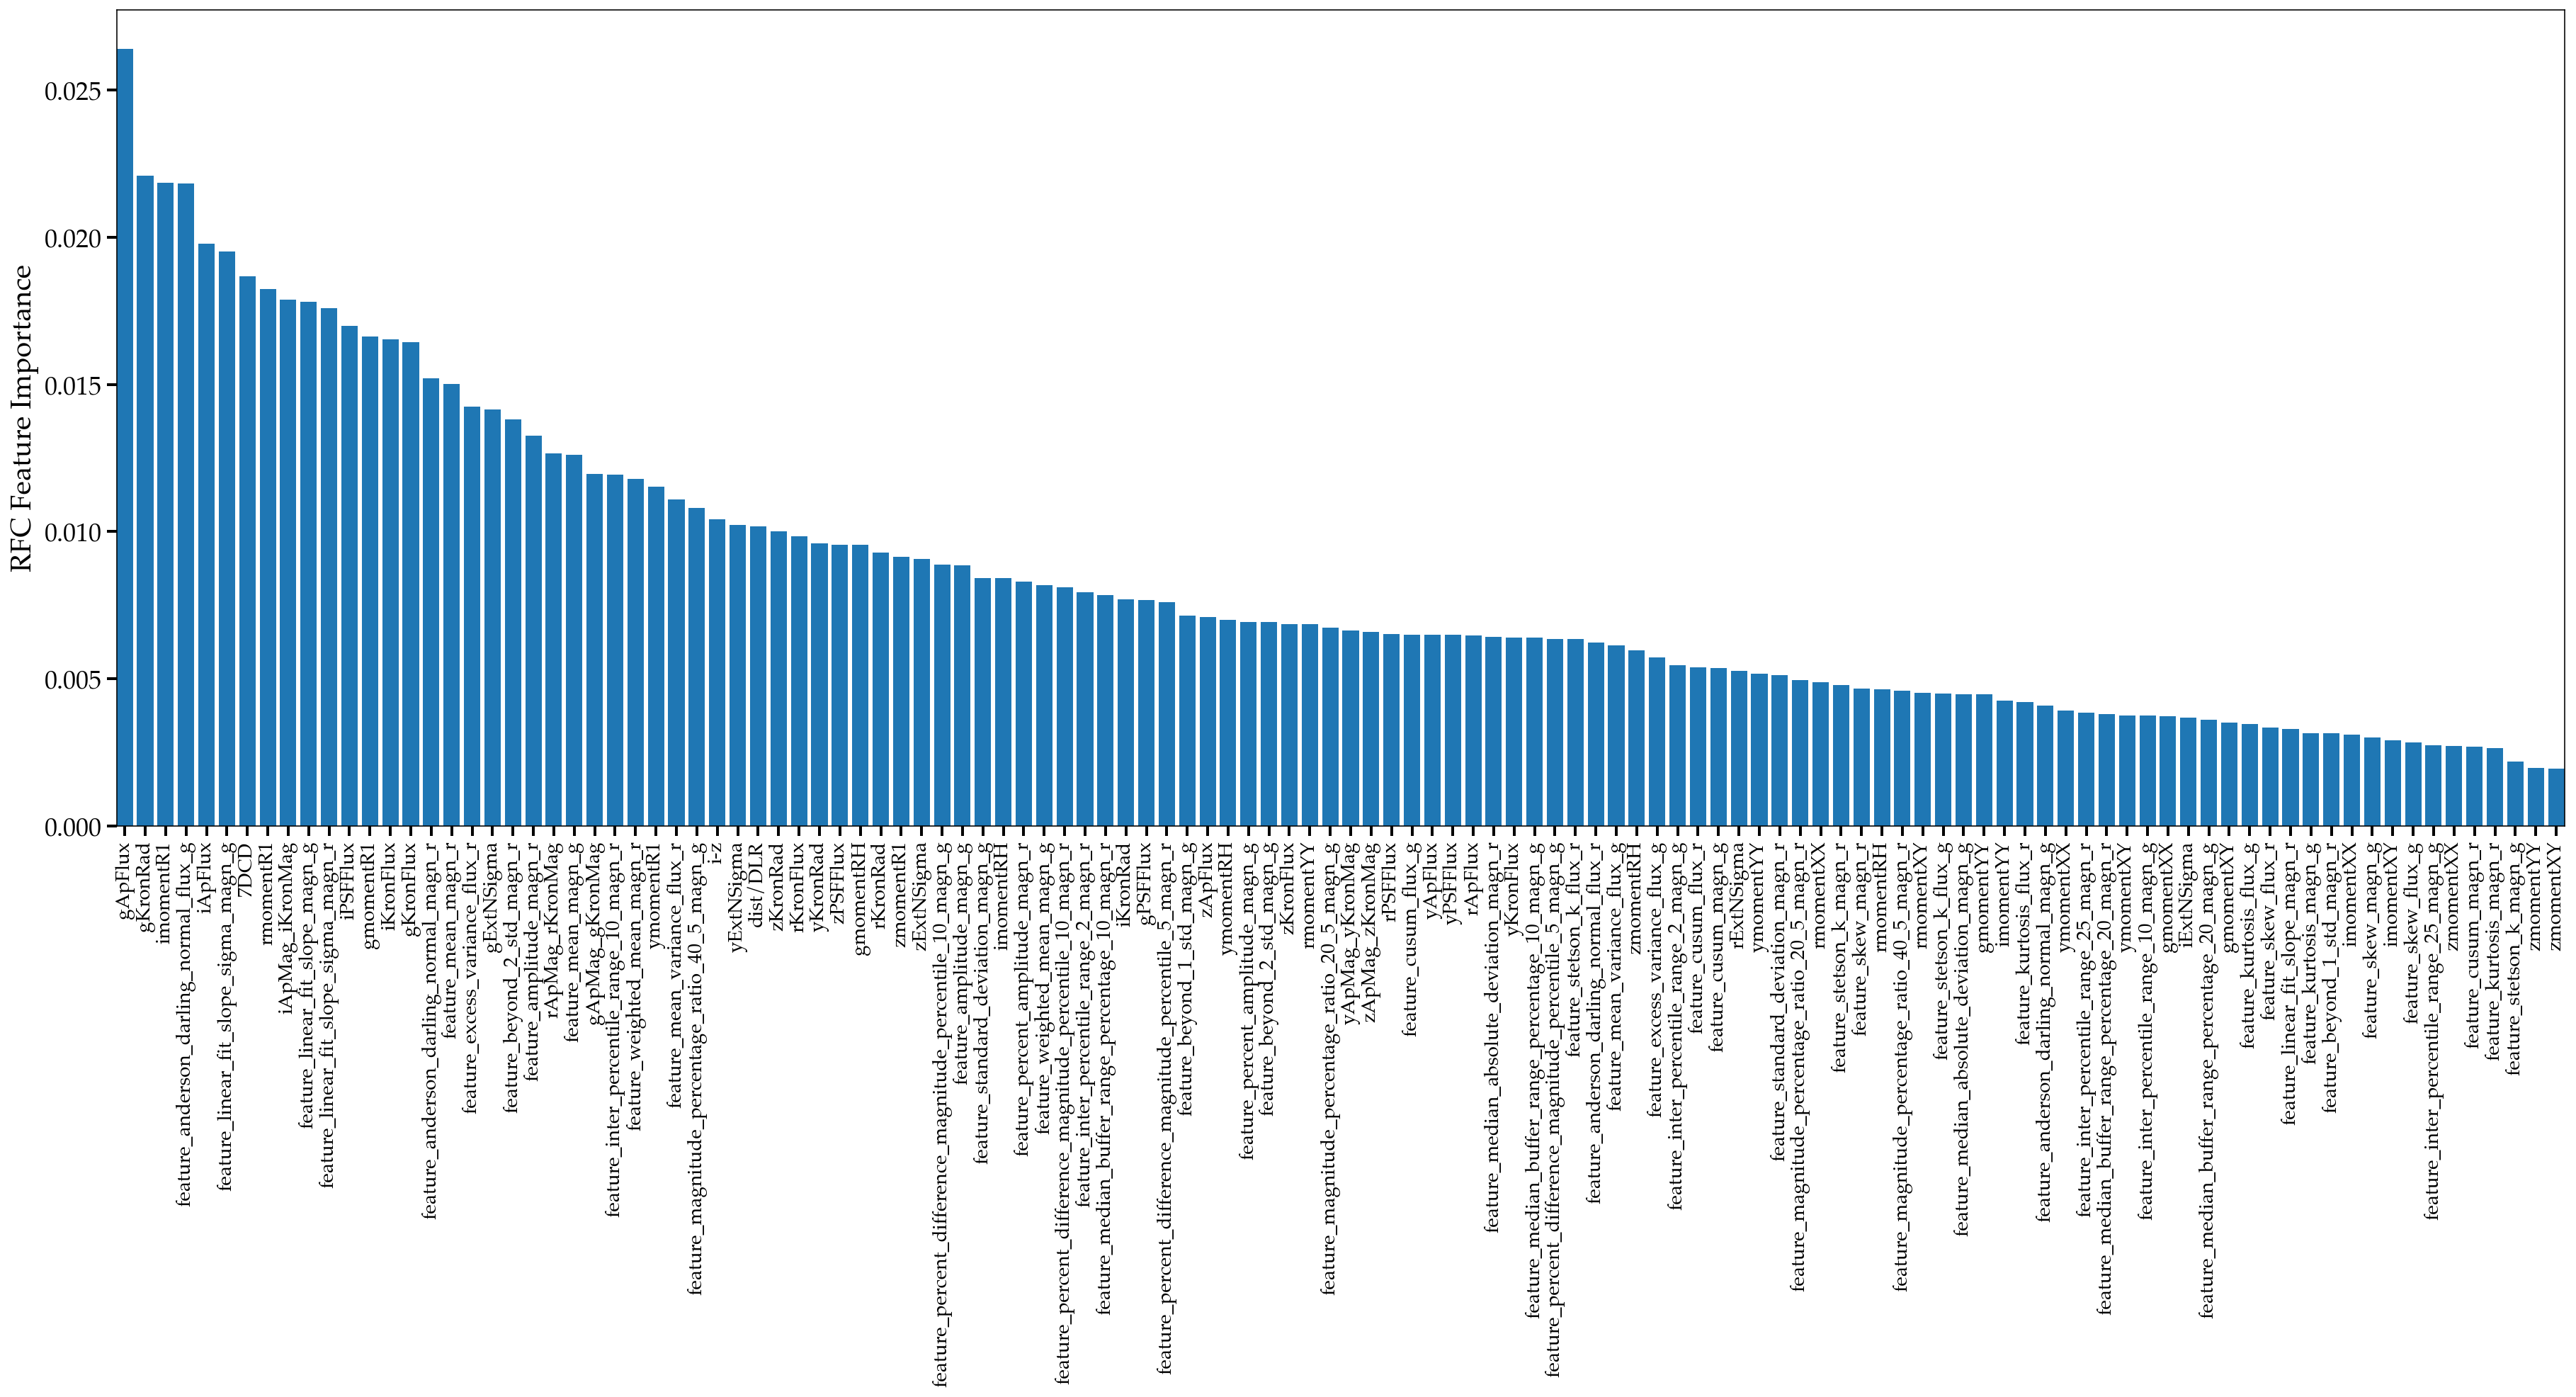

In [34]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

X_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]

fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(range(X_train.shape[1]), importances[indices])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90, fontsize=14)
plt.subplots_adjust(left=0.0, right=1, top=1.0, bottom=0)
ax.set_xlim(left=-0.40, right=119.4)
plt.ylabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_horizontal.jpg', dpi=300, bbox_inches='tight')
plt.show()

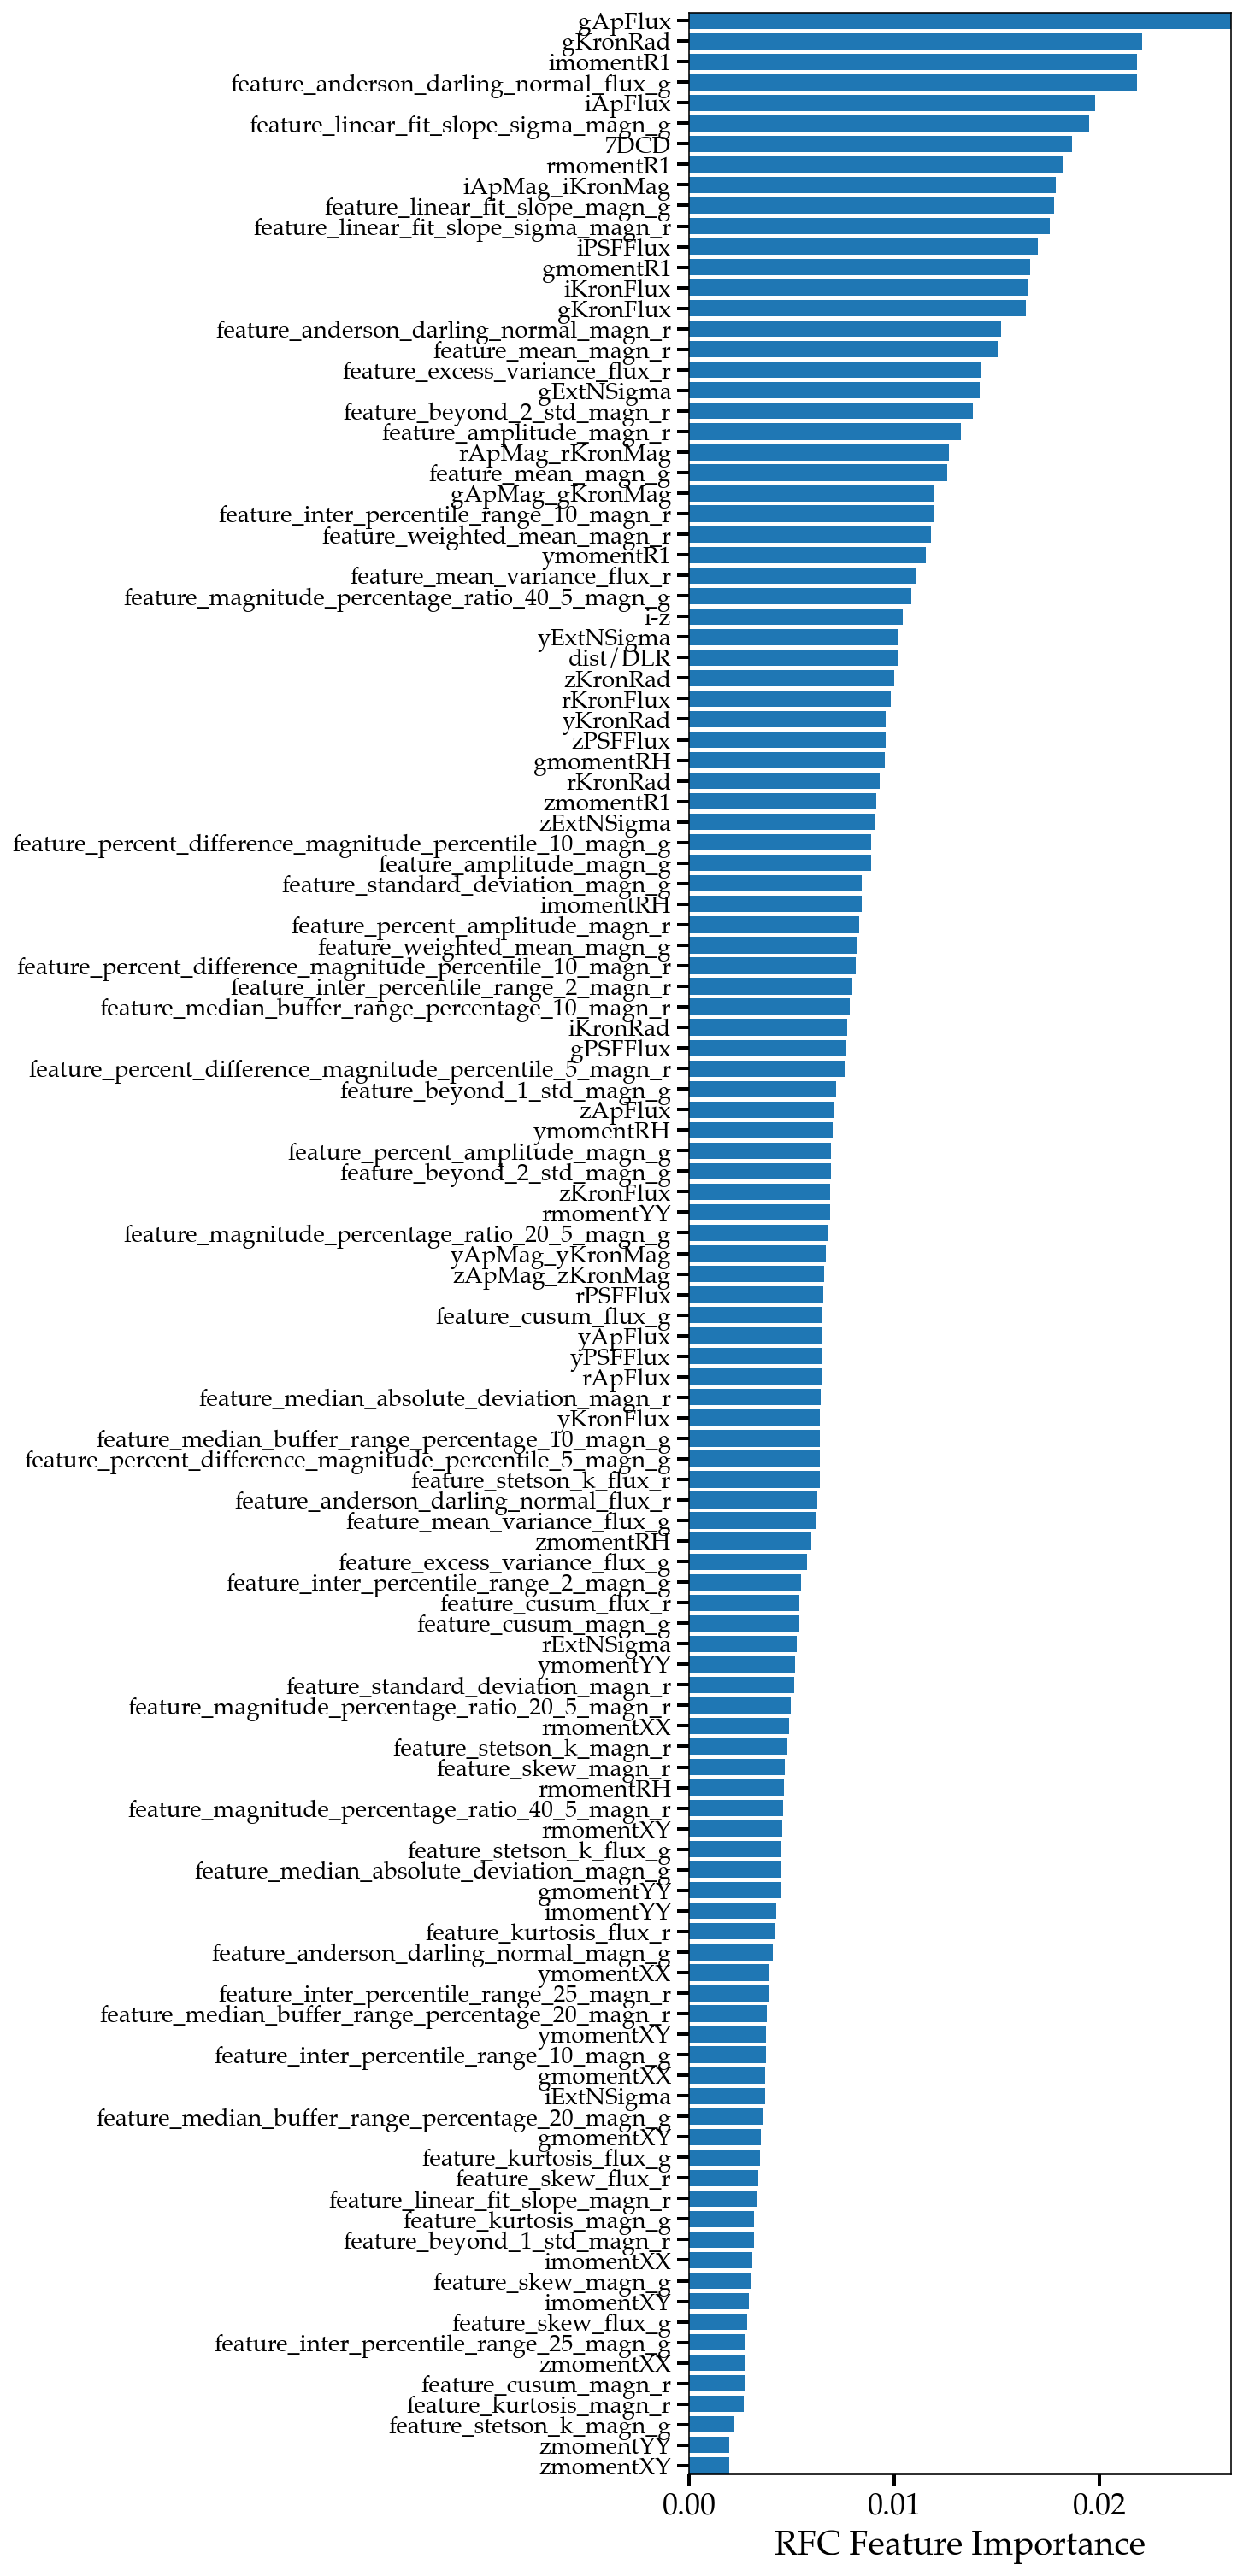

In [35]:
fig, ax = plt.subplots(figsize=(8, 20))
ax.barh(range(X_train.shape[1]), importances[indices][::-1])
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(X_train.columns[indices][::-1], fontsize=14)
plt.subplots_adjust(left=0.4, right=0.95, top=1.0, bottom=0)
ax.set_ylim(top=119.4, bottom=-0.40)
ax.set_xlim(right=np.max(importances[indices][::-1]))
plt.xlabel('RFC Feature Importance')
plt.savefig(f'{folder_path}/RFC_feature_importance_vertical.jpg', dpi=300, bbox_inches='tight')
plt.show()

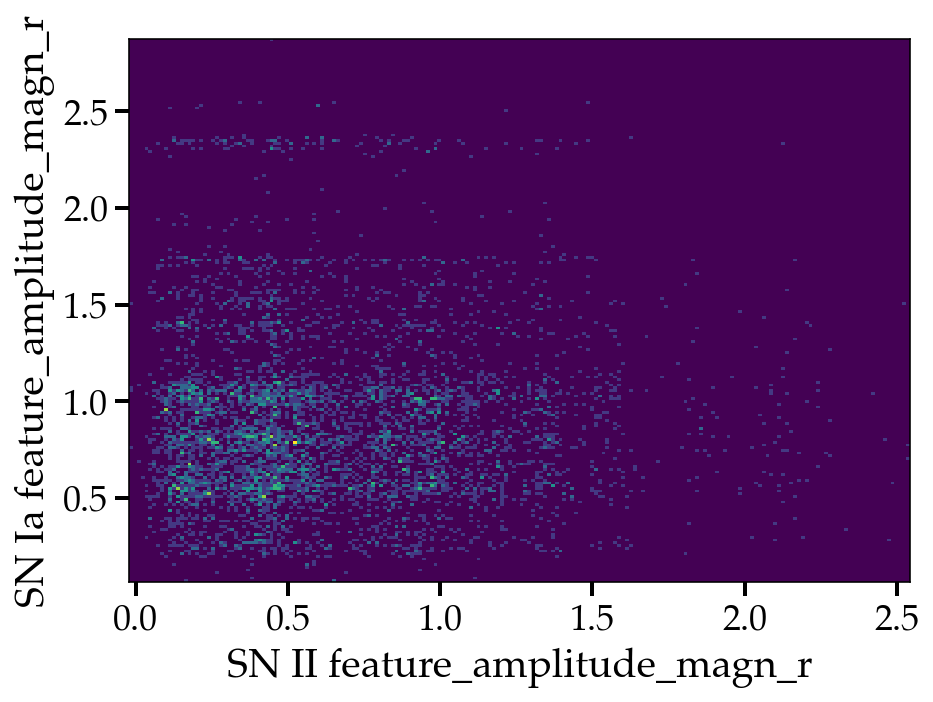

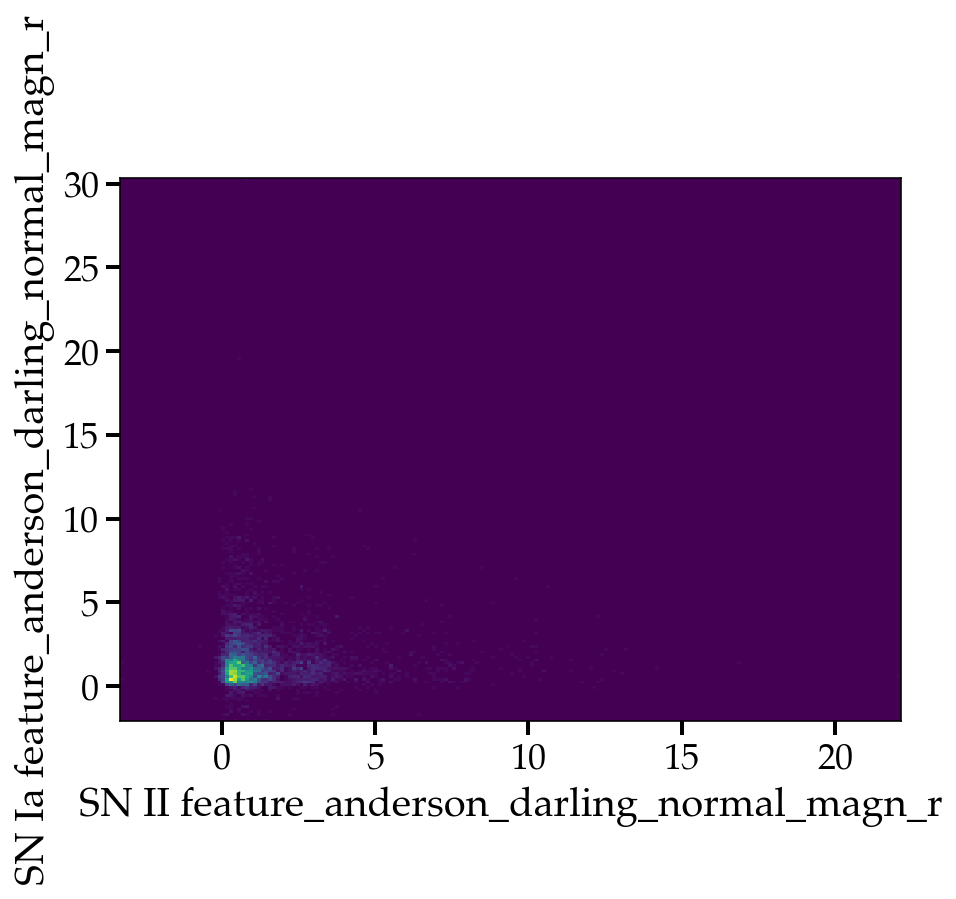

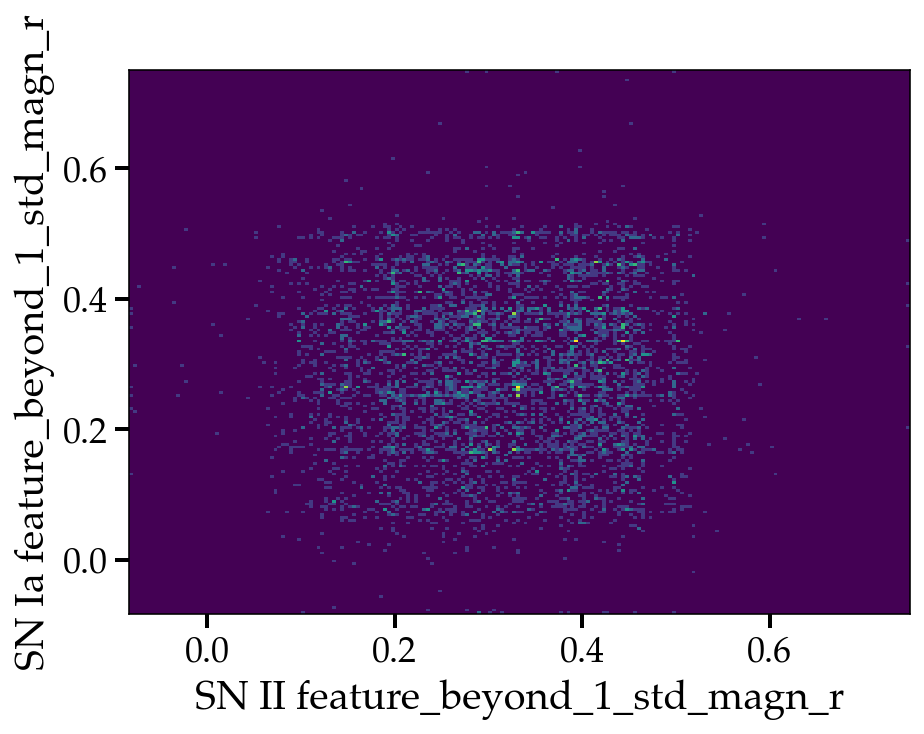

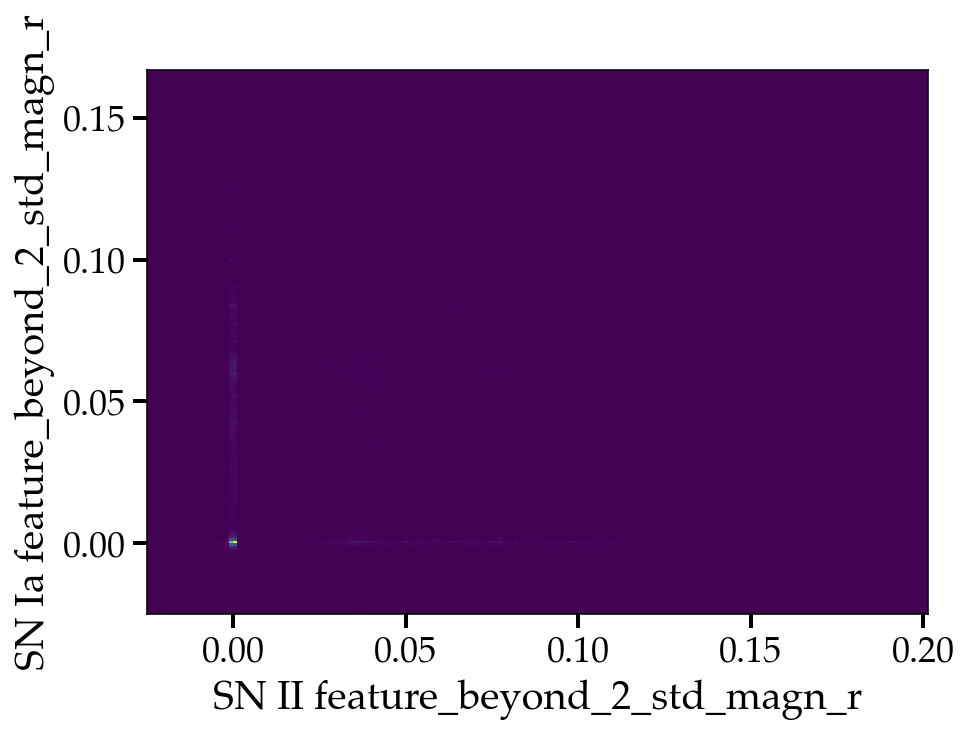

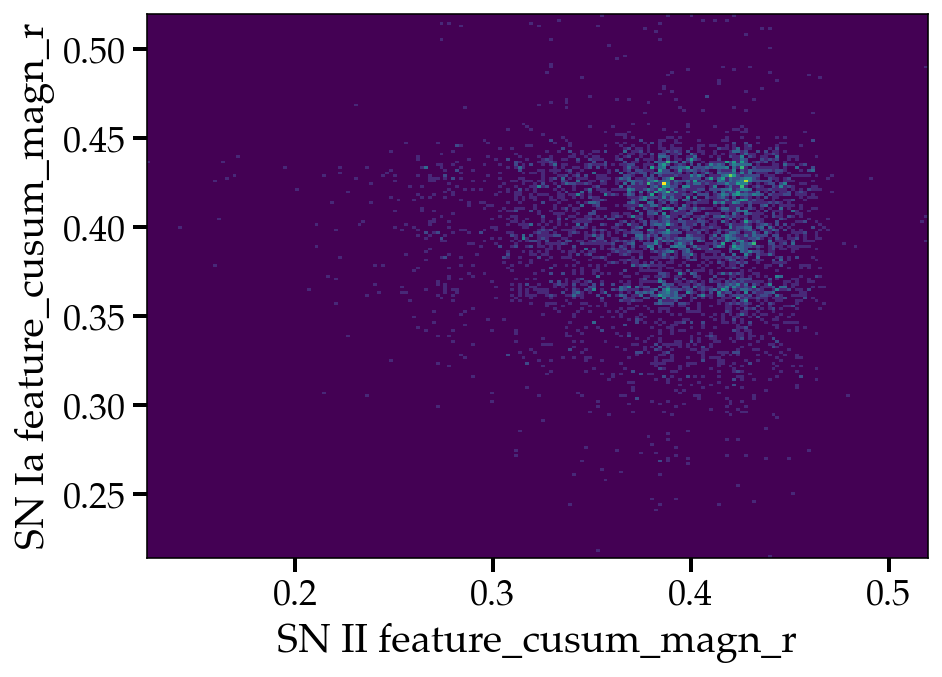

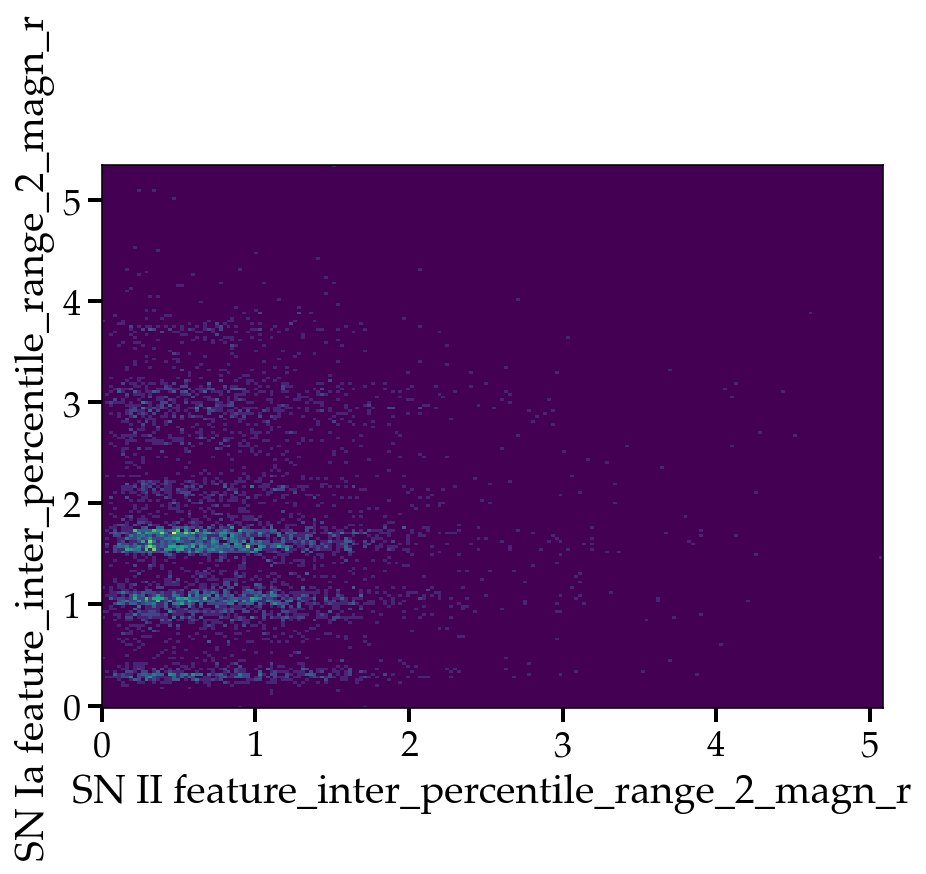

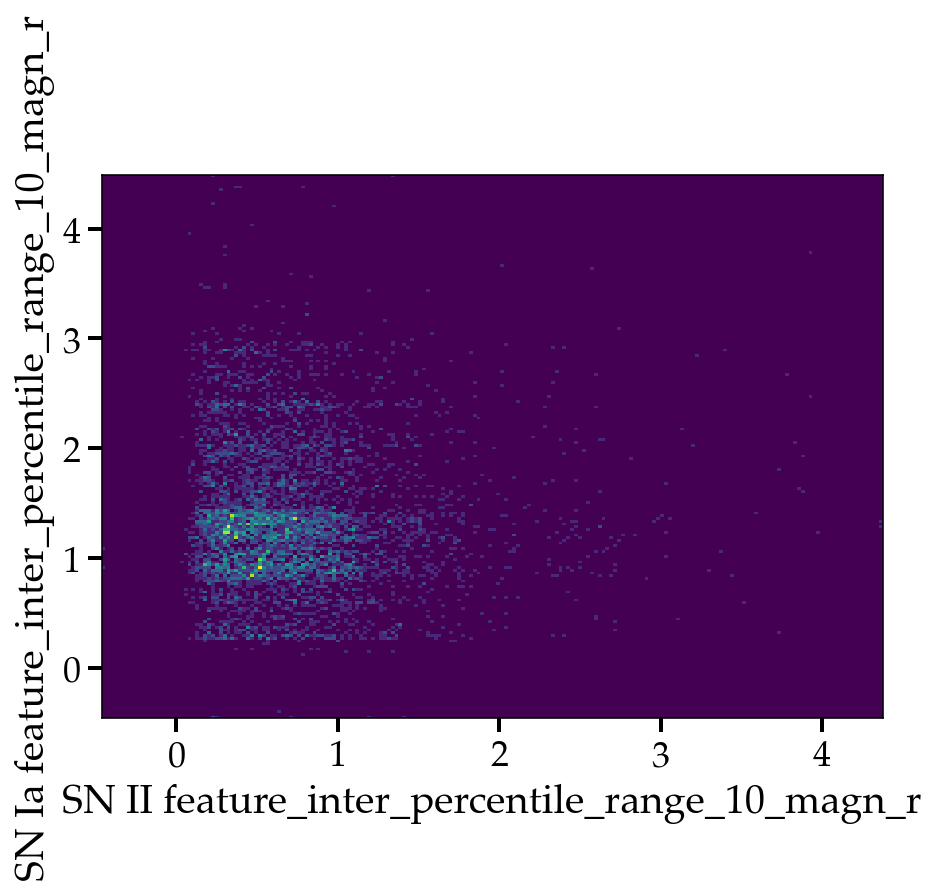

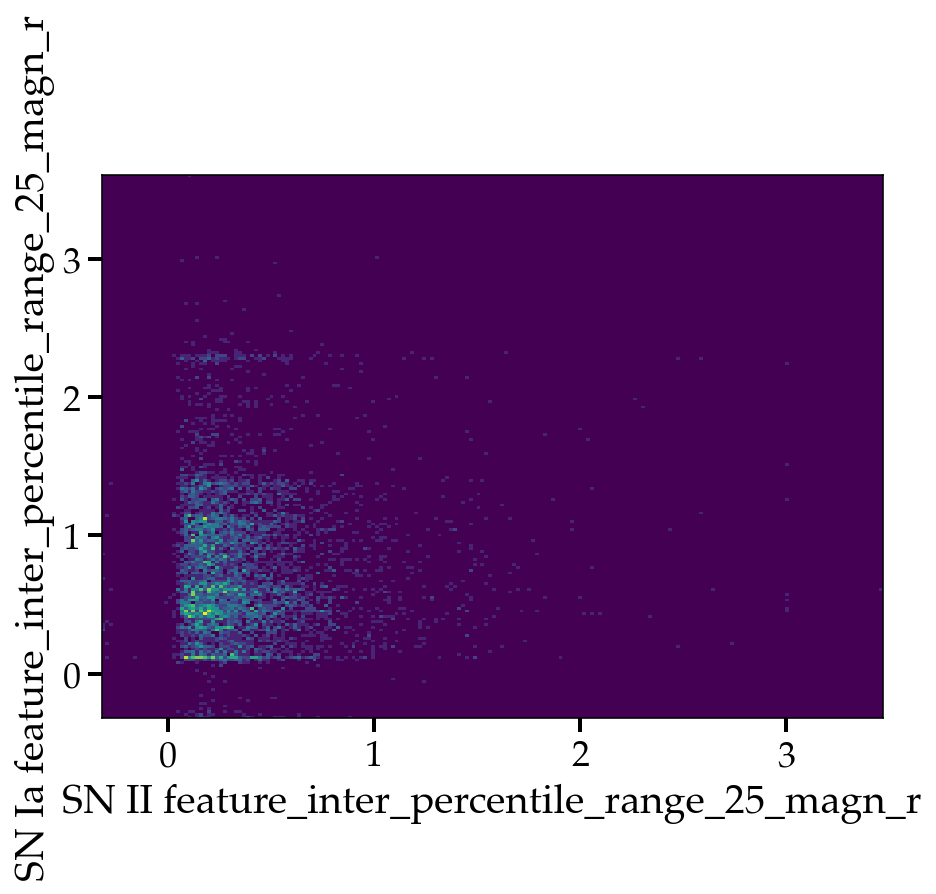

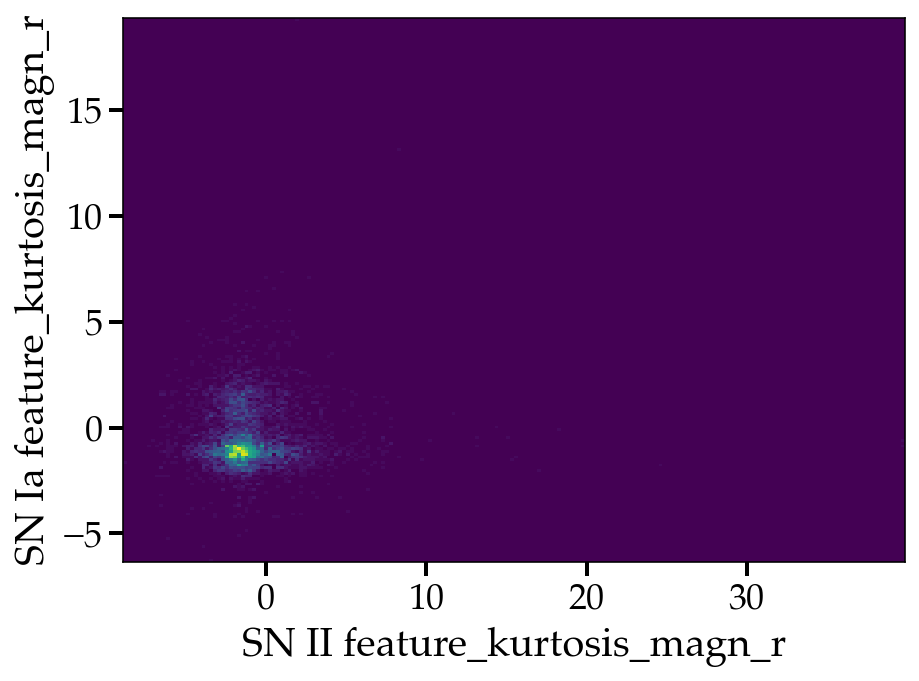

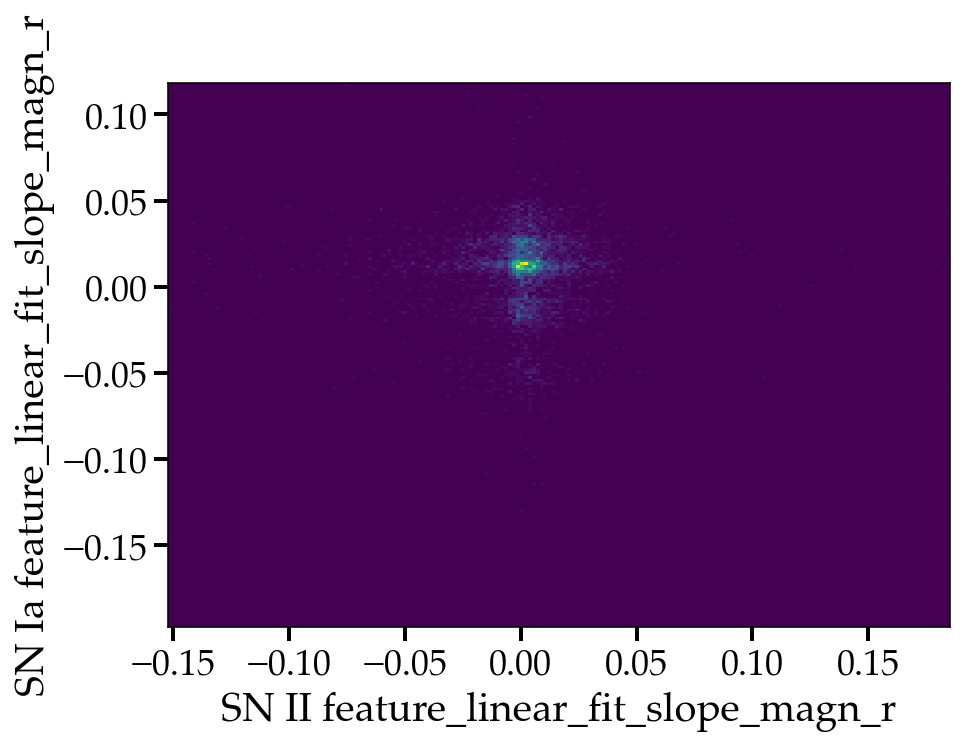

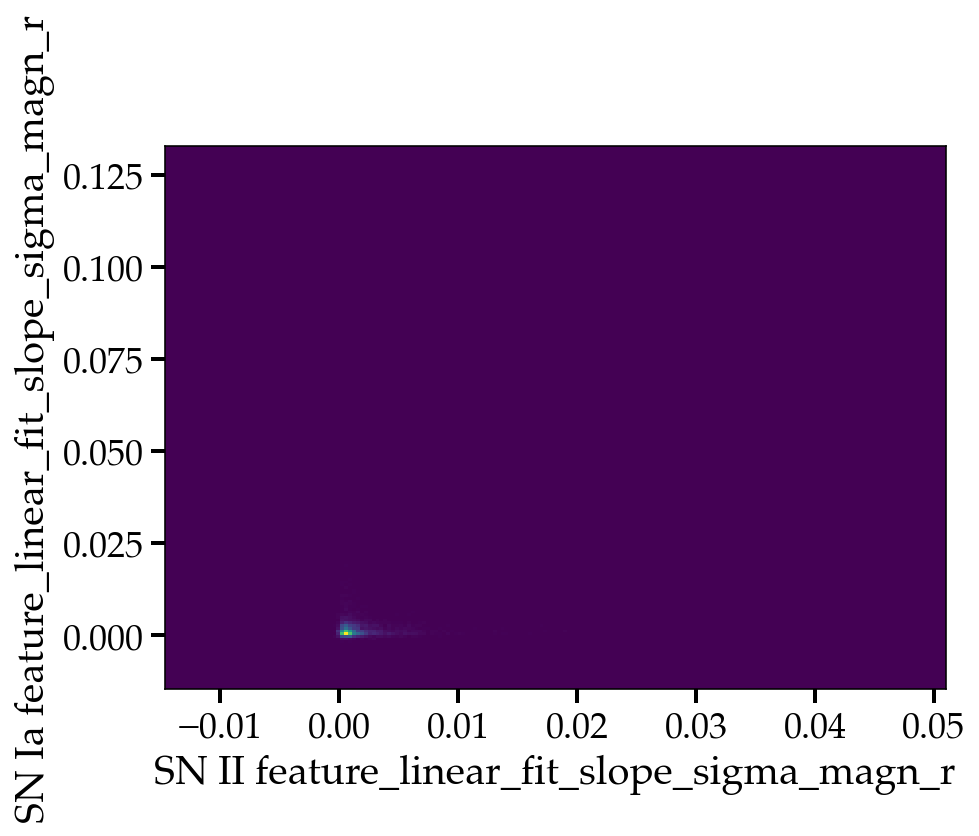

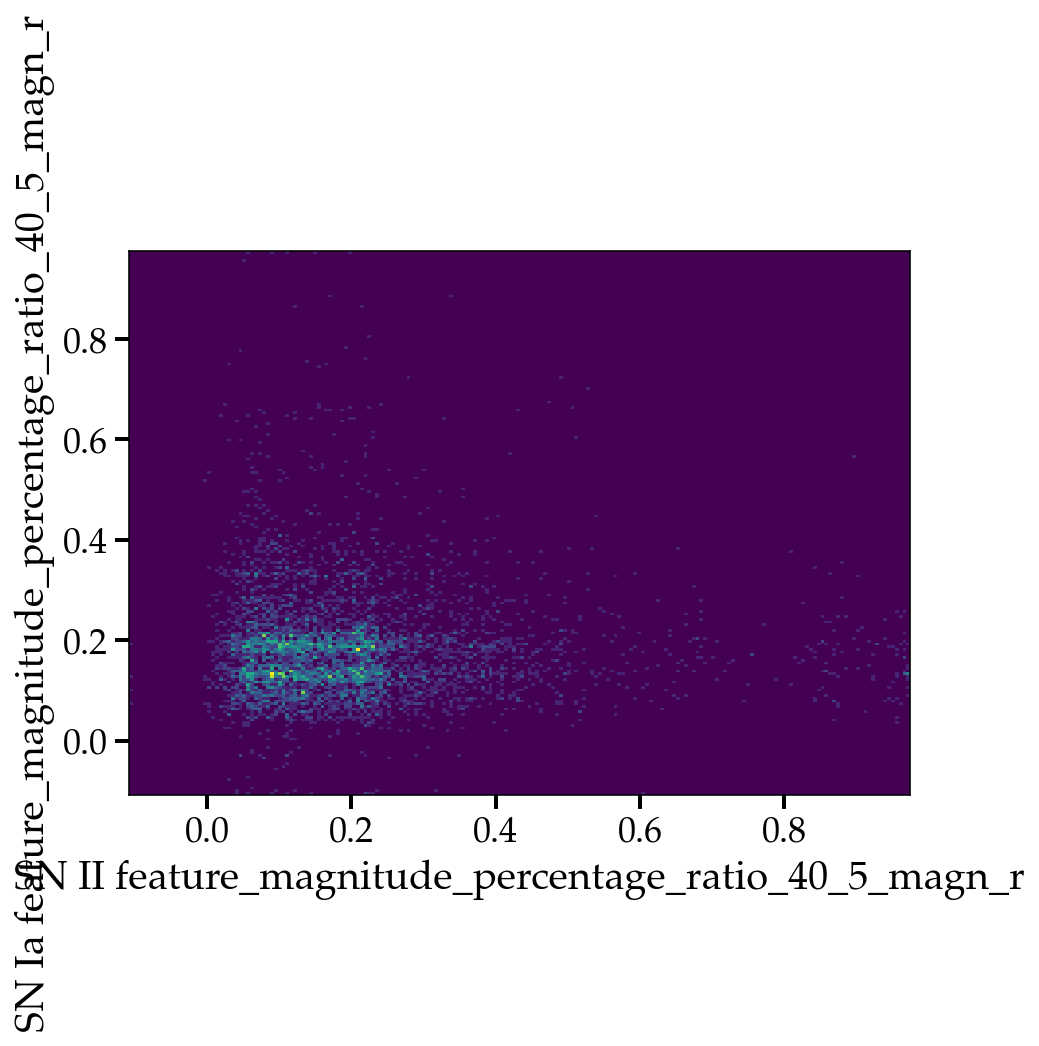

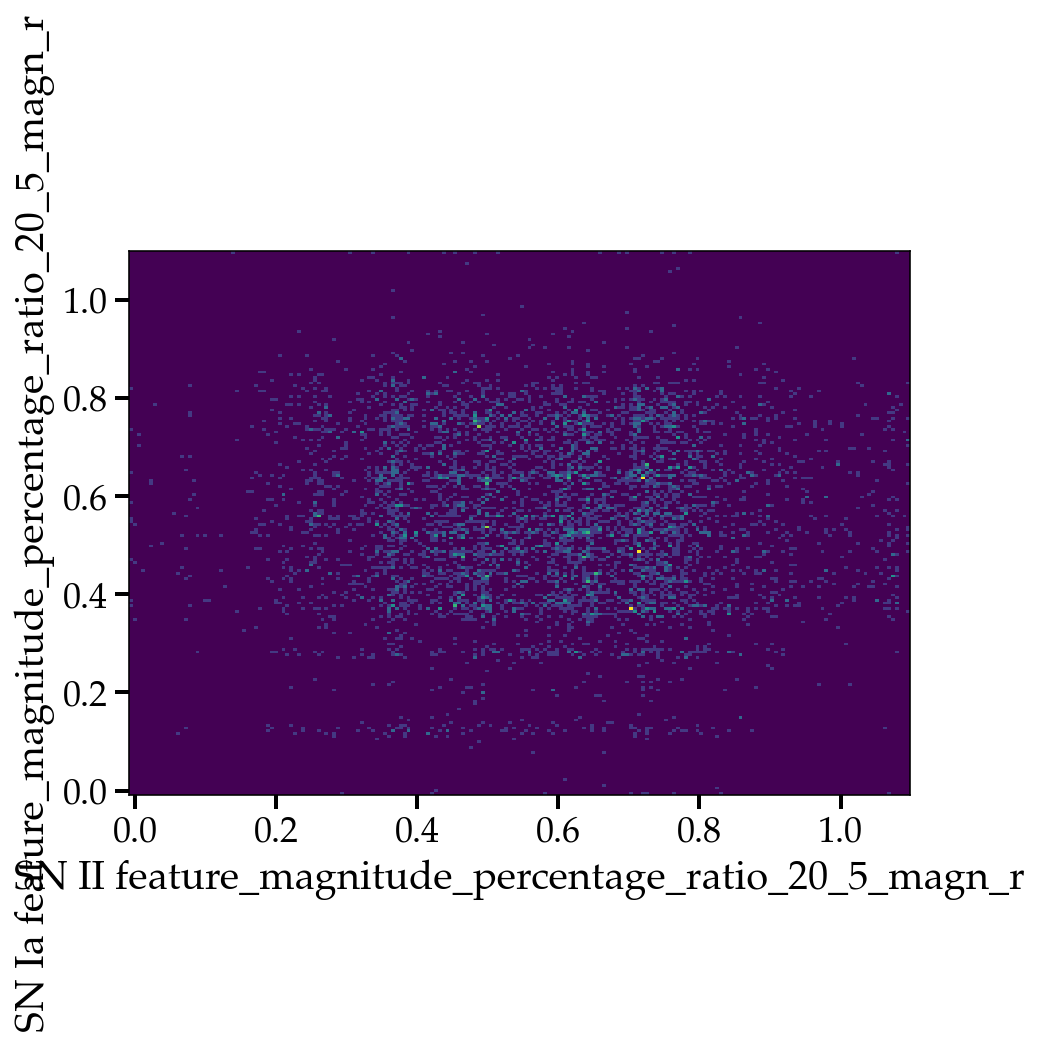

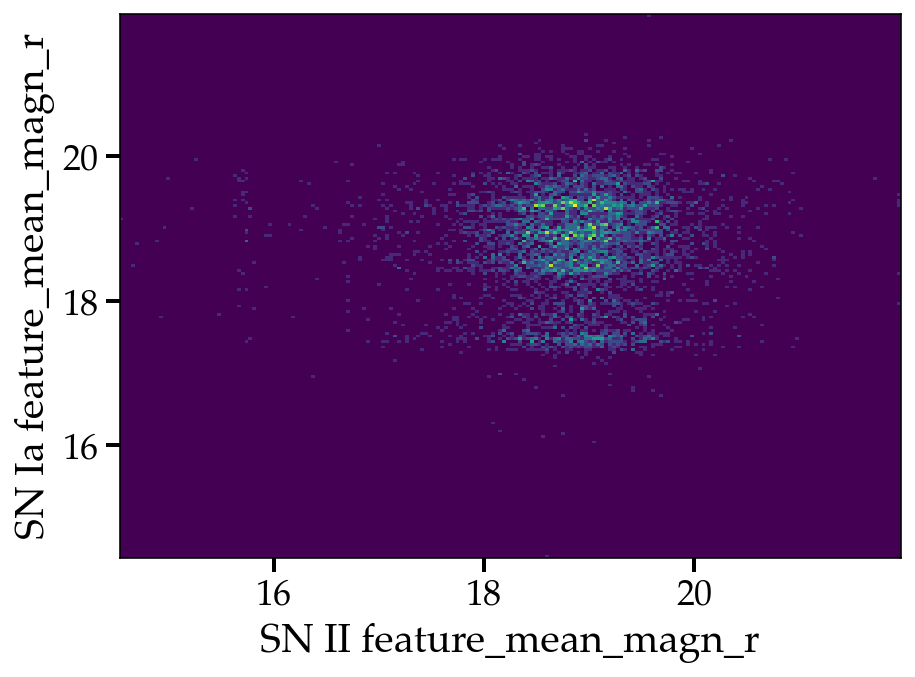

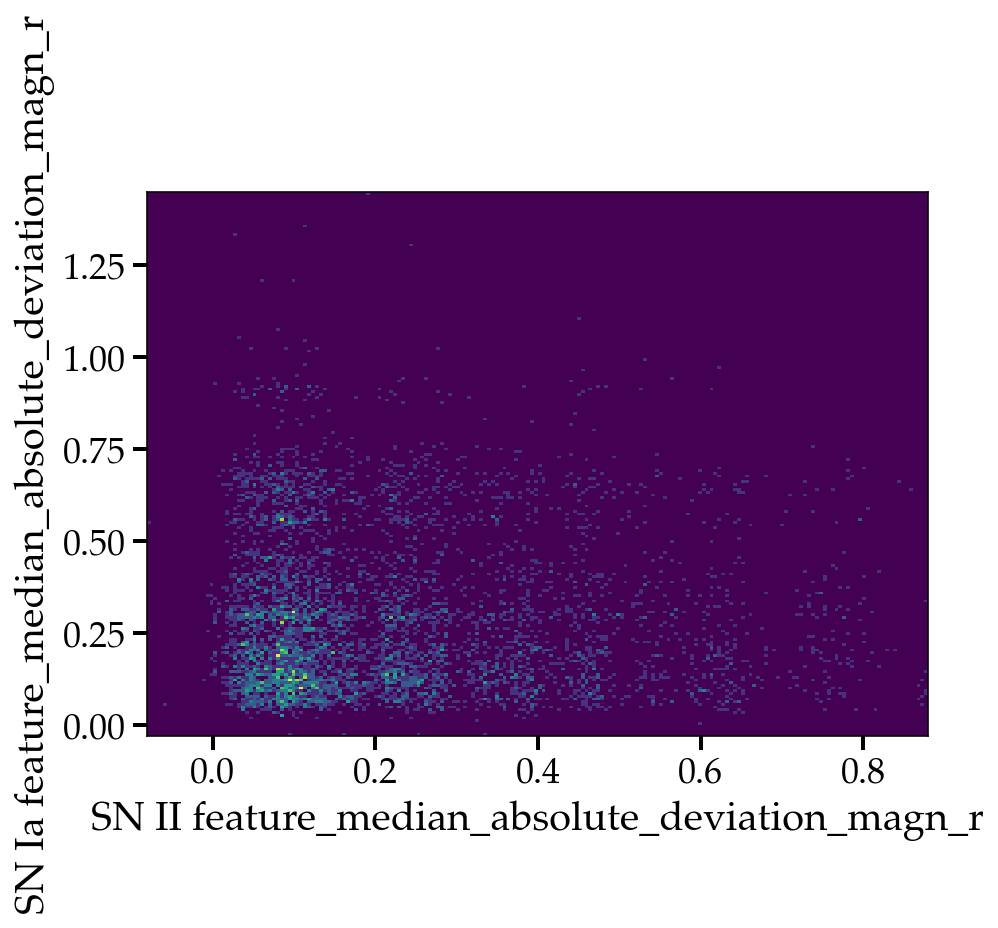

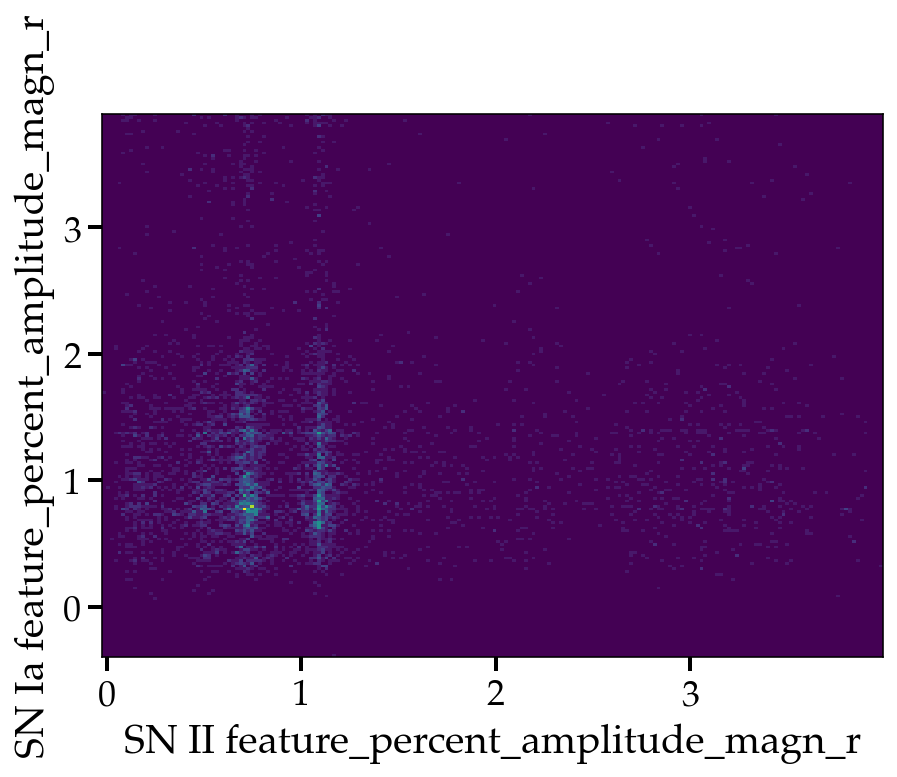

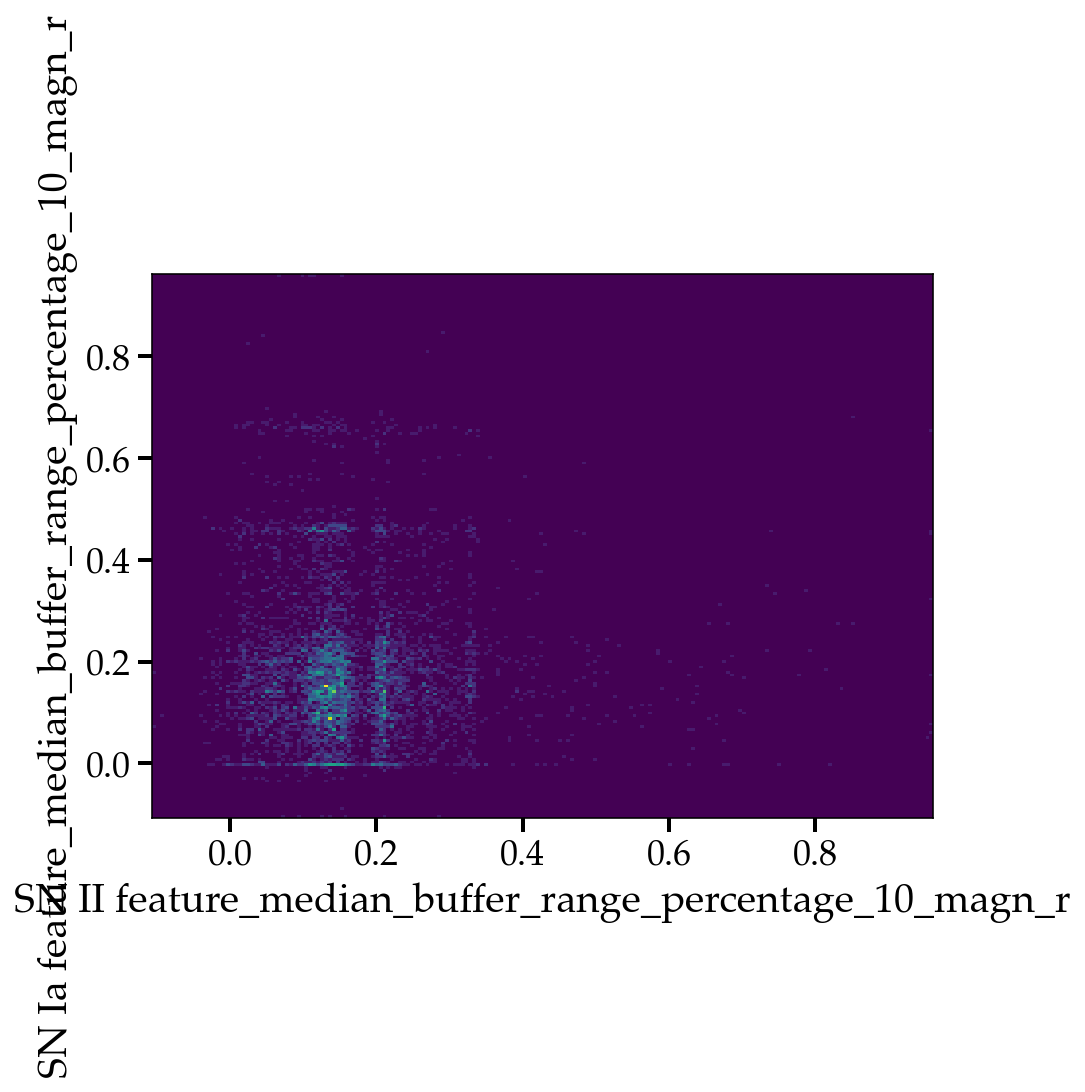

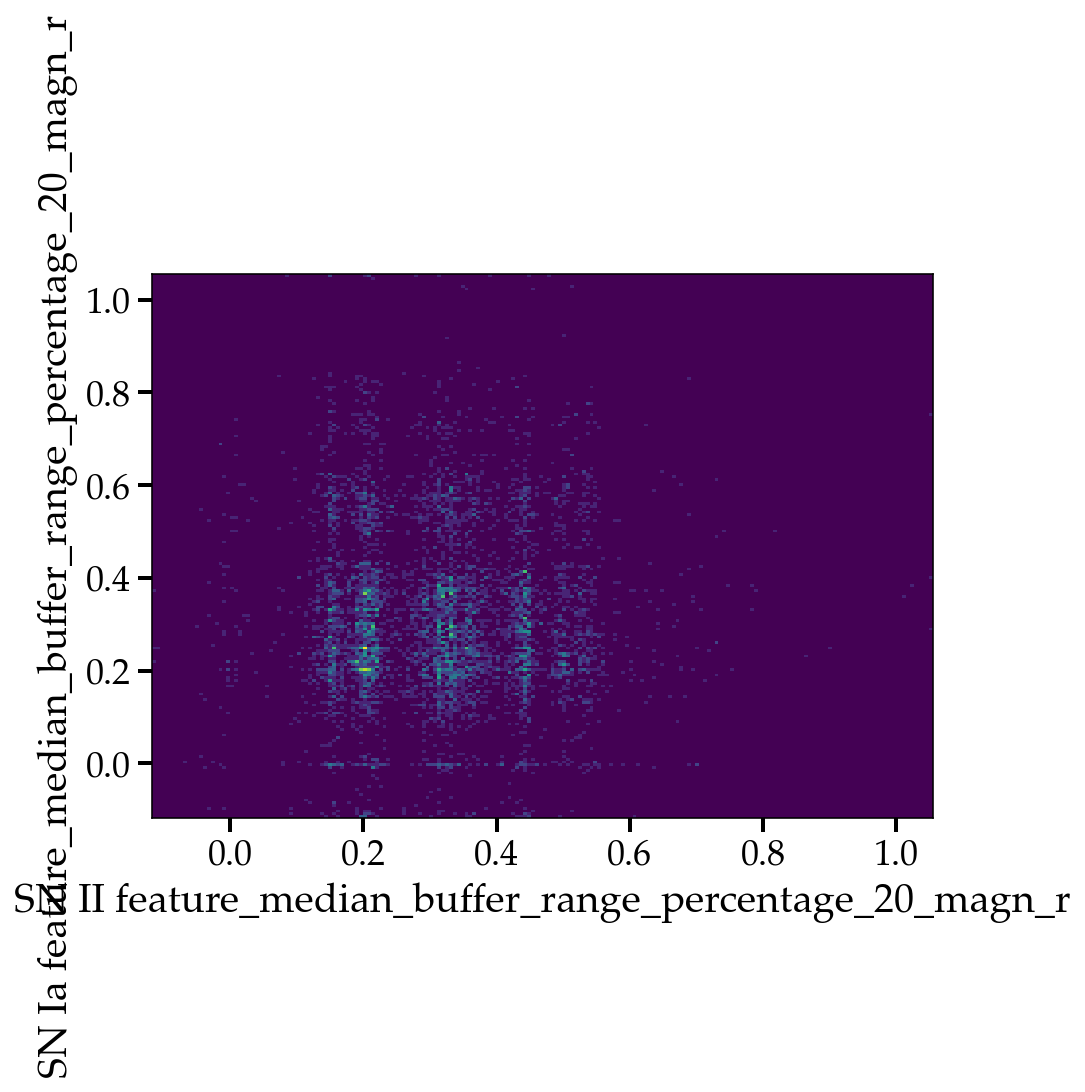

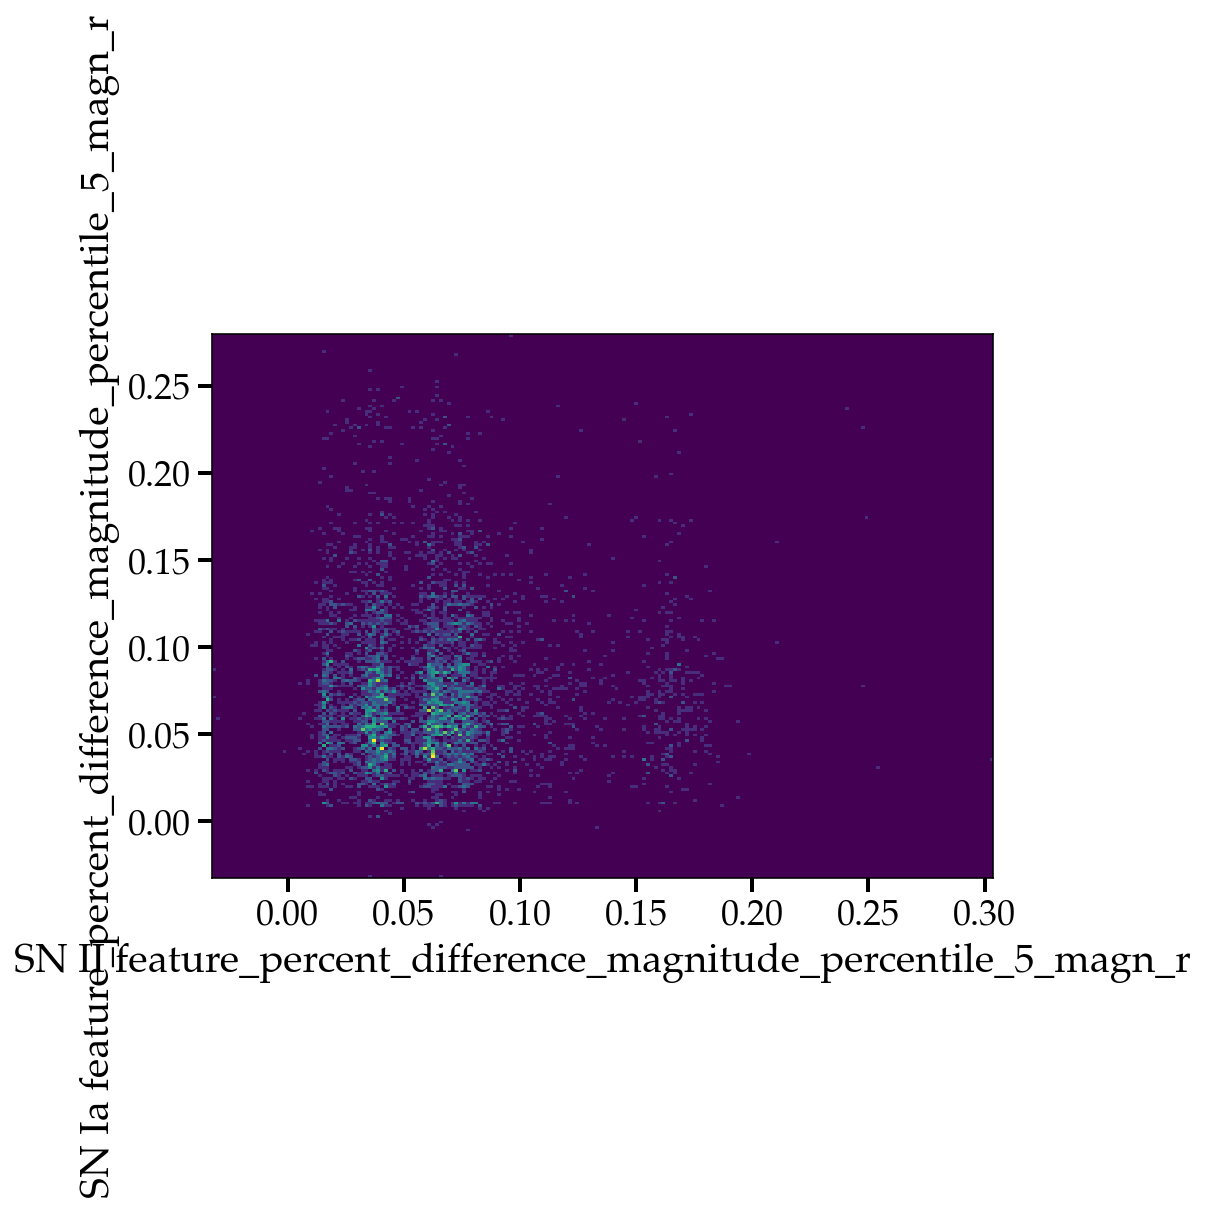

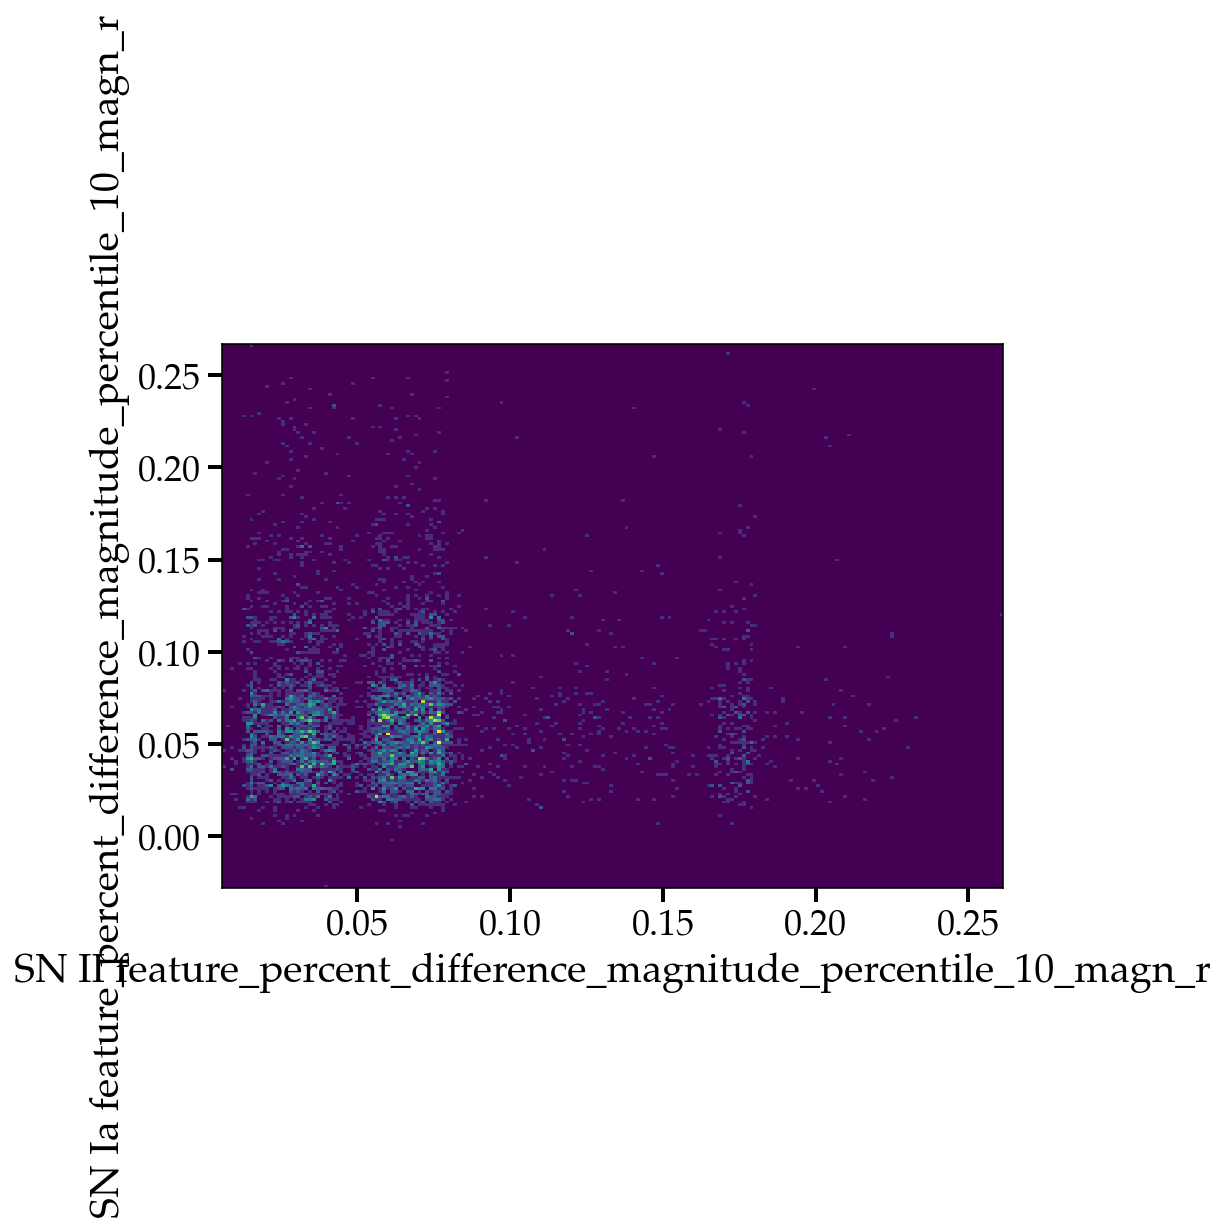

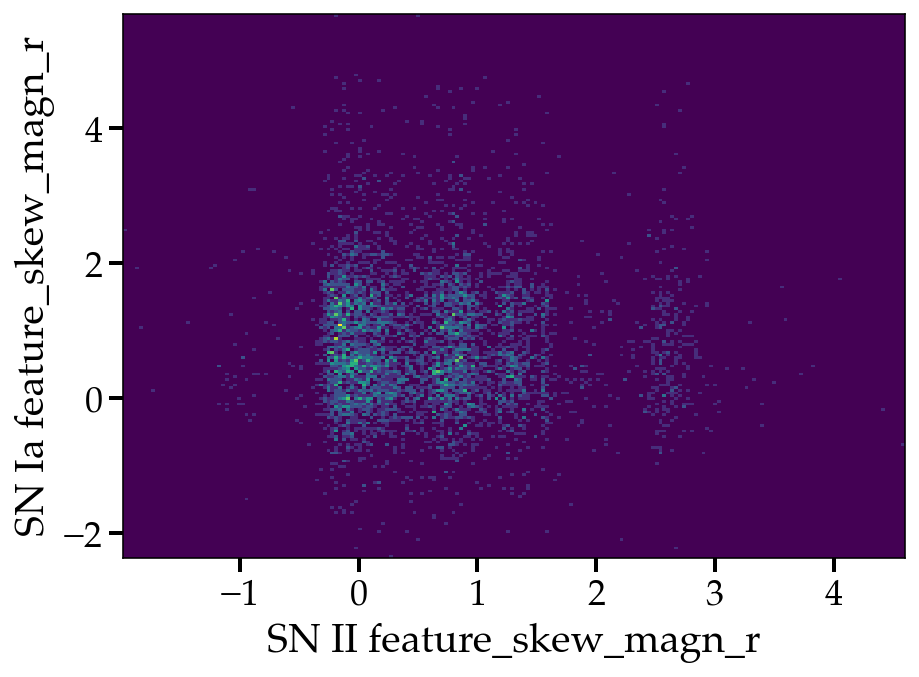

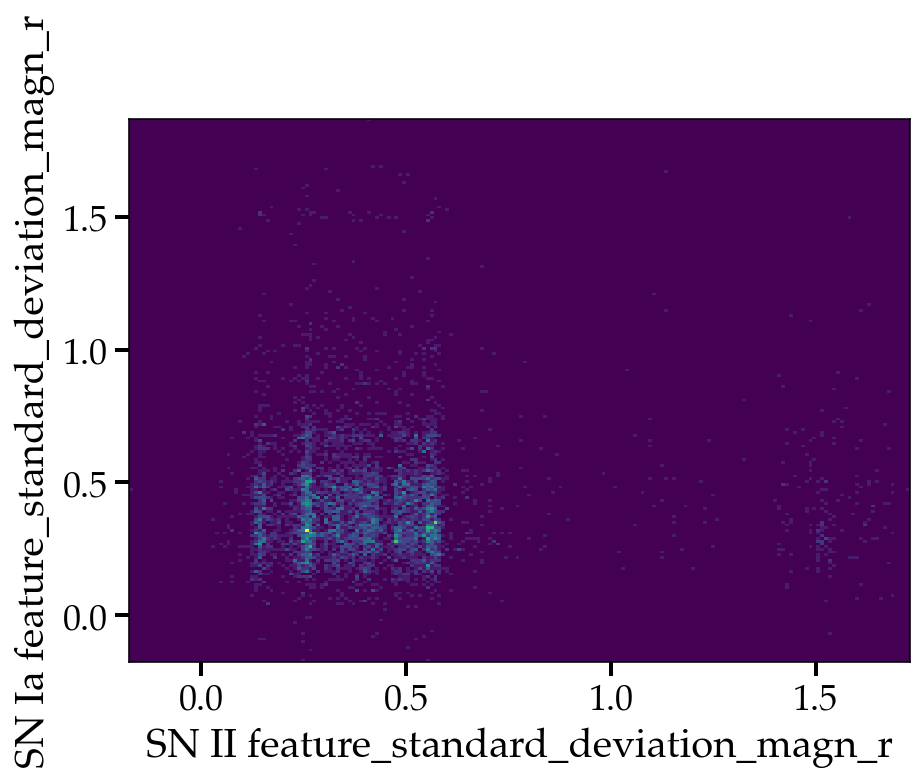

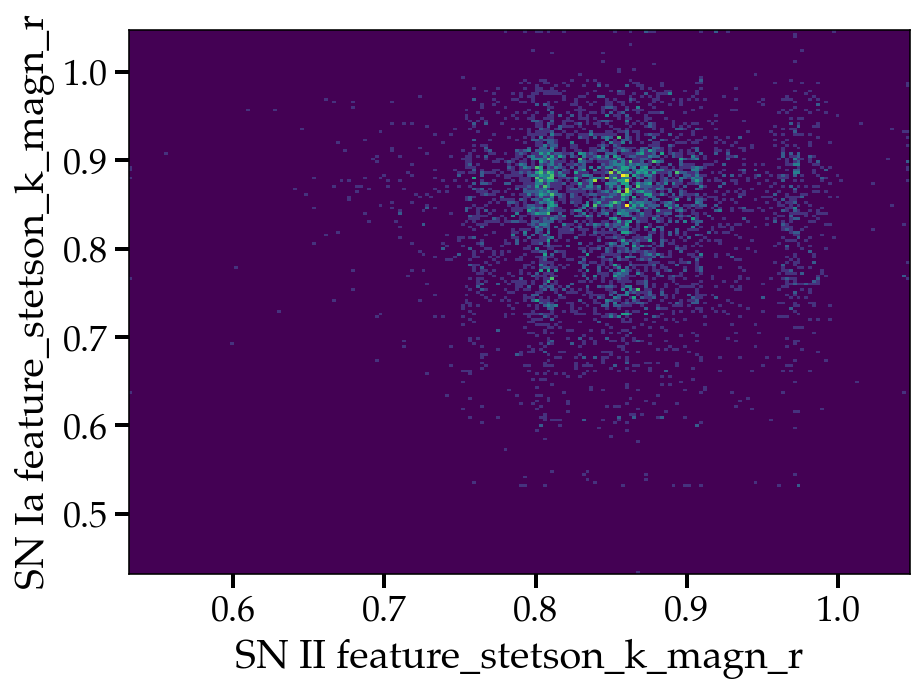

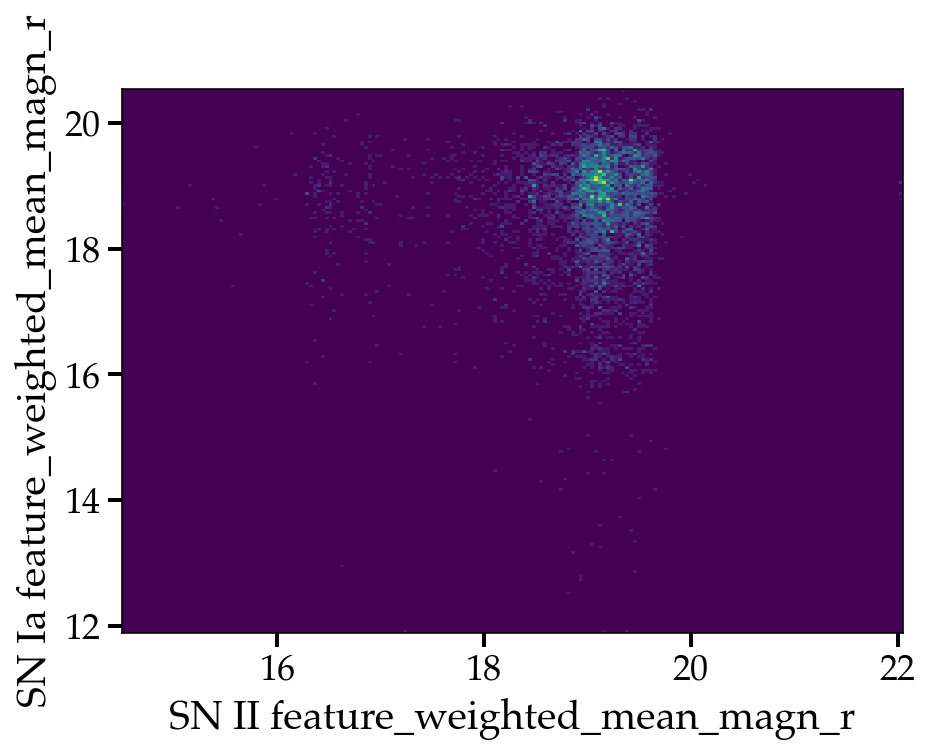

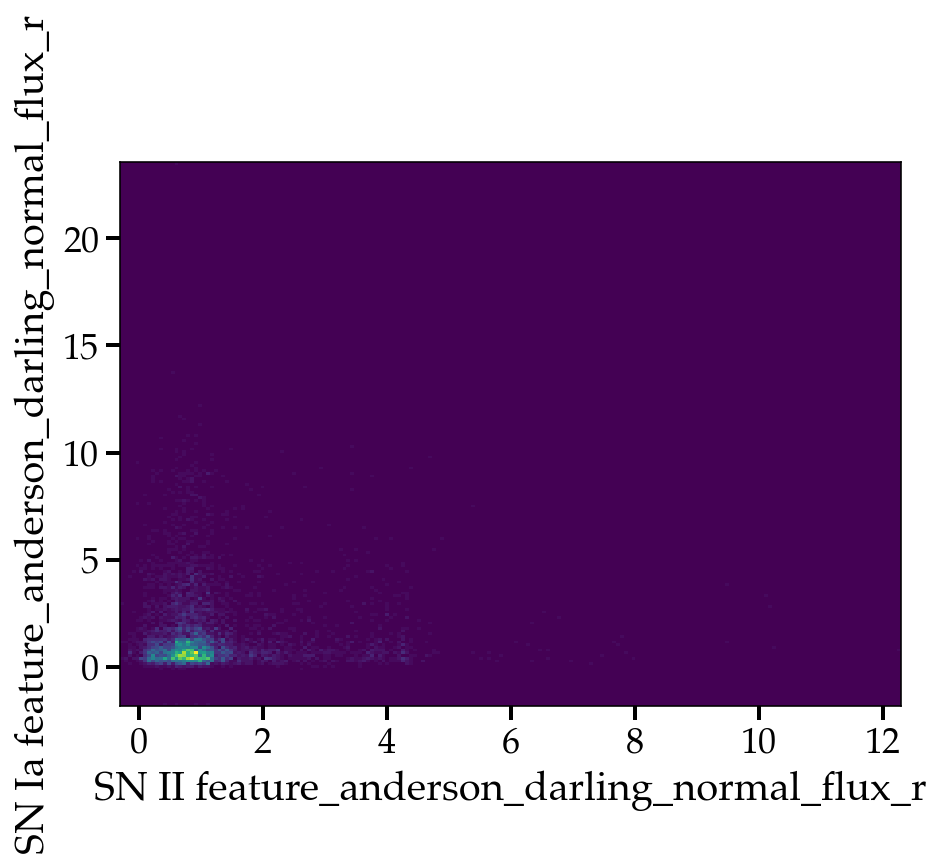

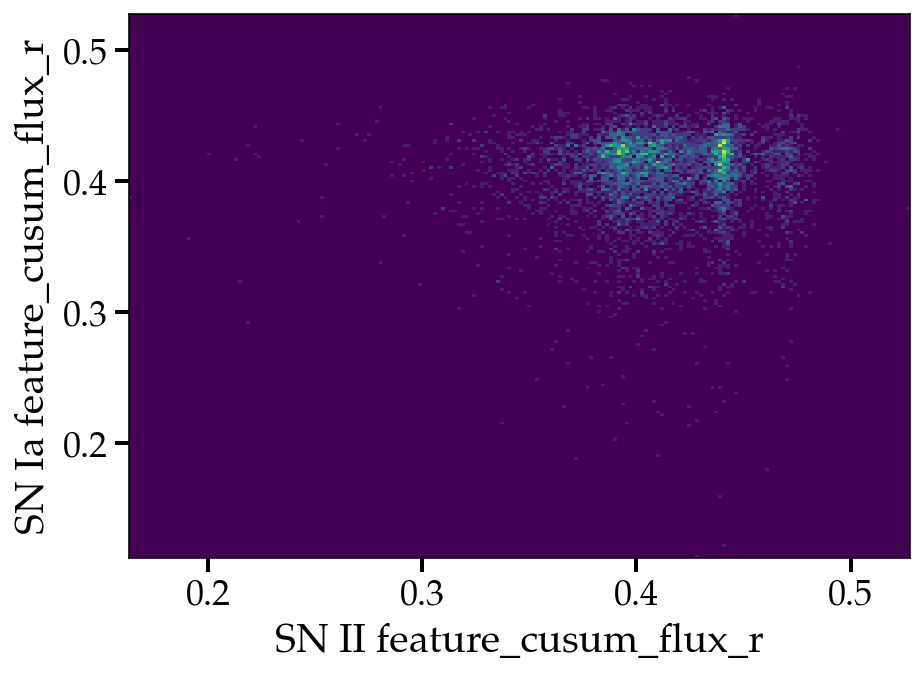

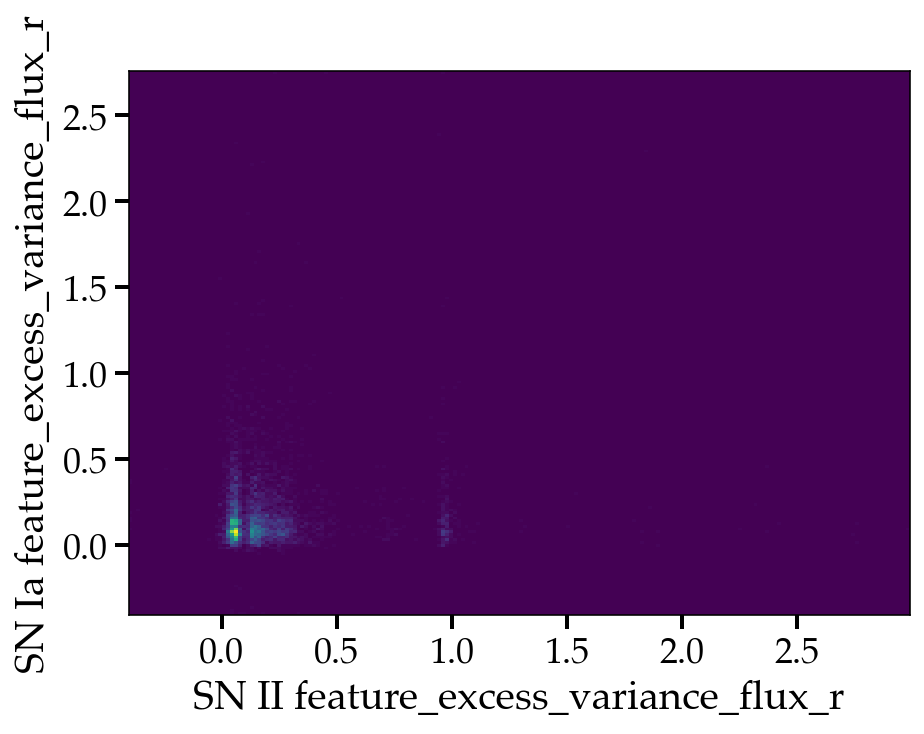

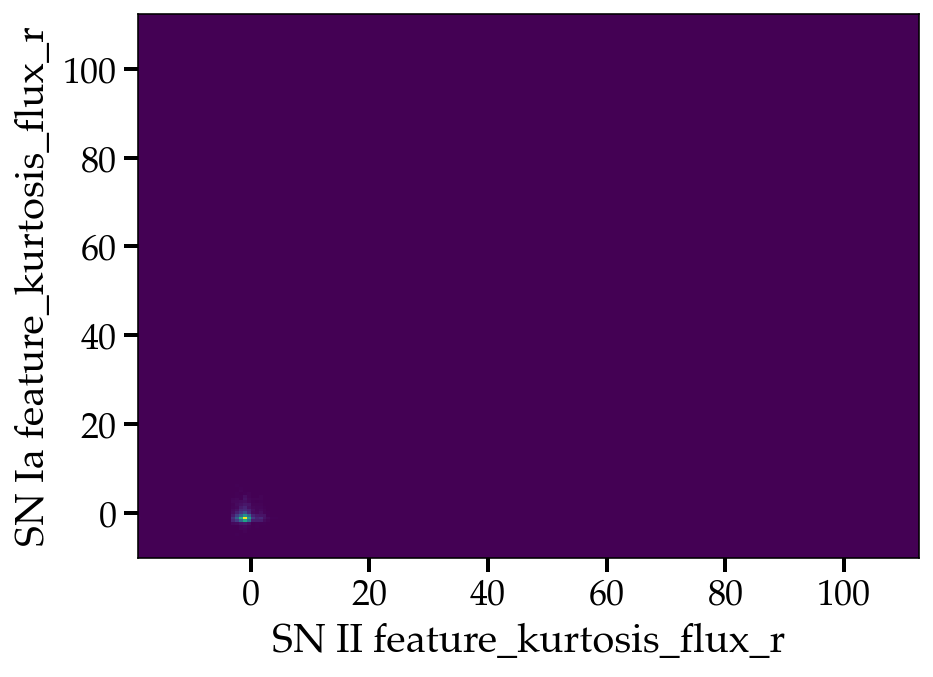

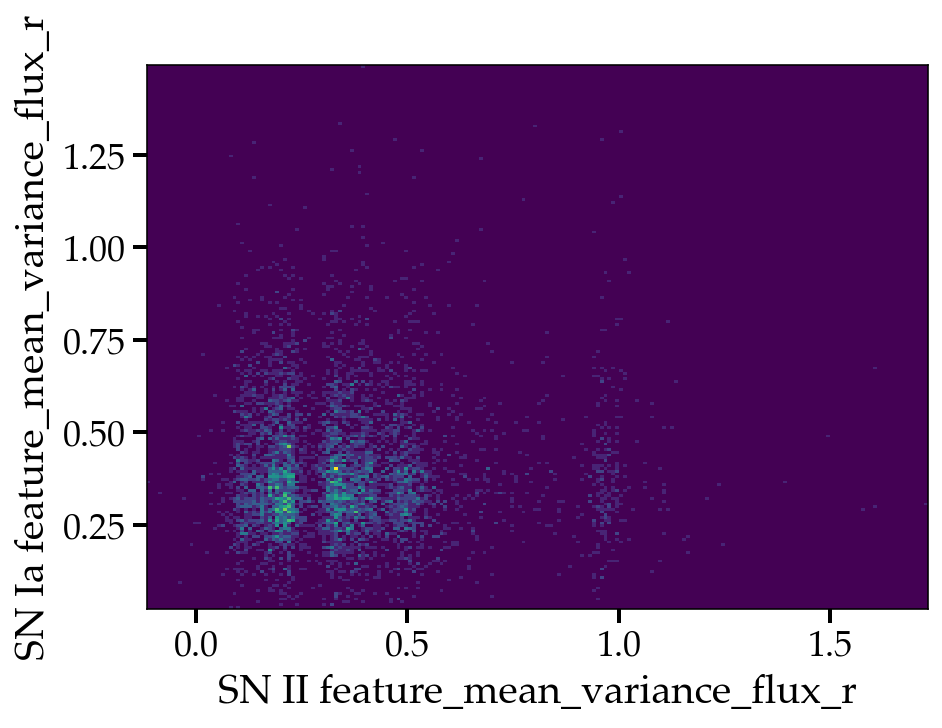

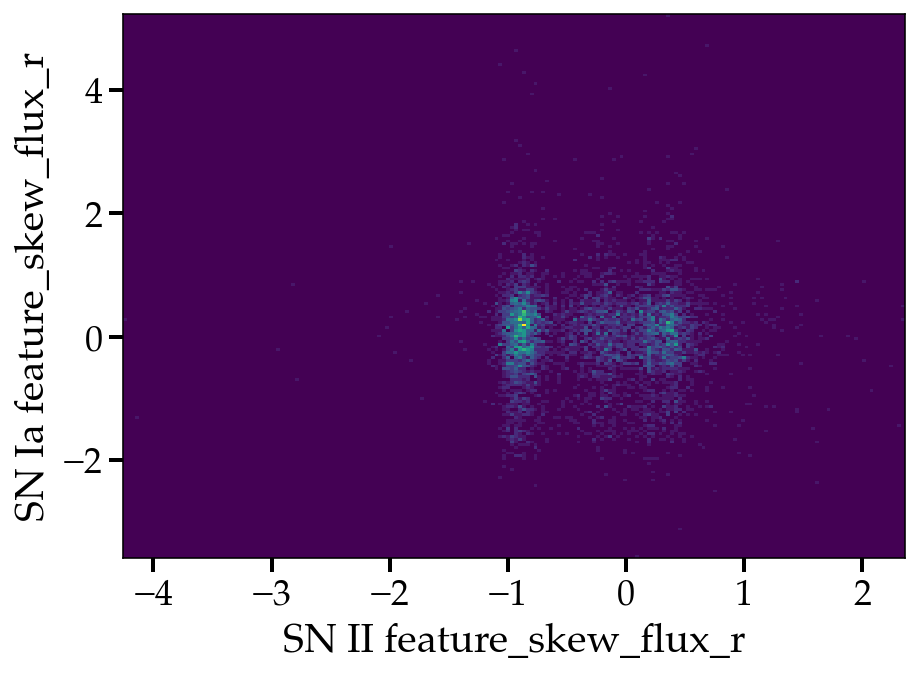

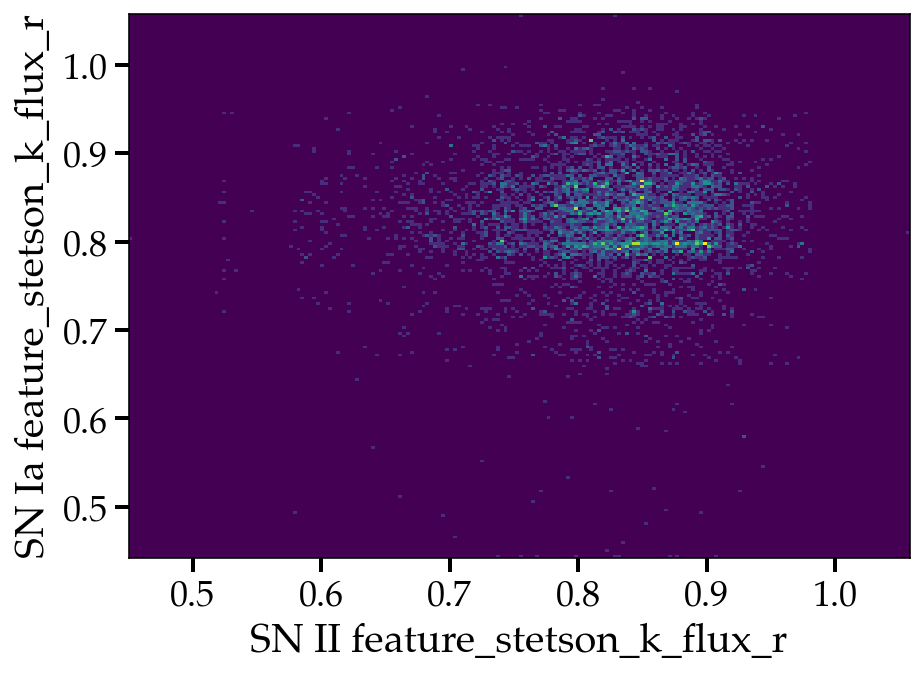

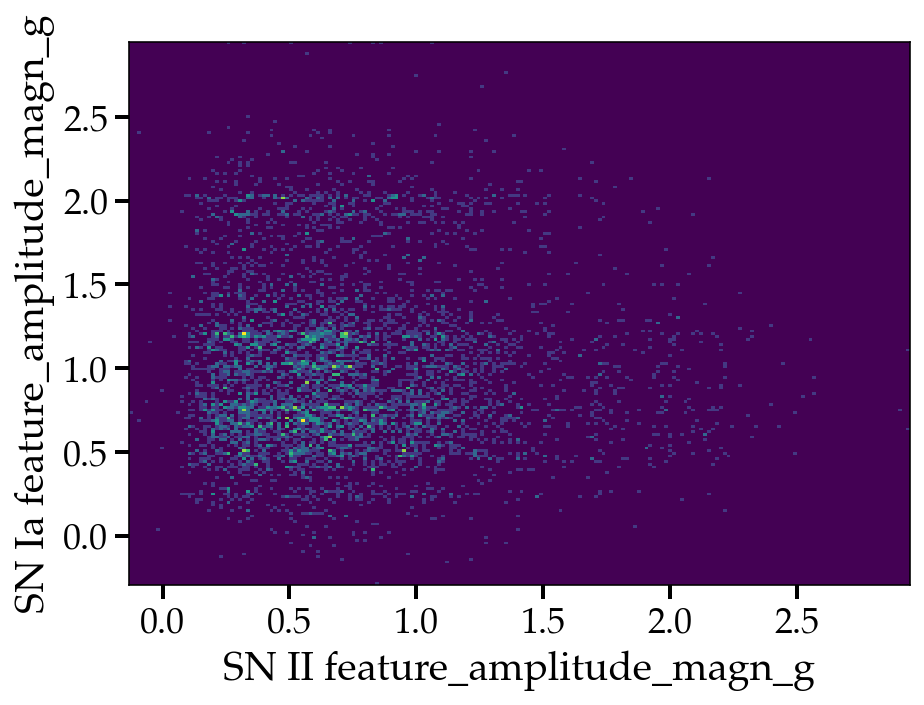

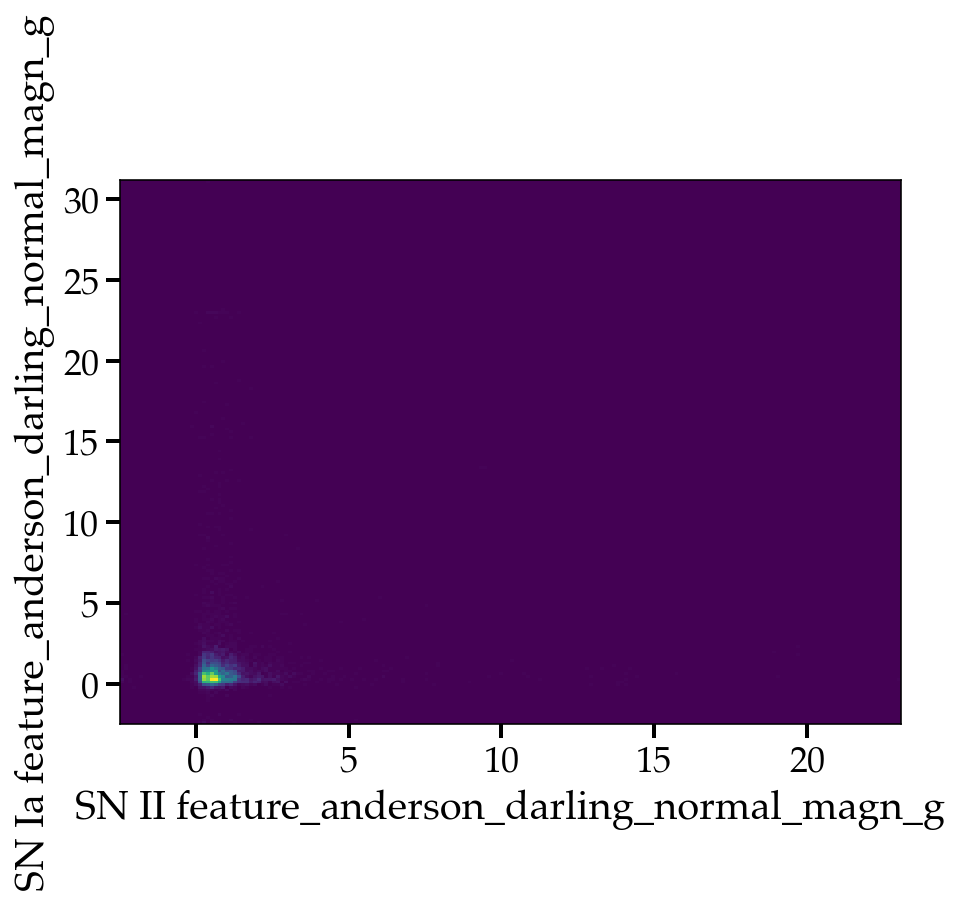

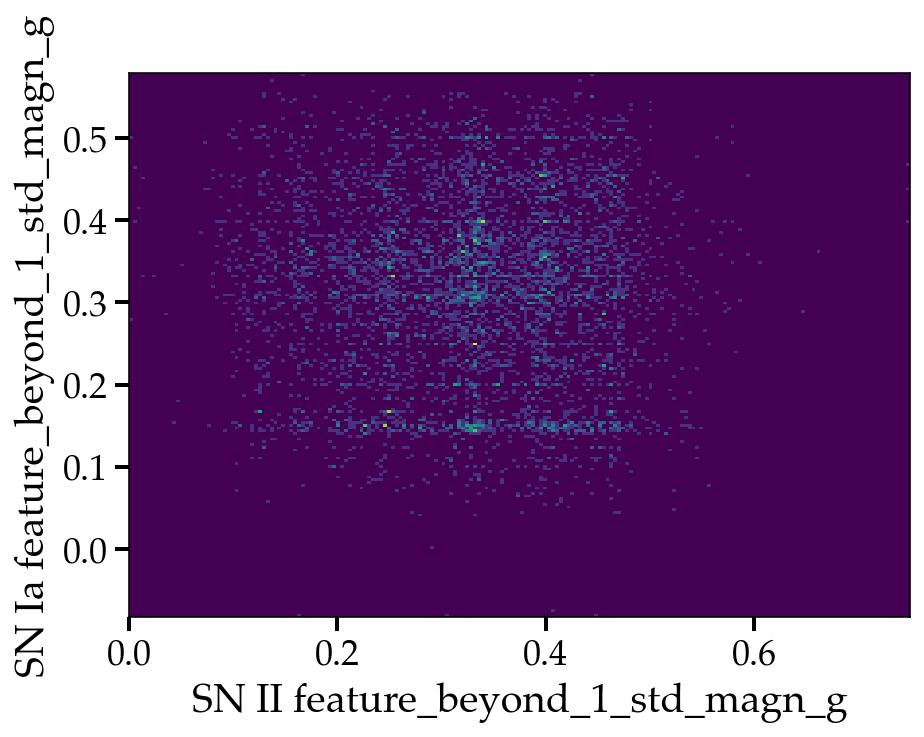

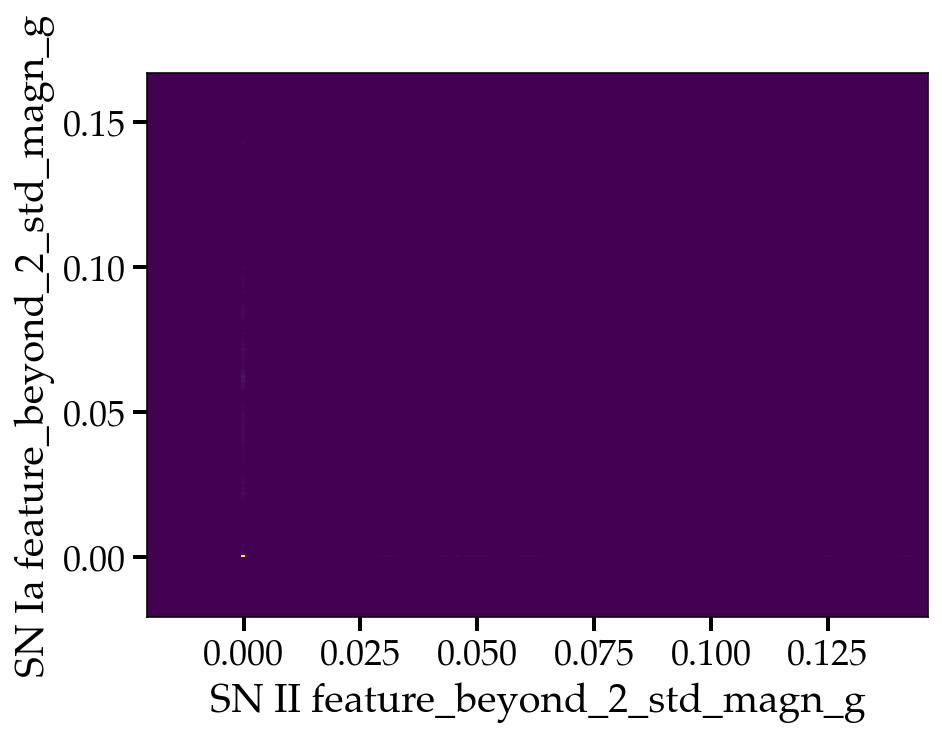

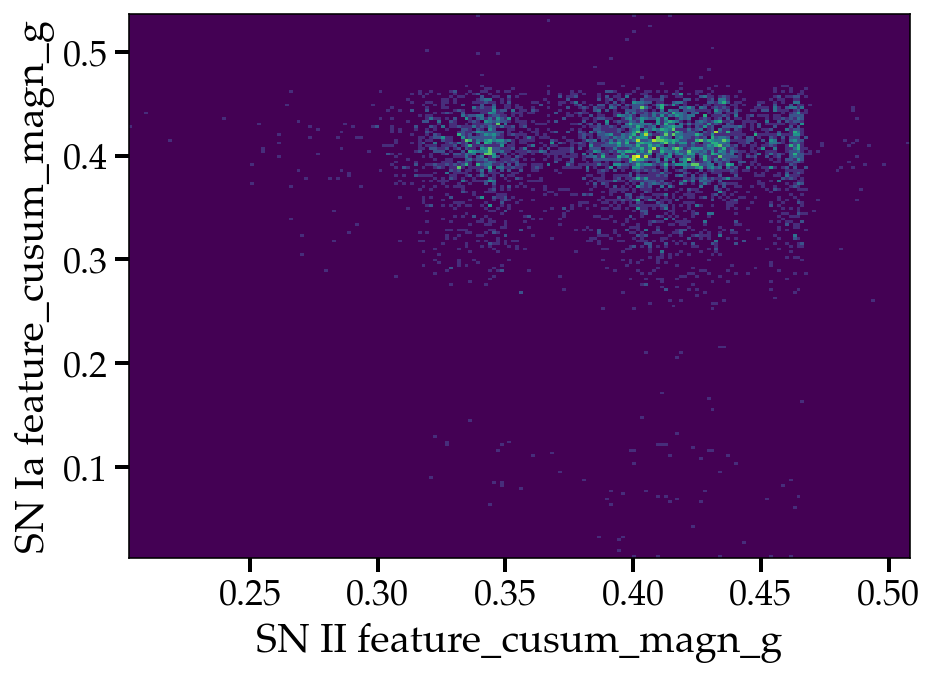

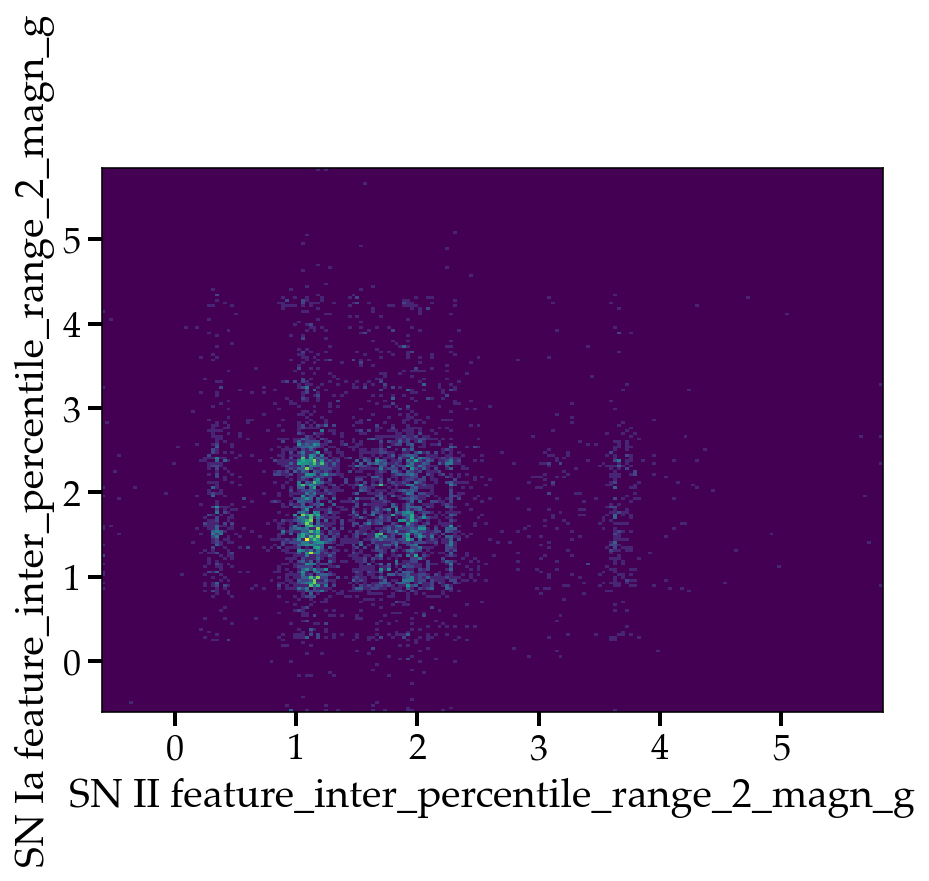

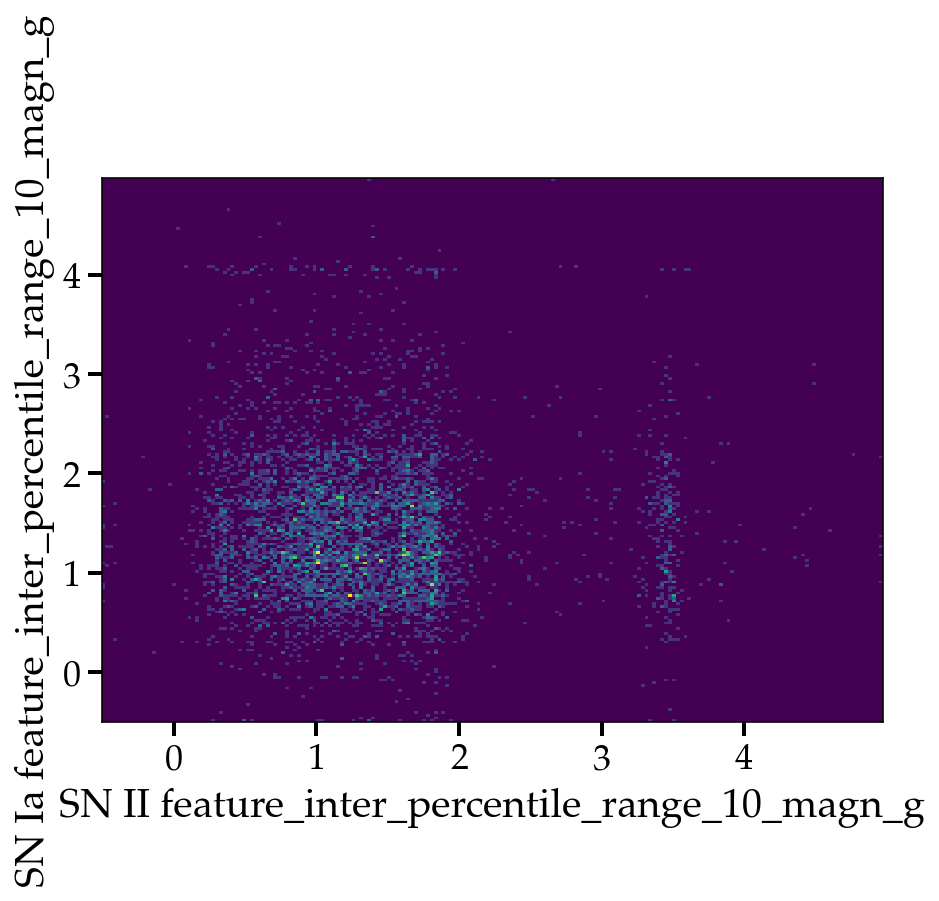

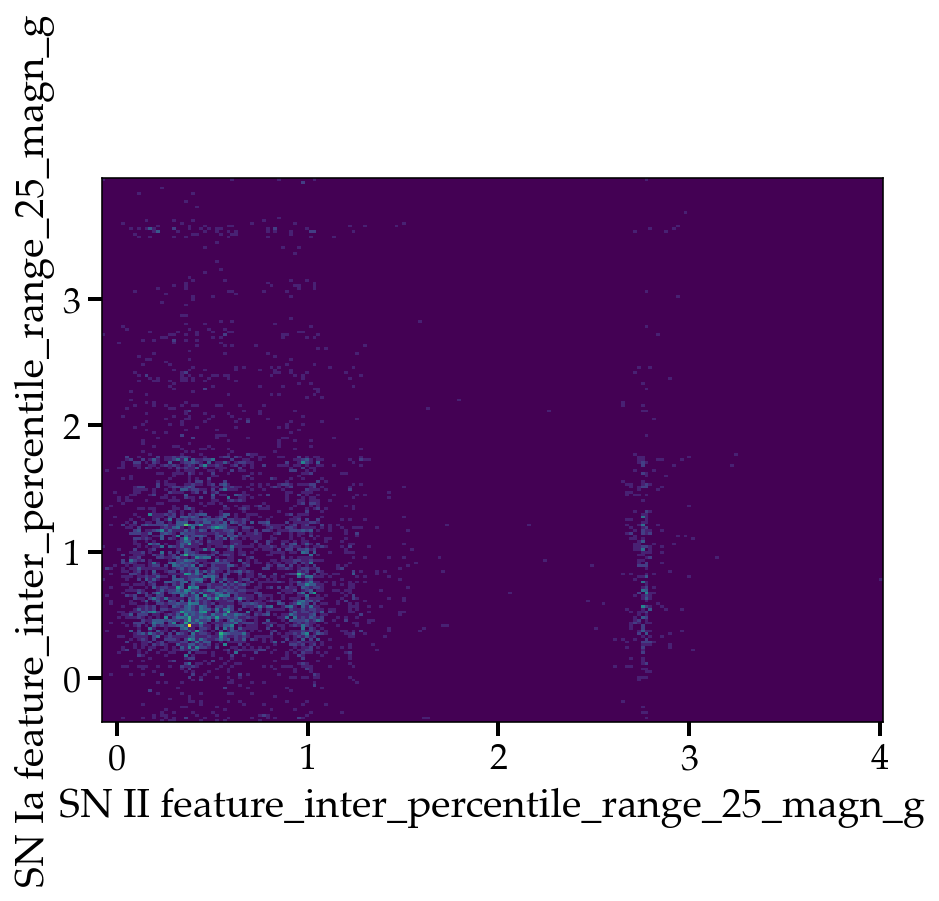

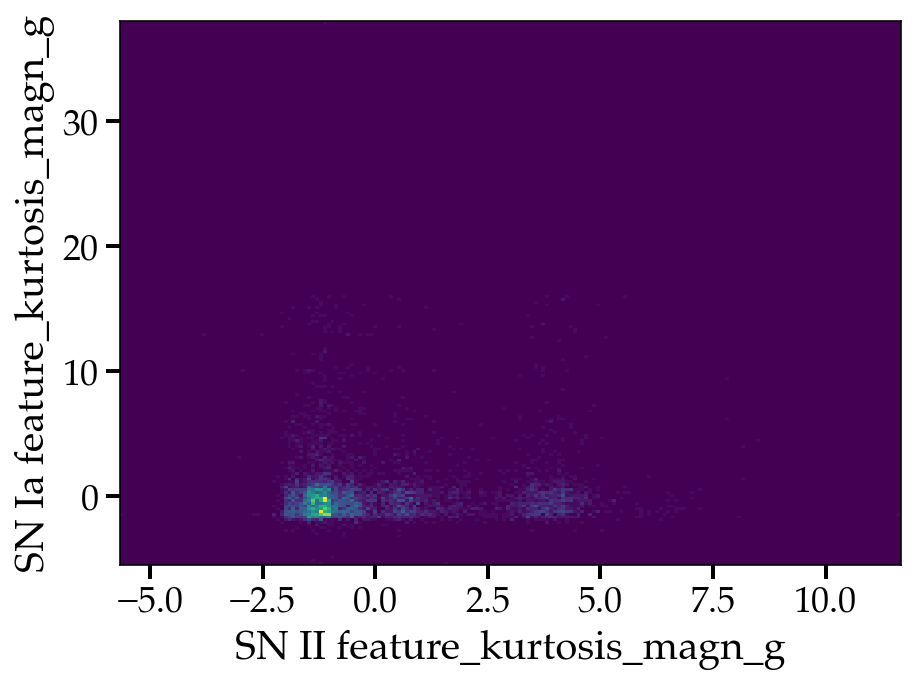

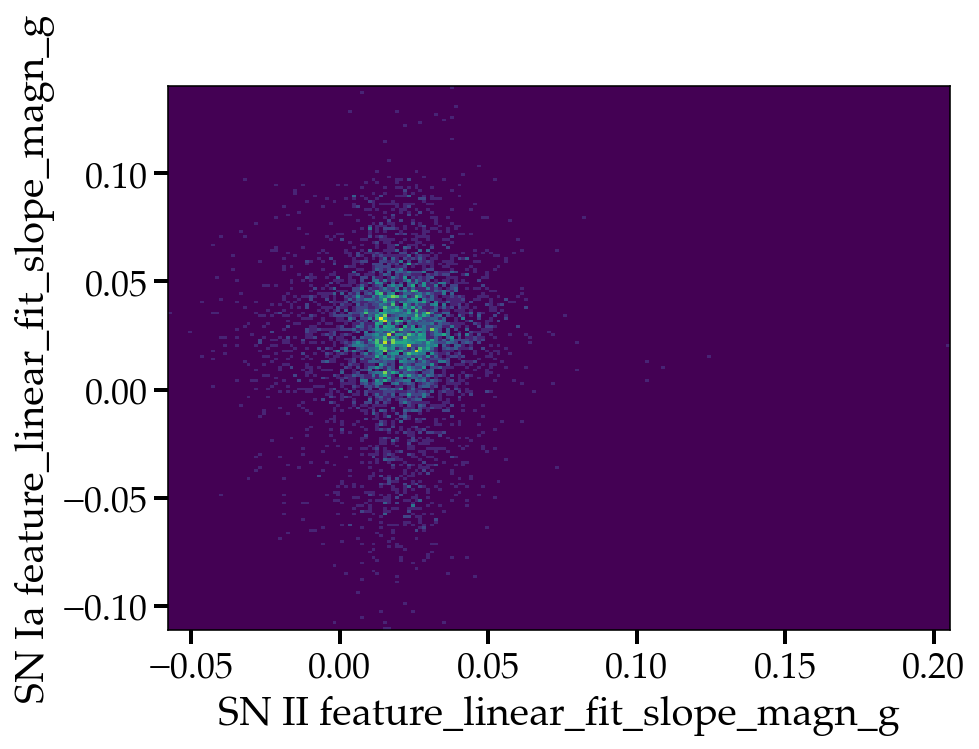

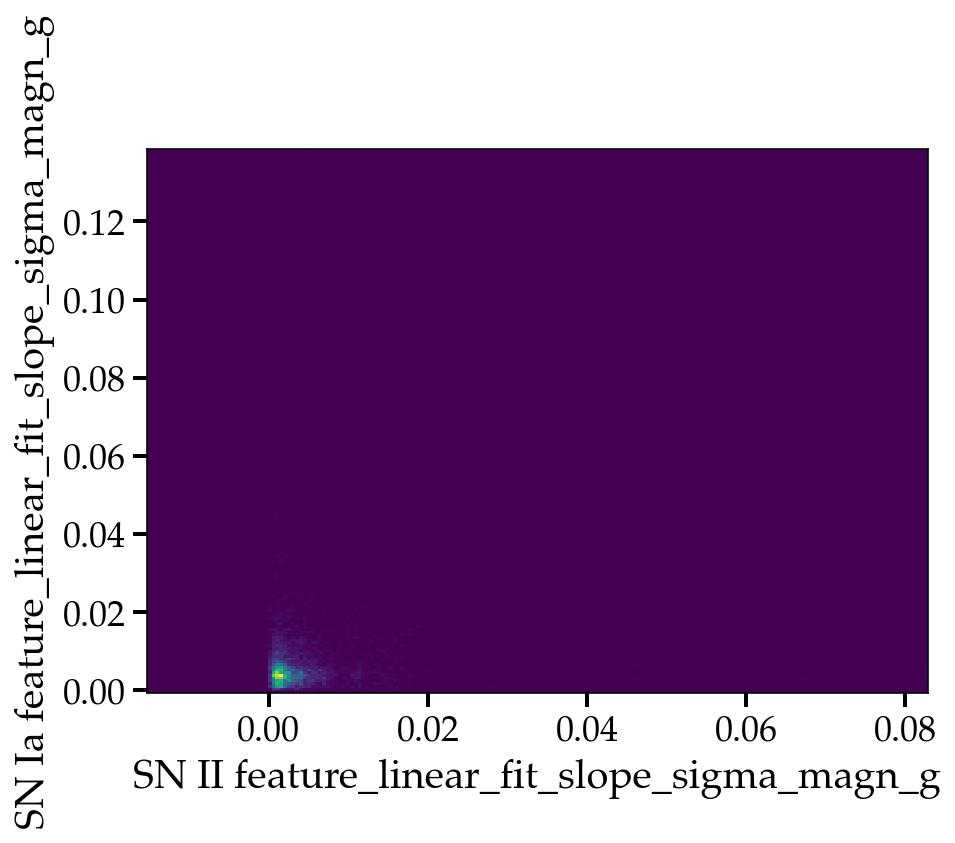

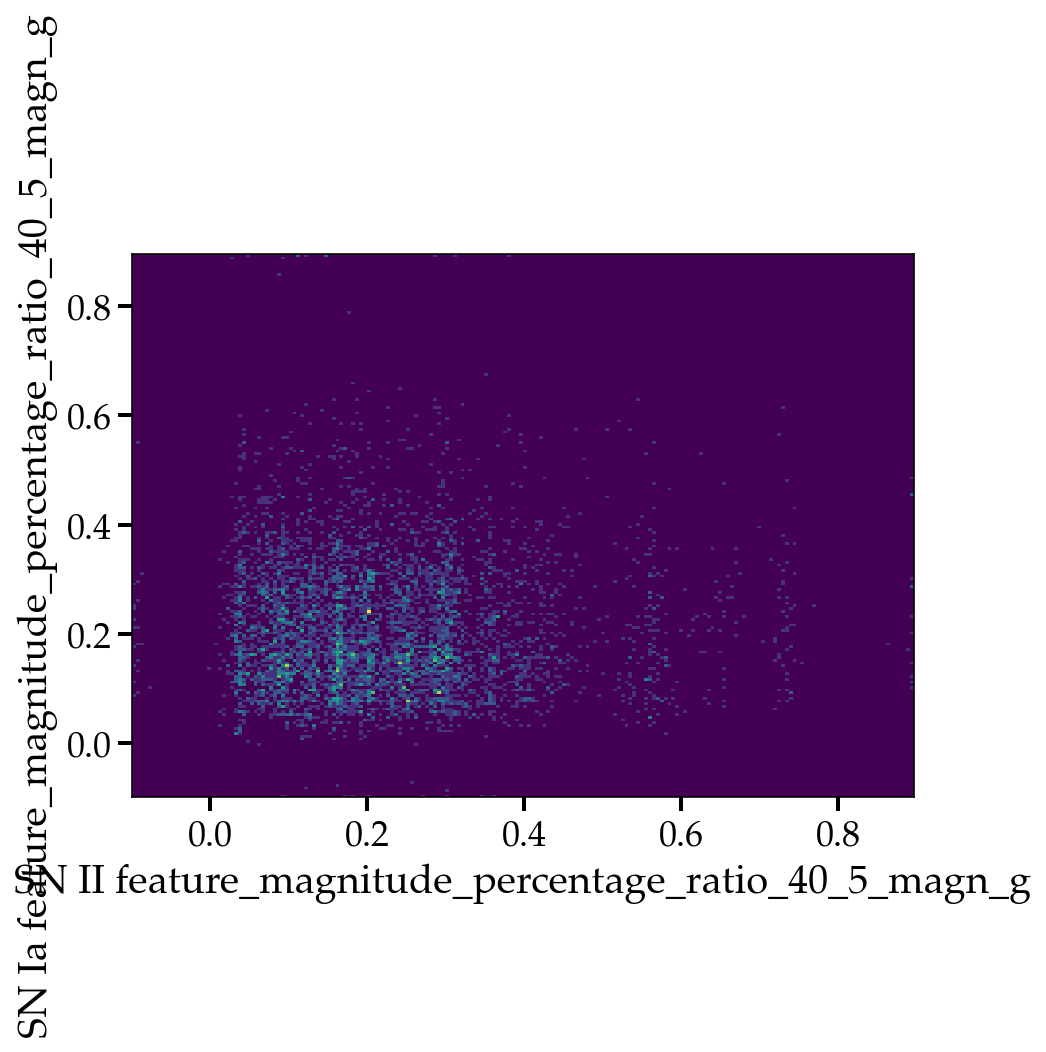

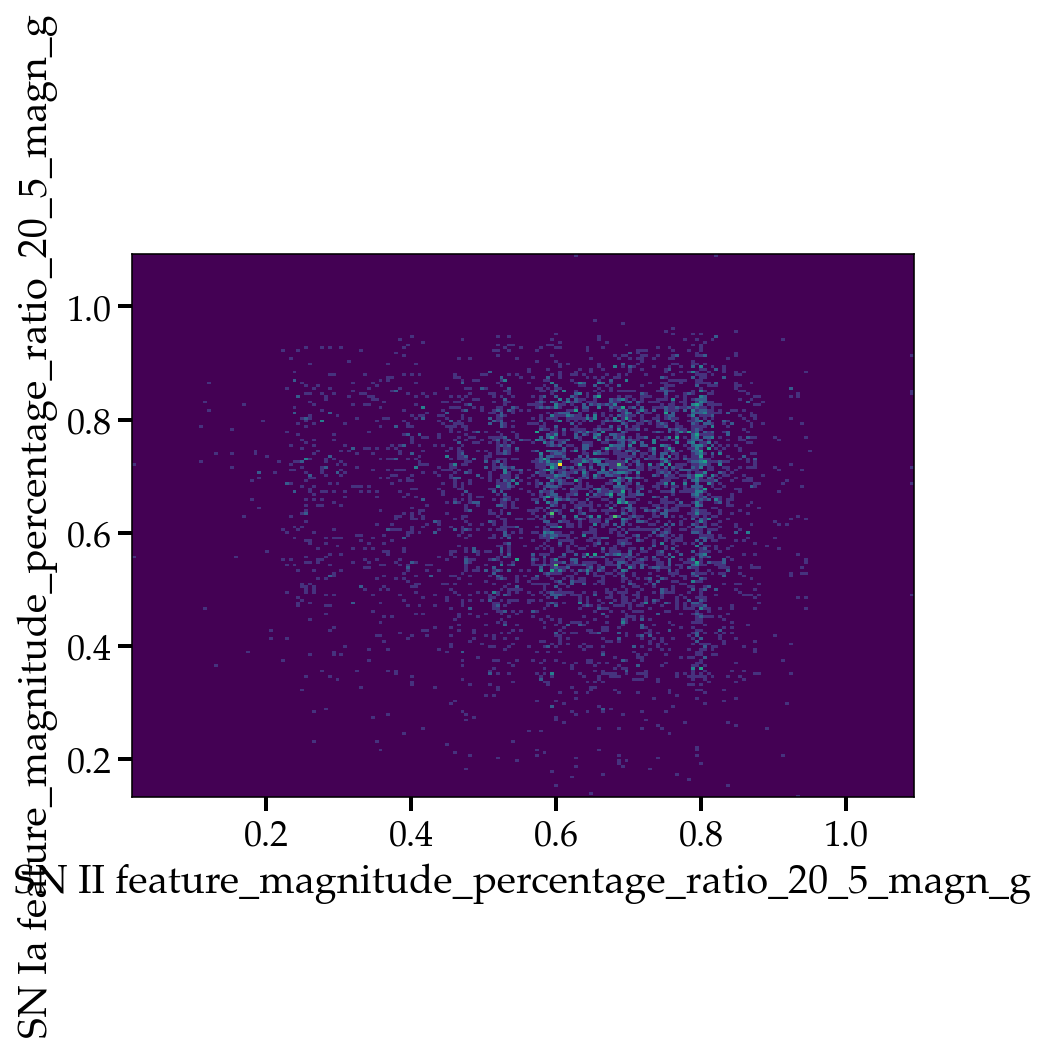

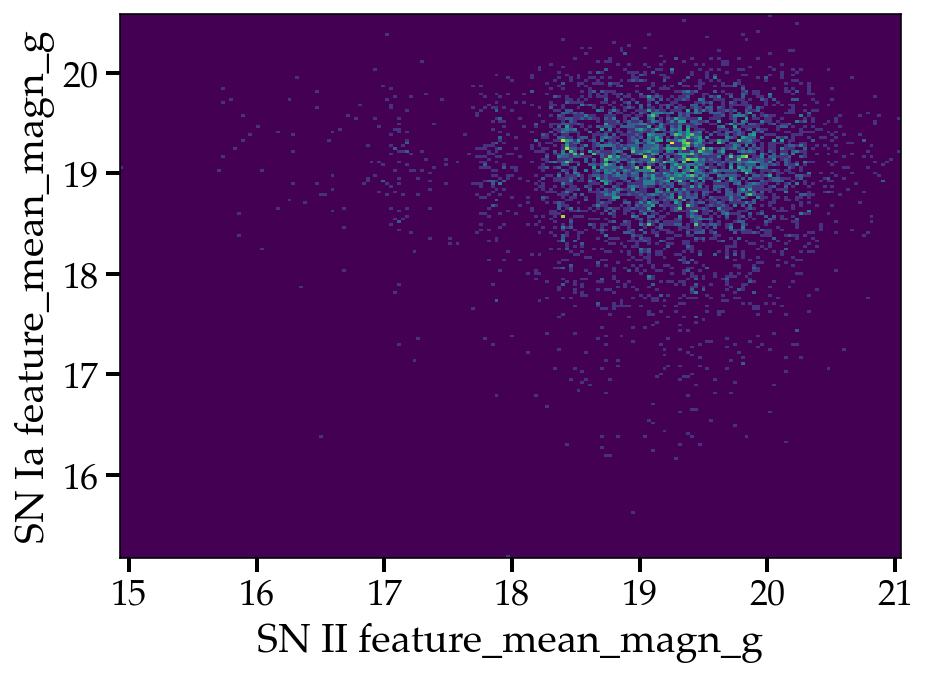

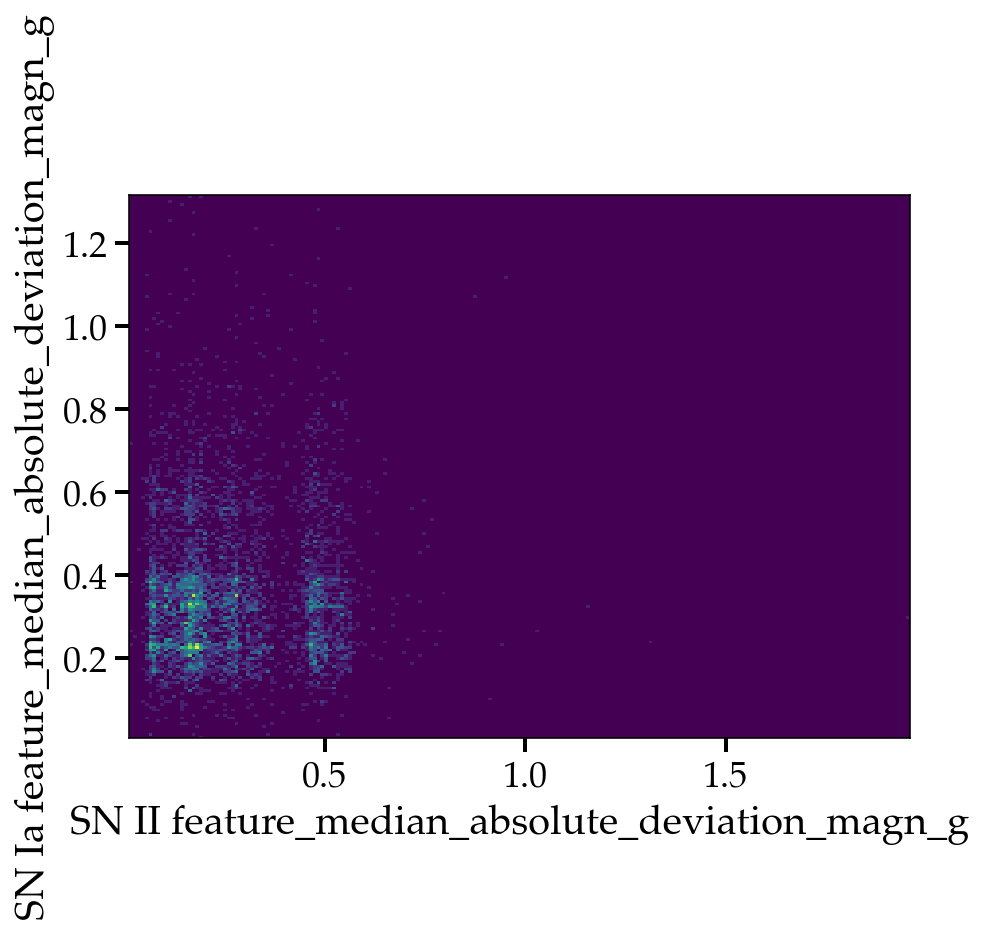

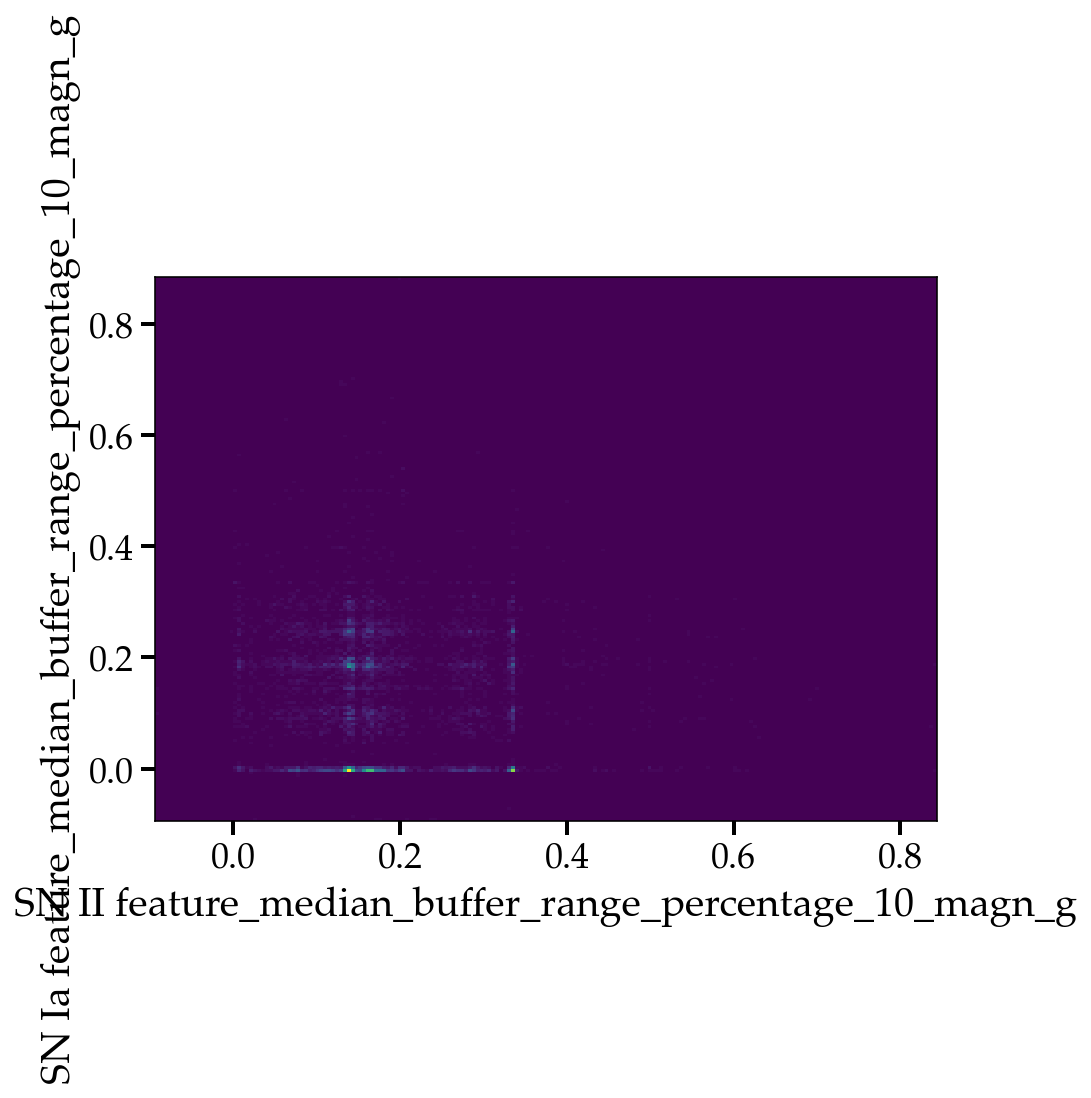

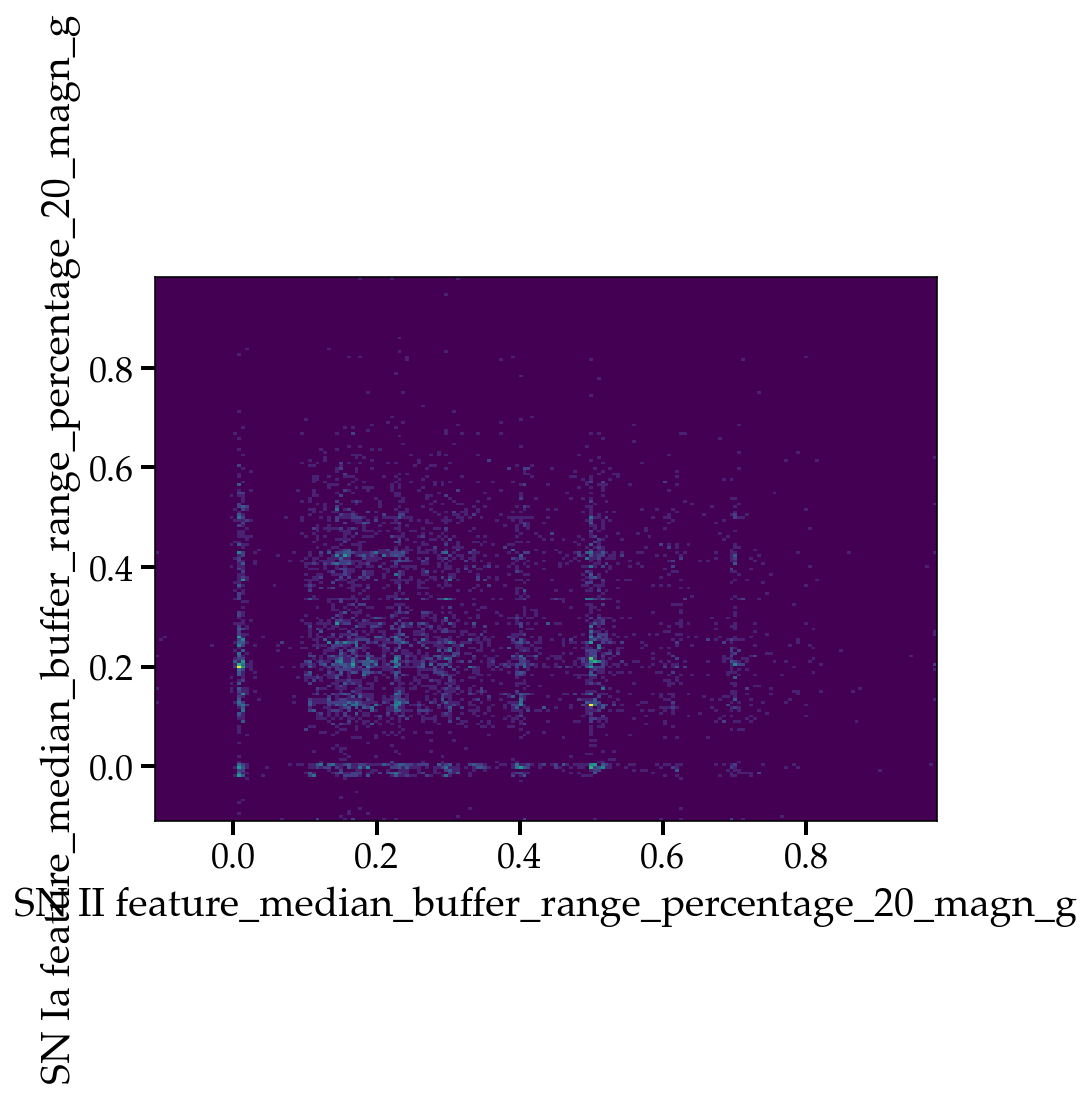

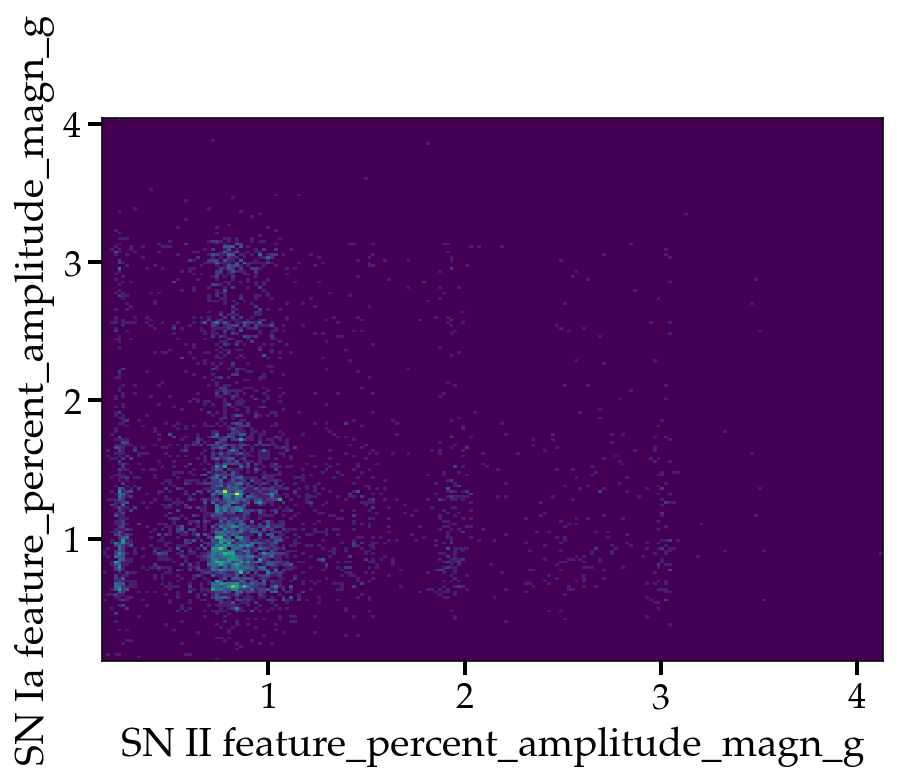

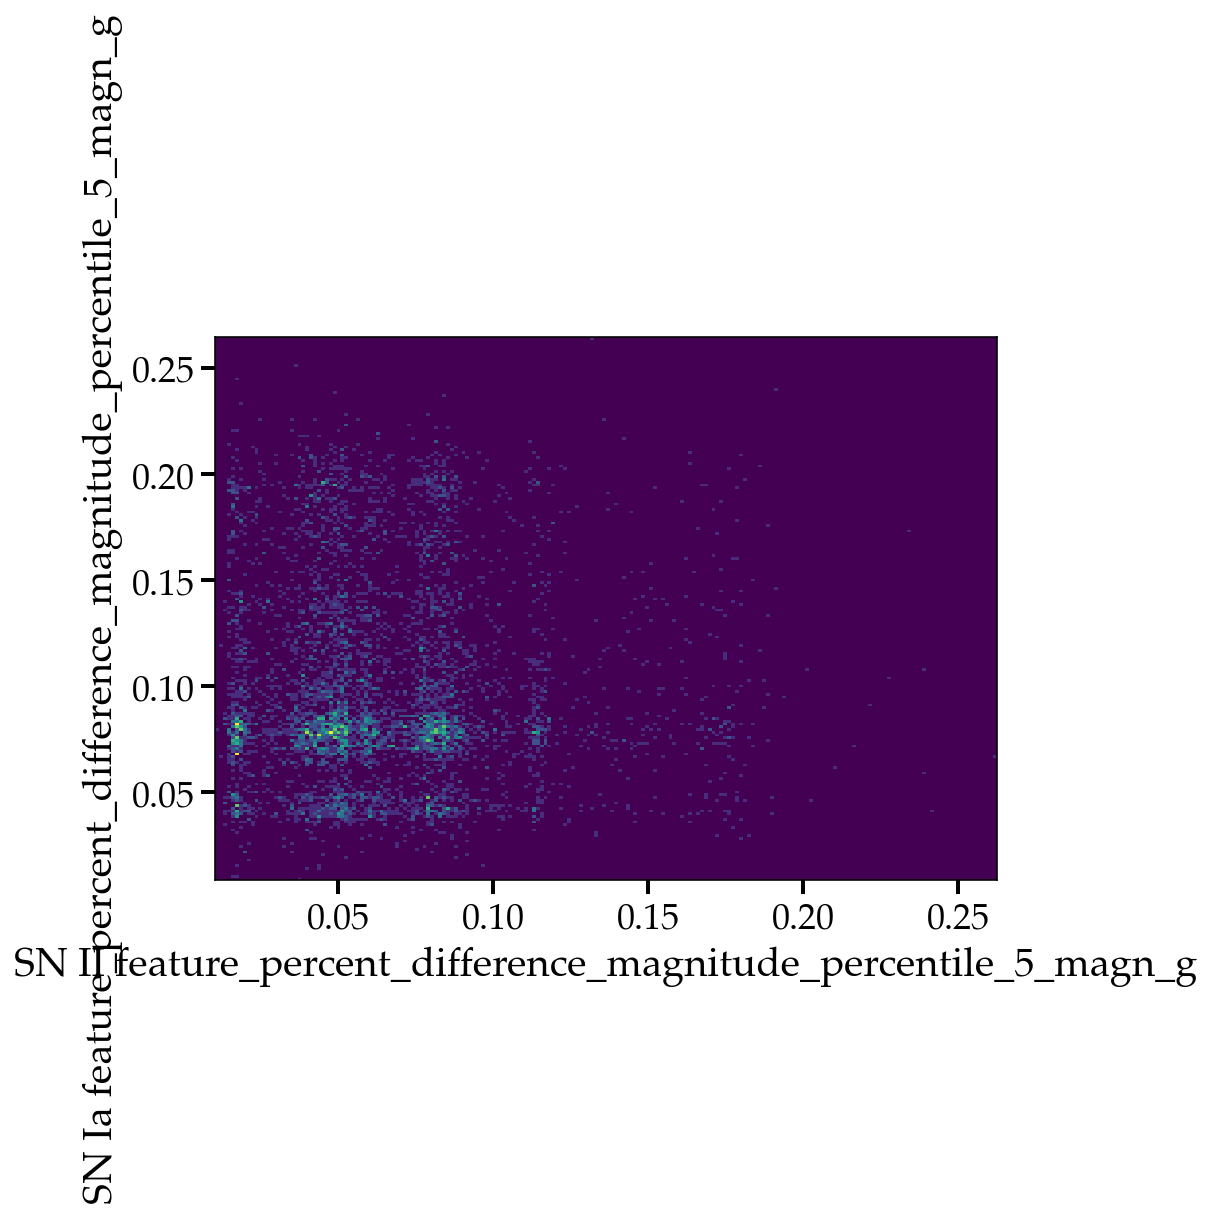

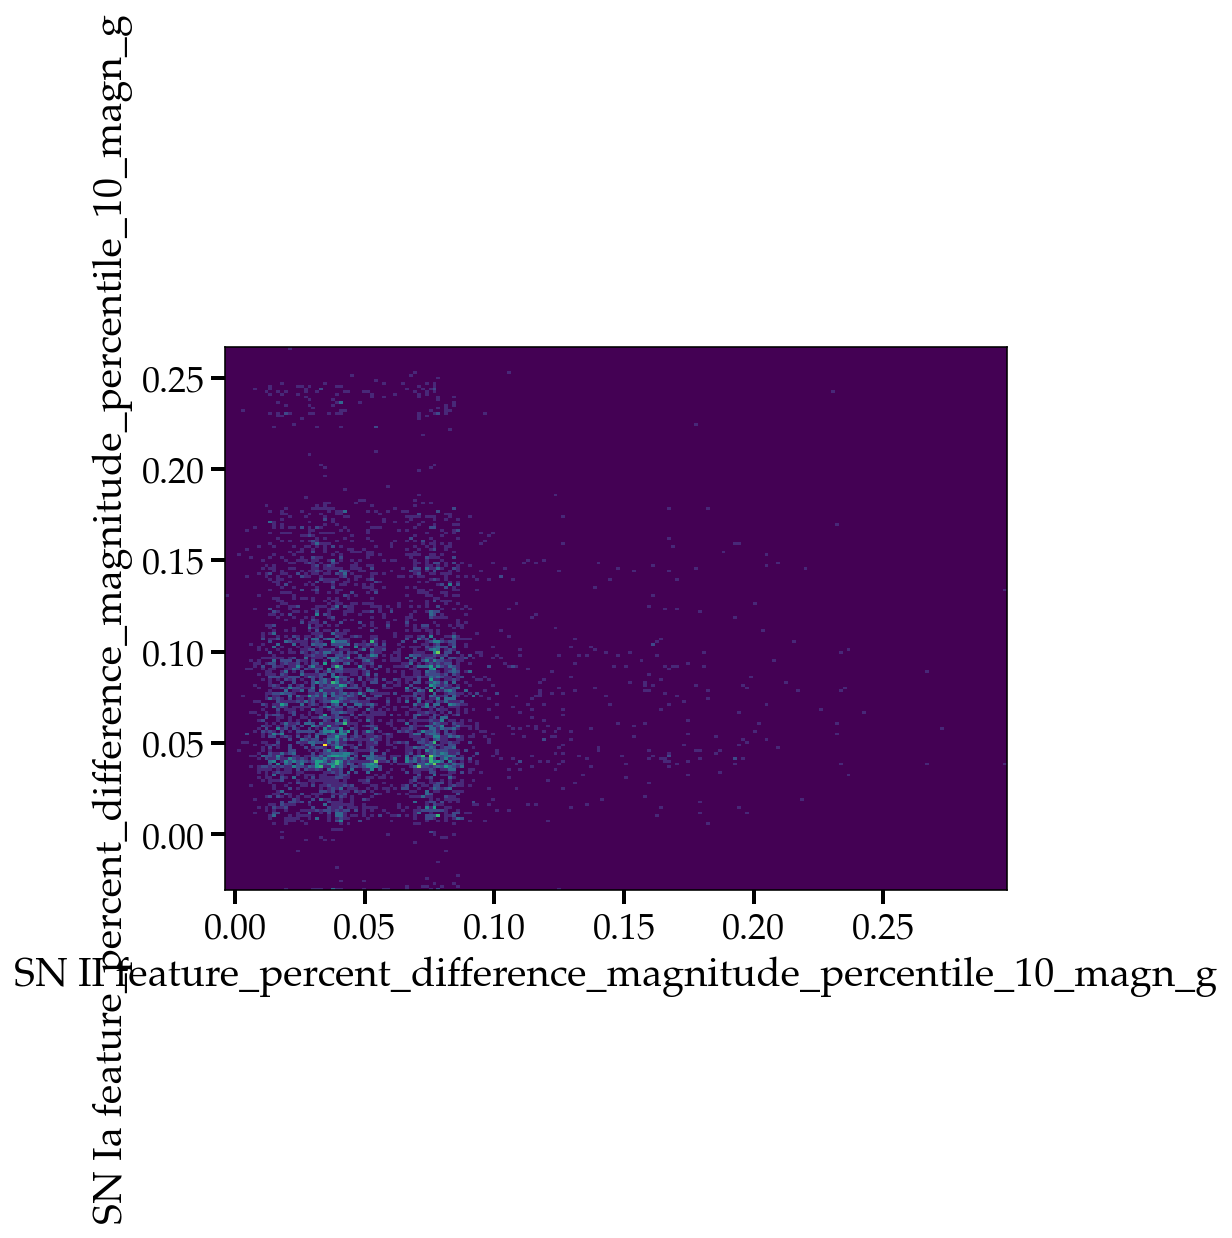

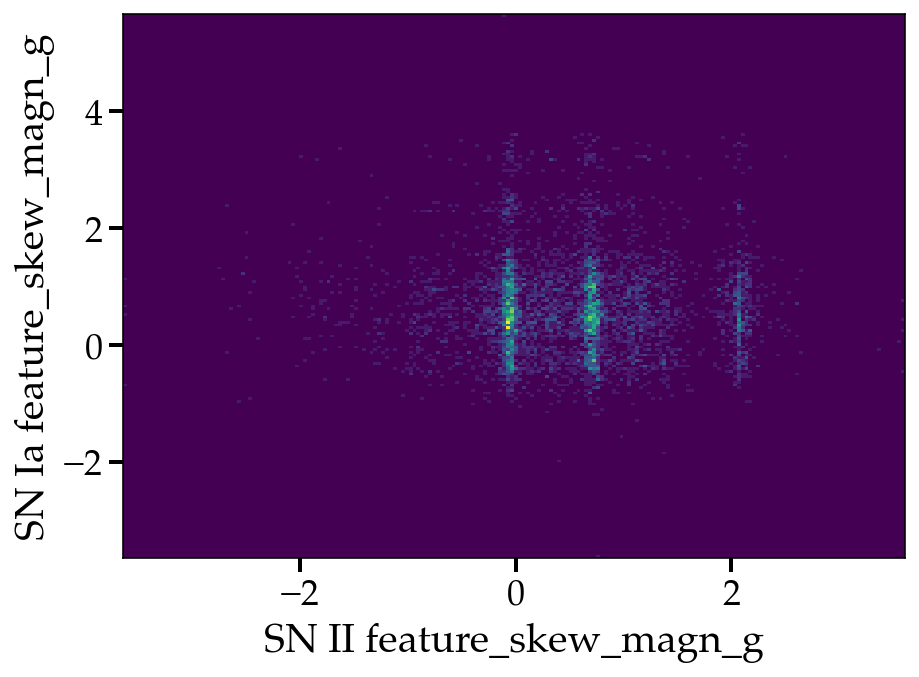

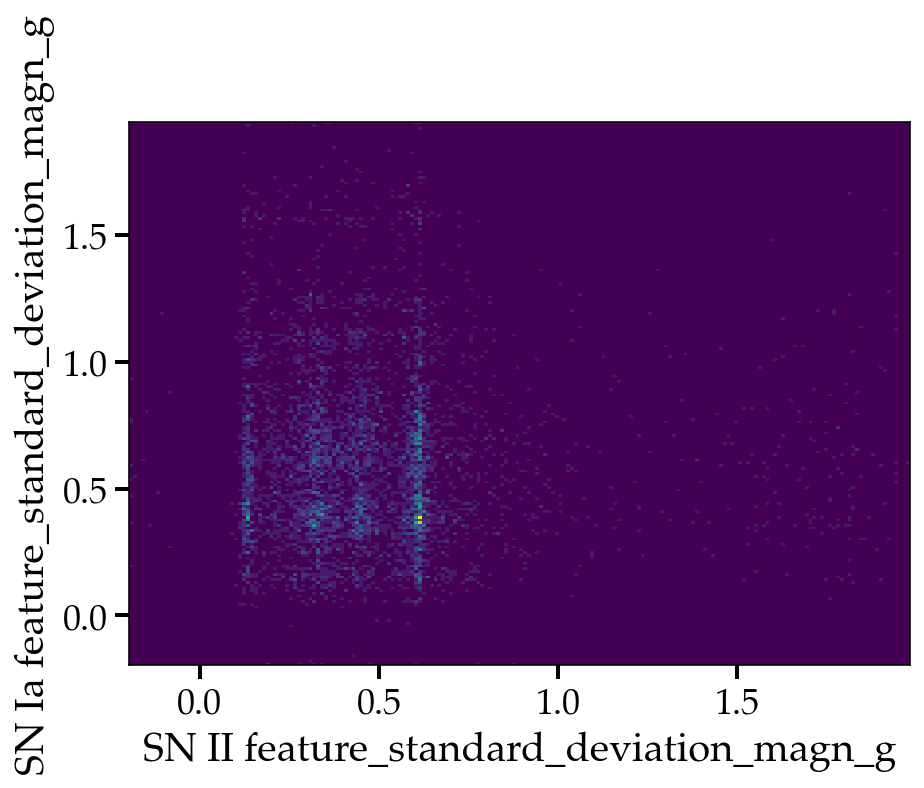

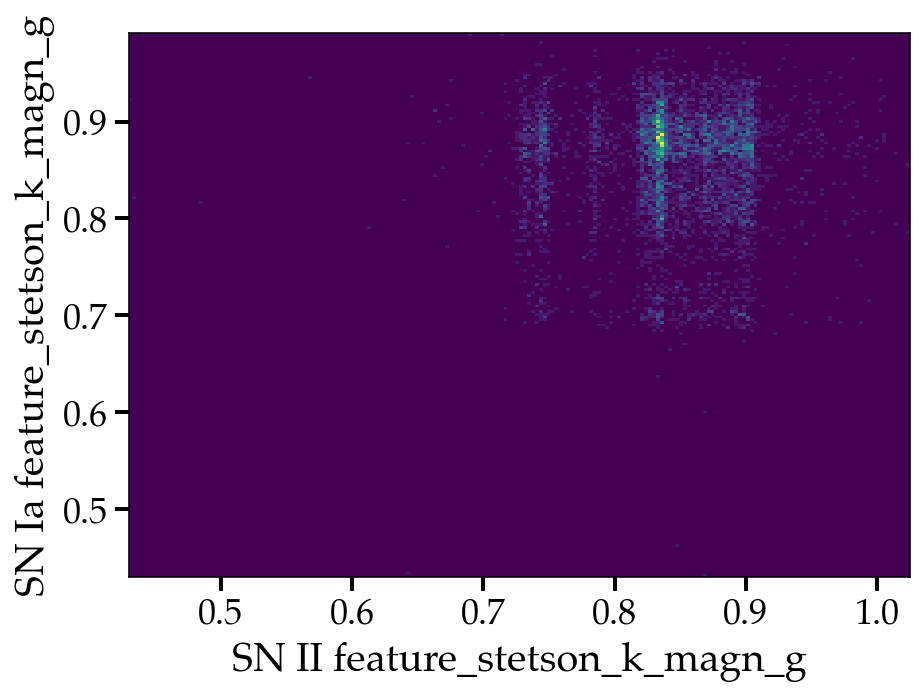

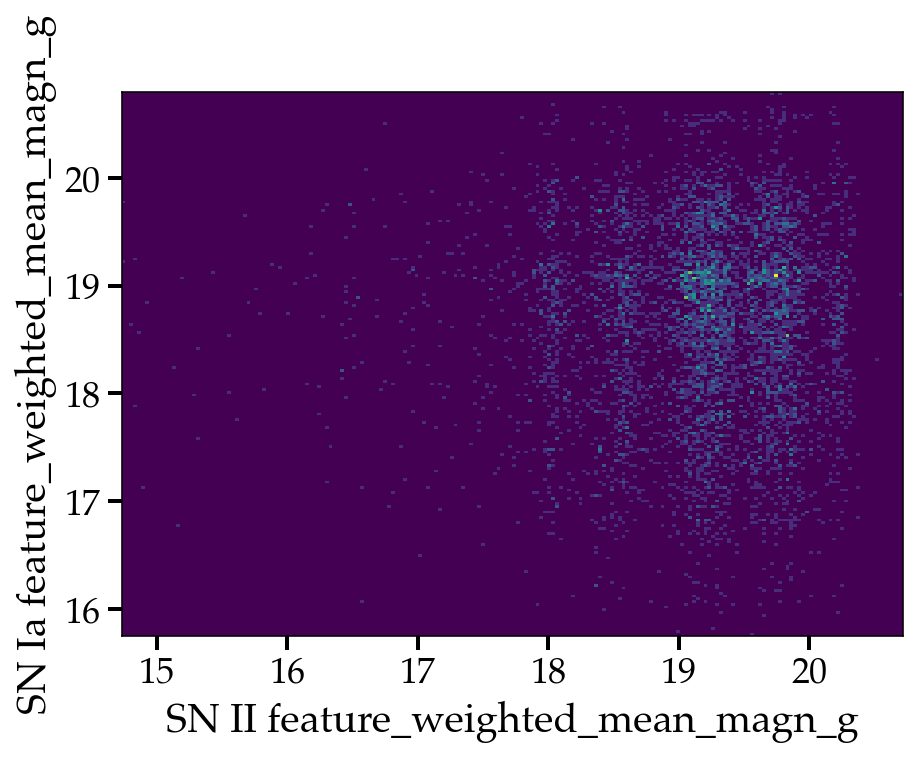

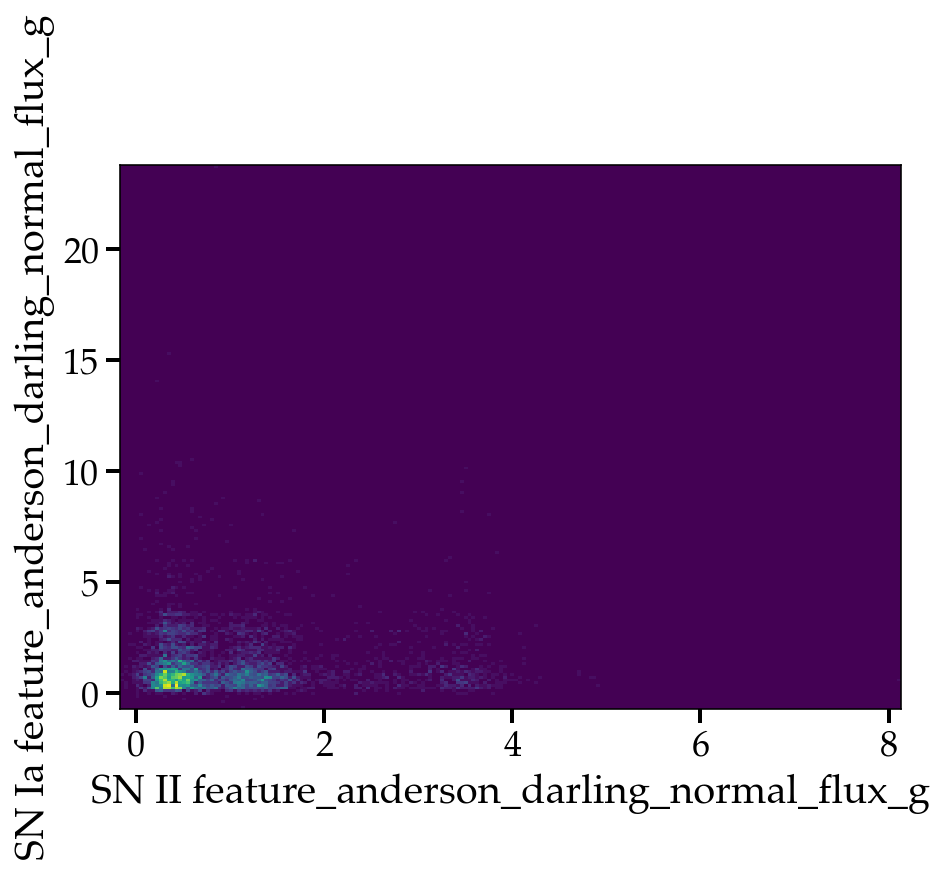

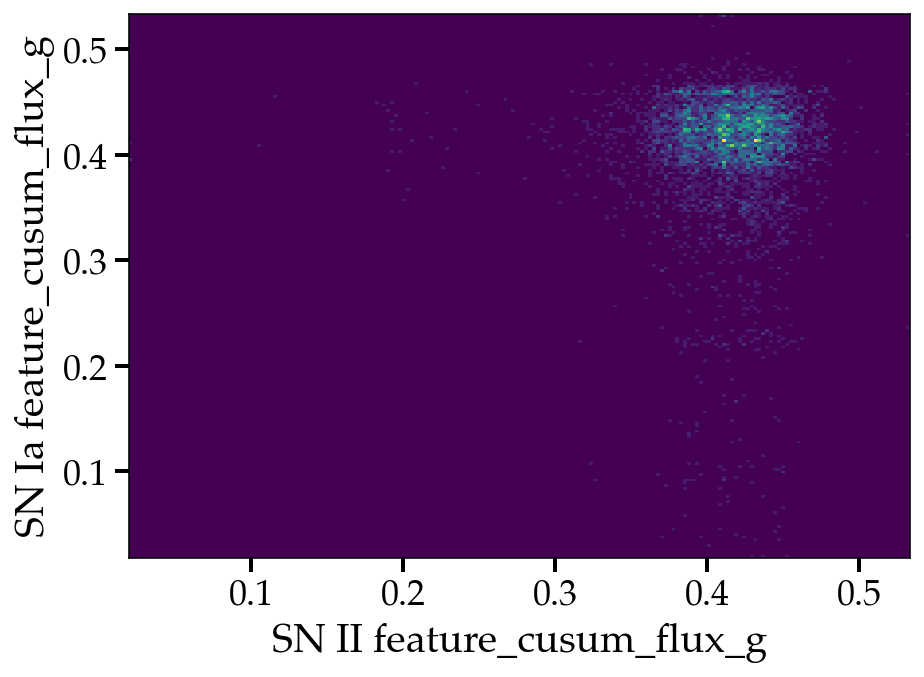

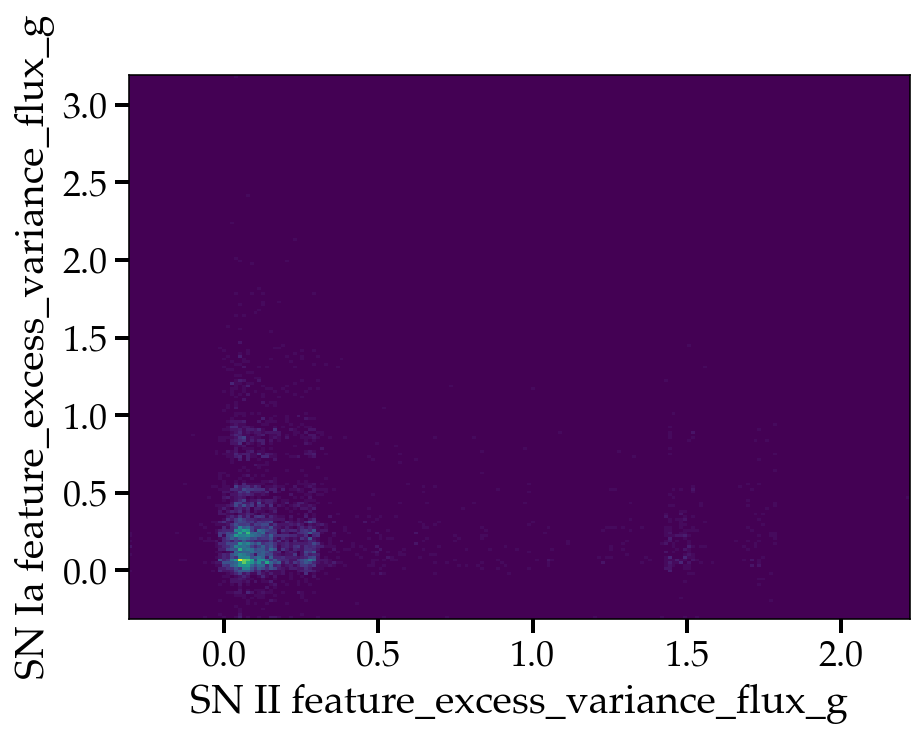

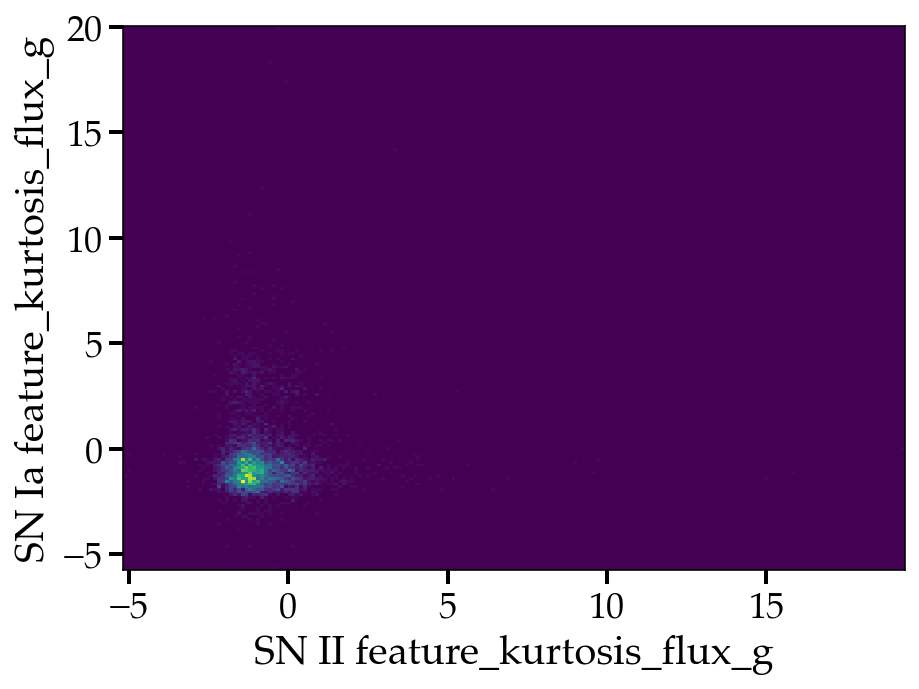

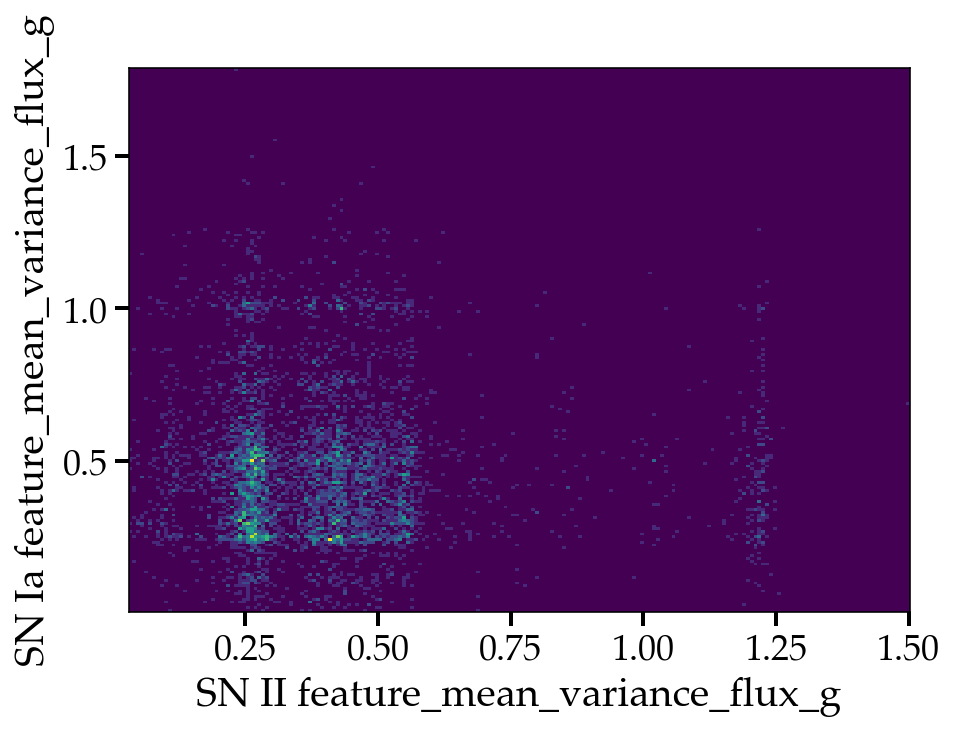

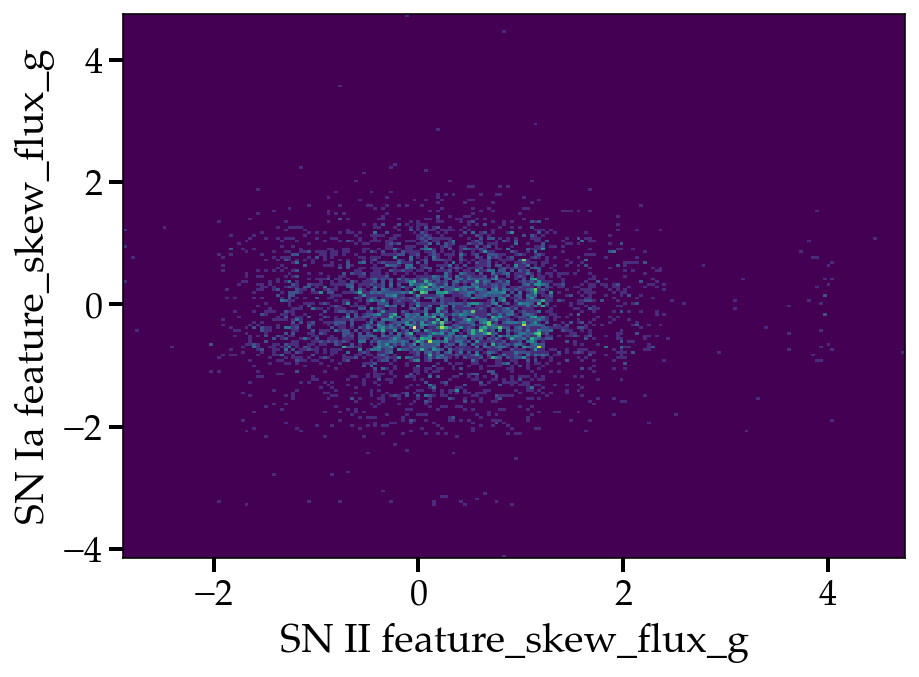

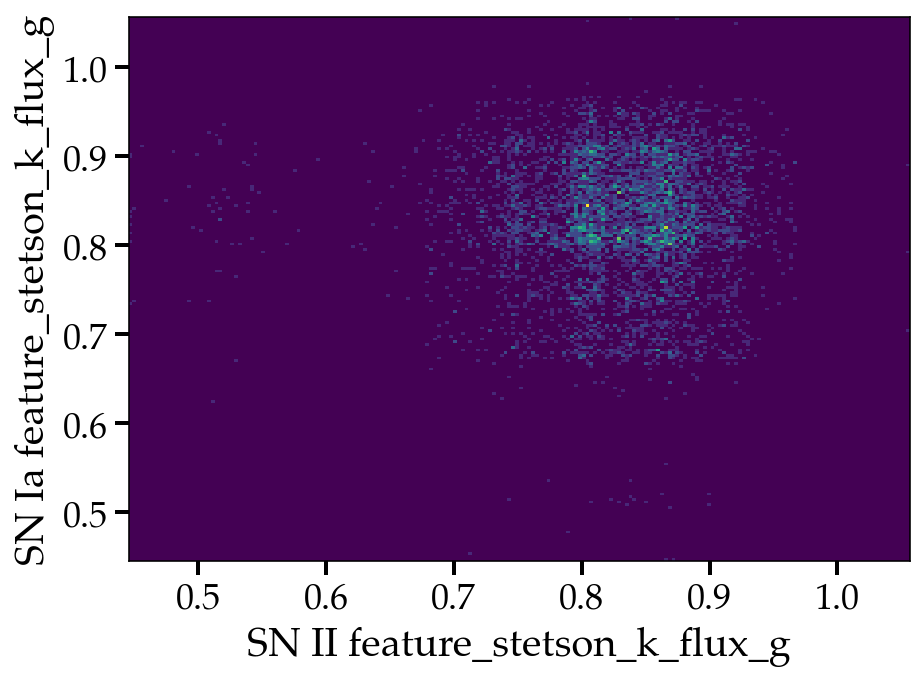

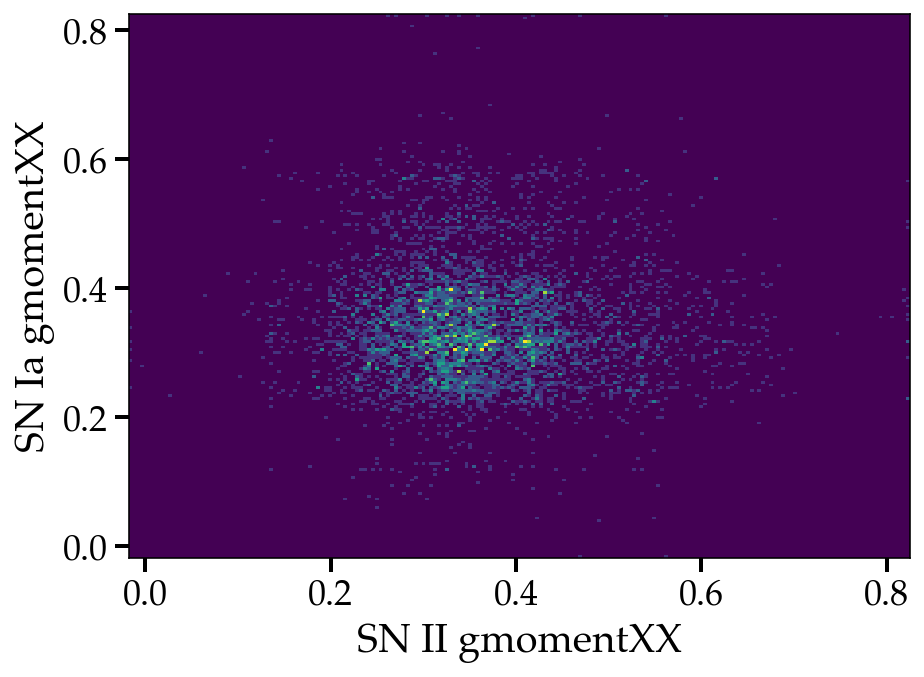

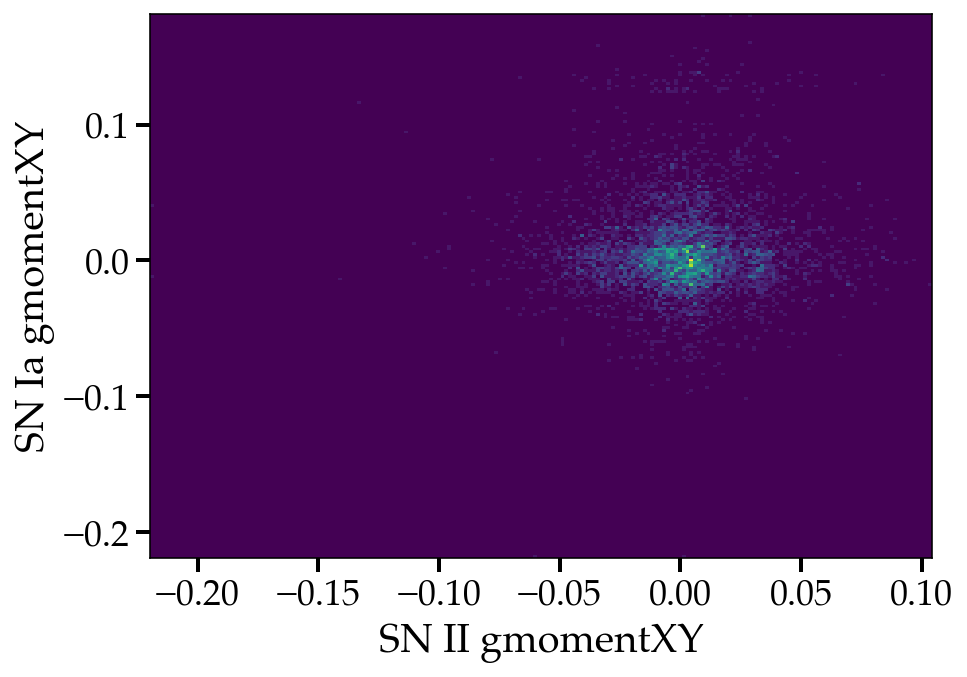

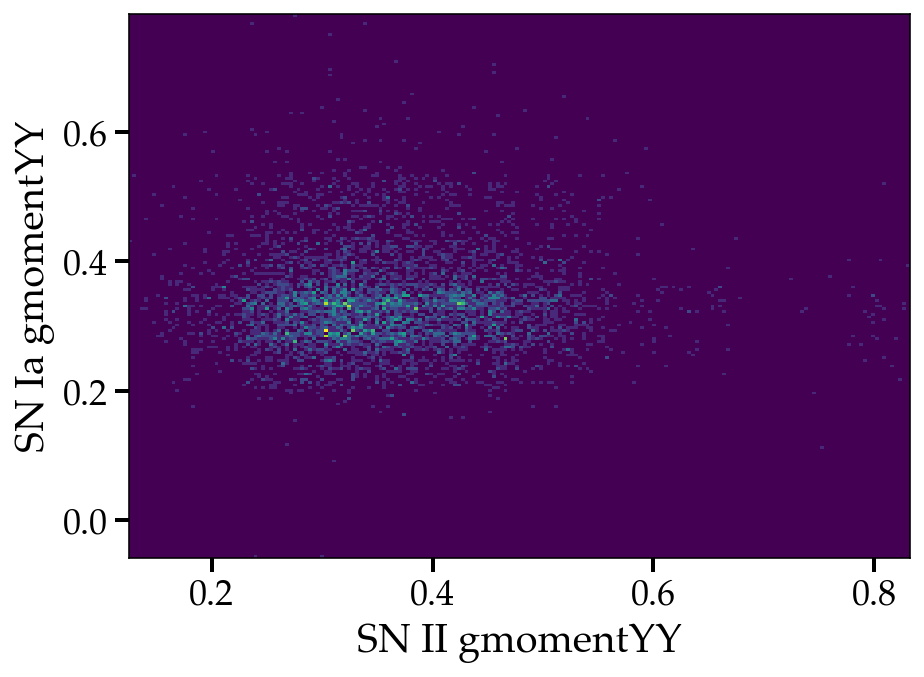

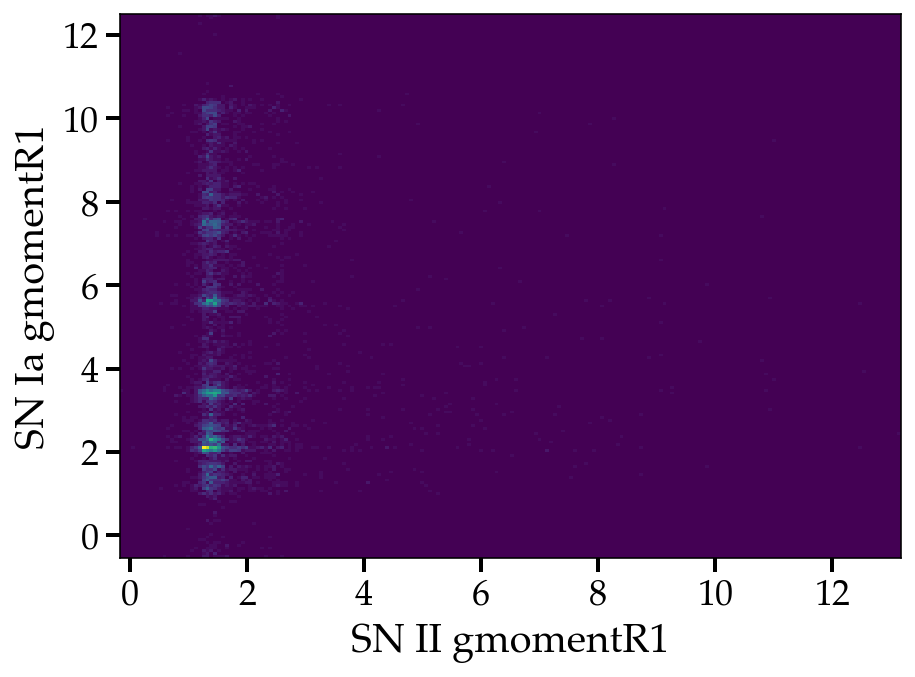

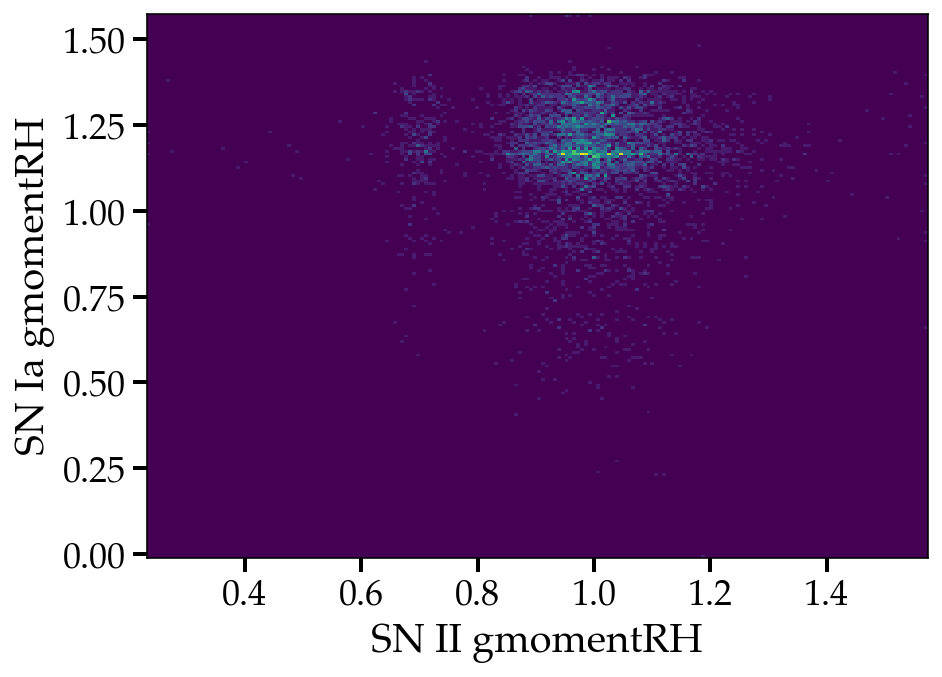

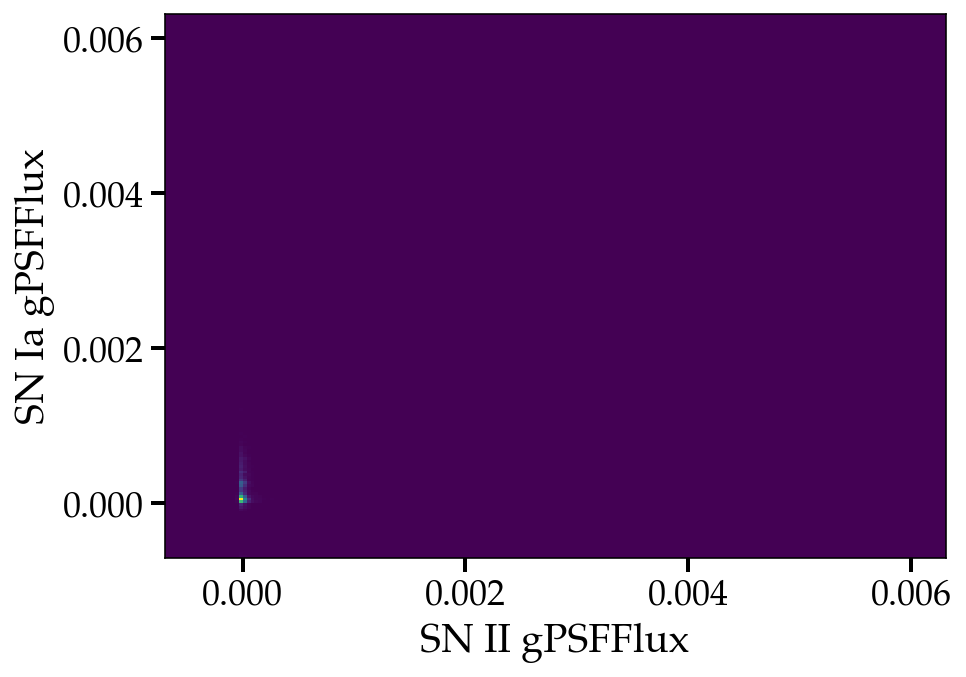

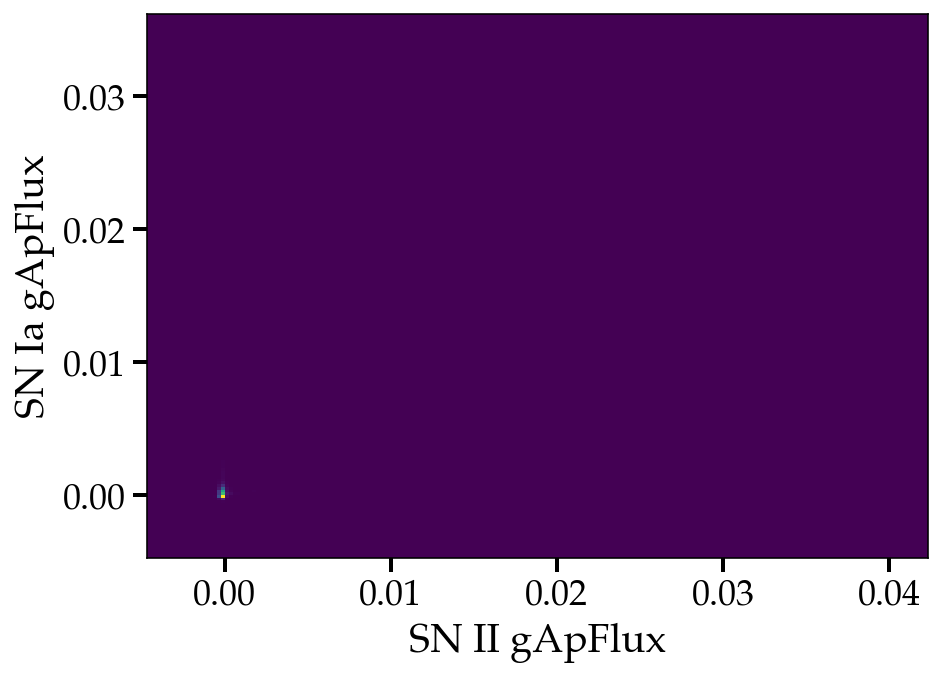

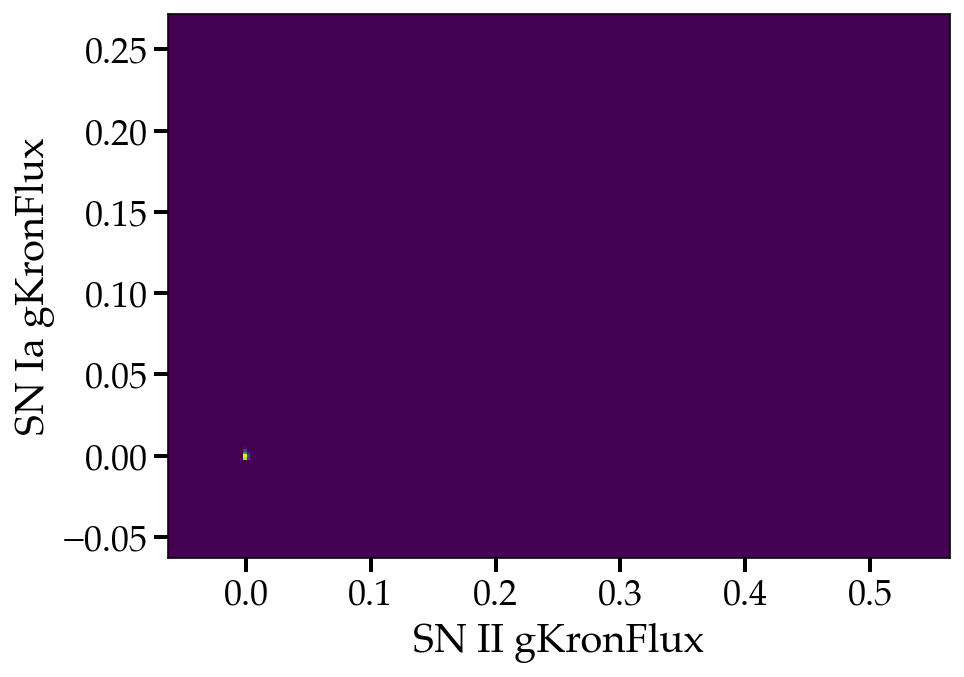

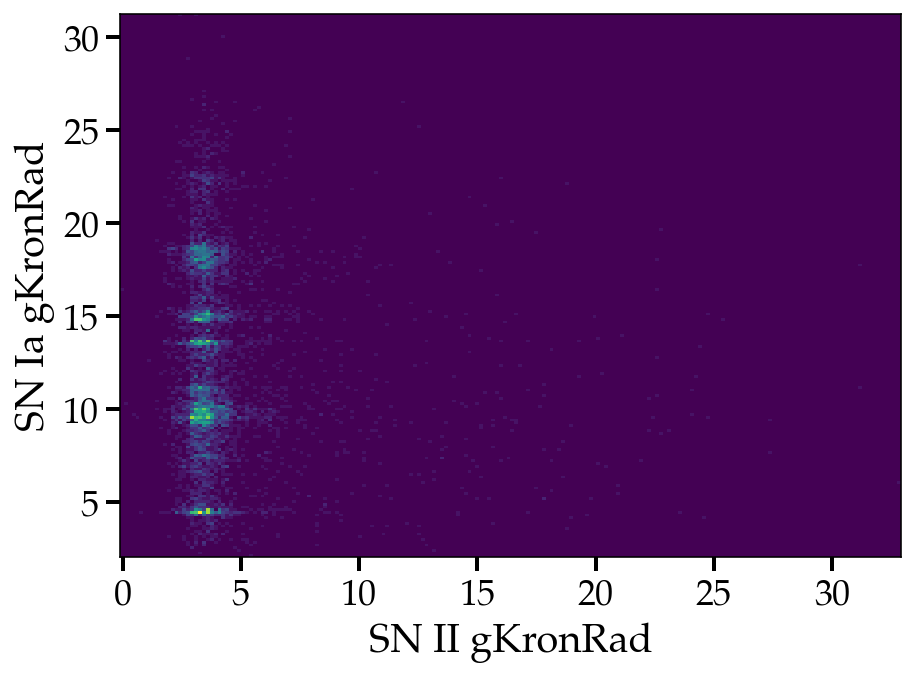

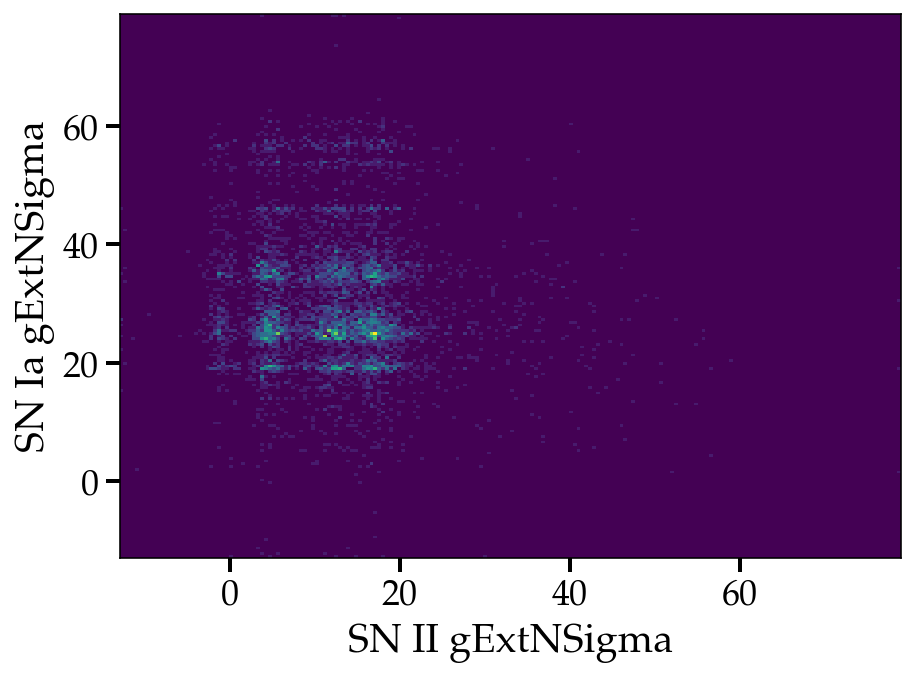

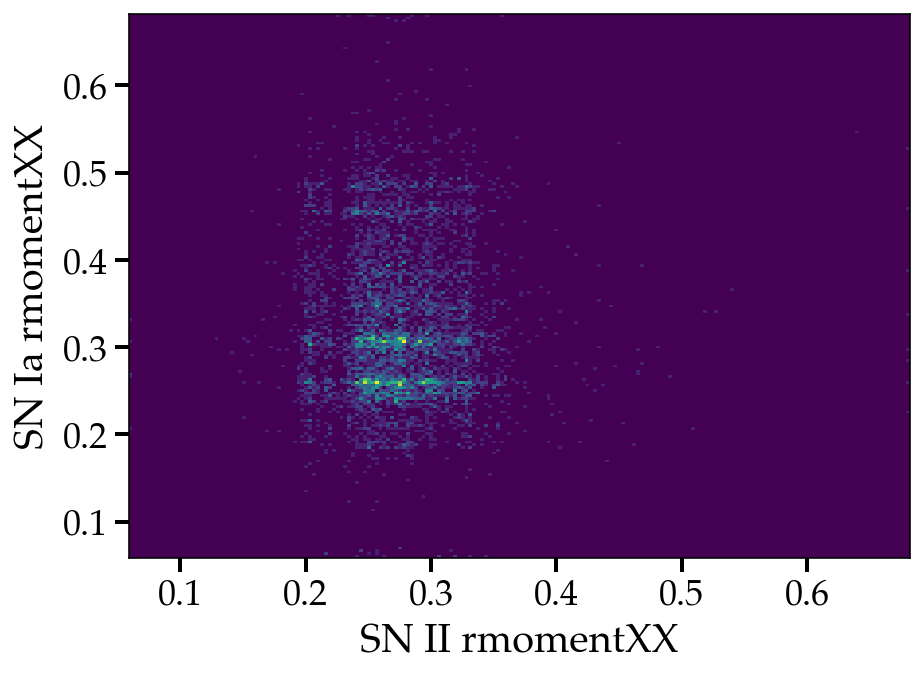

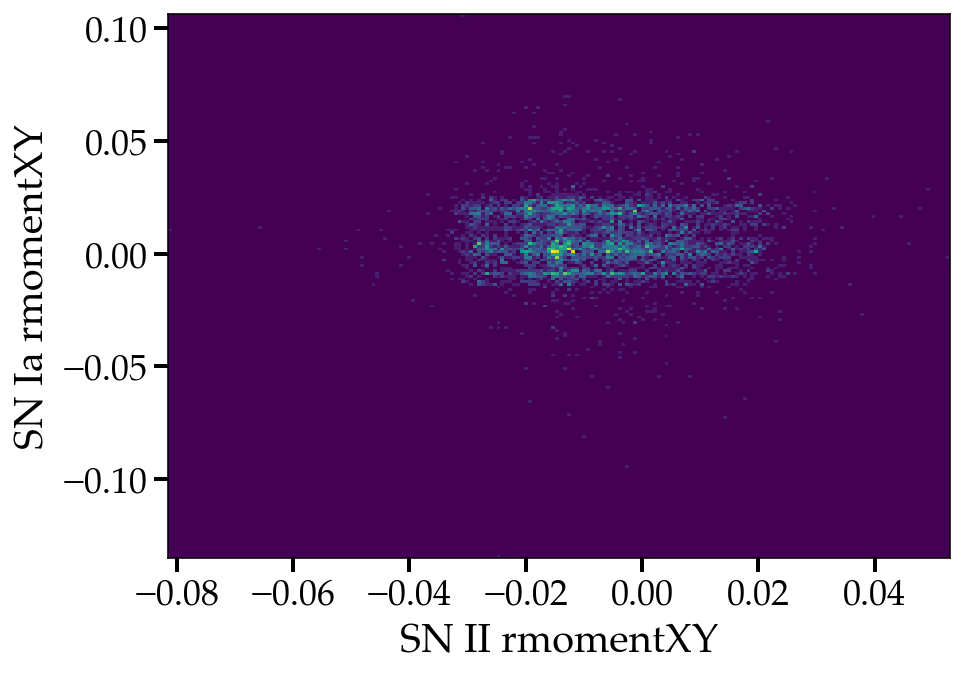

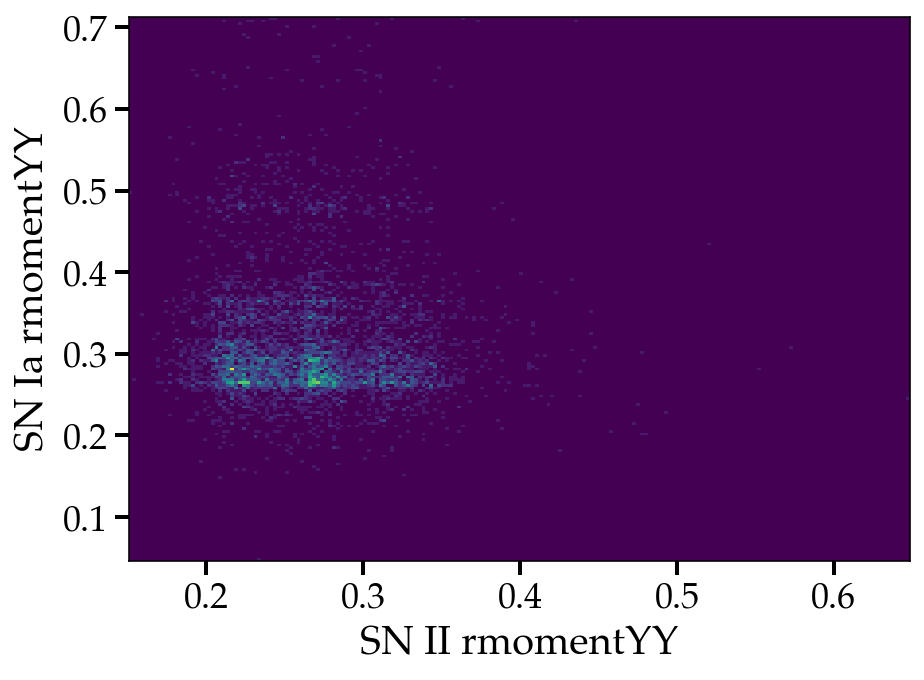

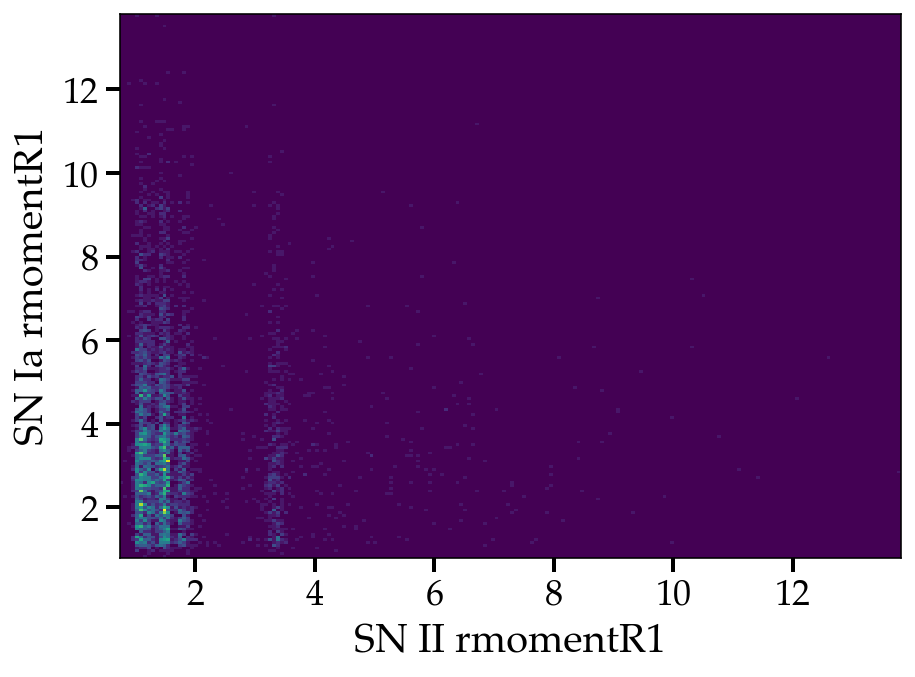

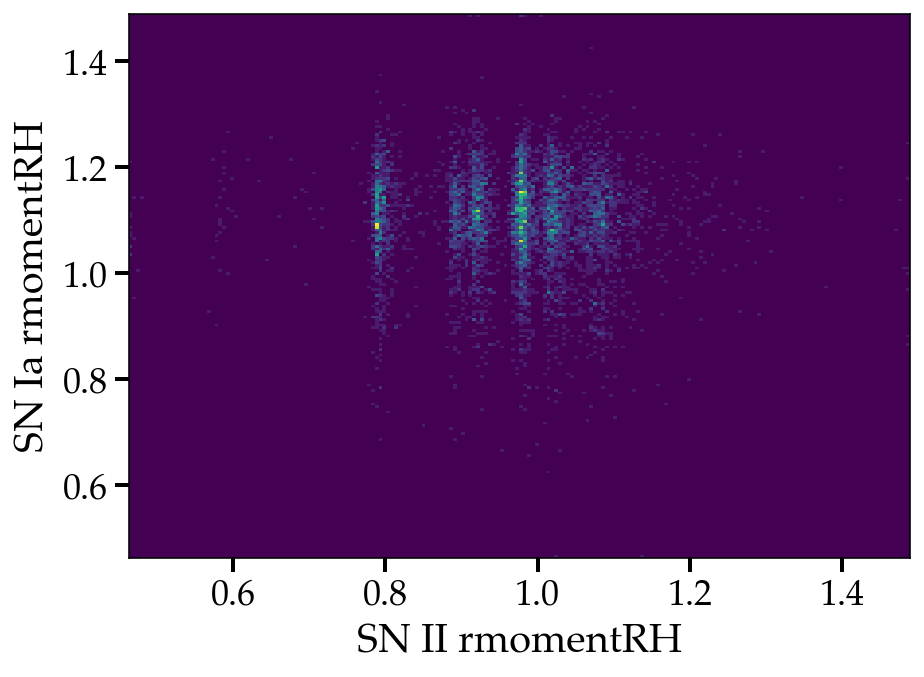

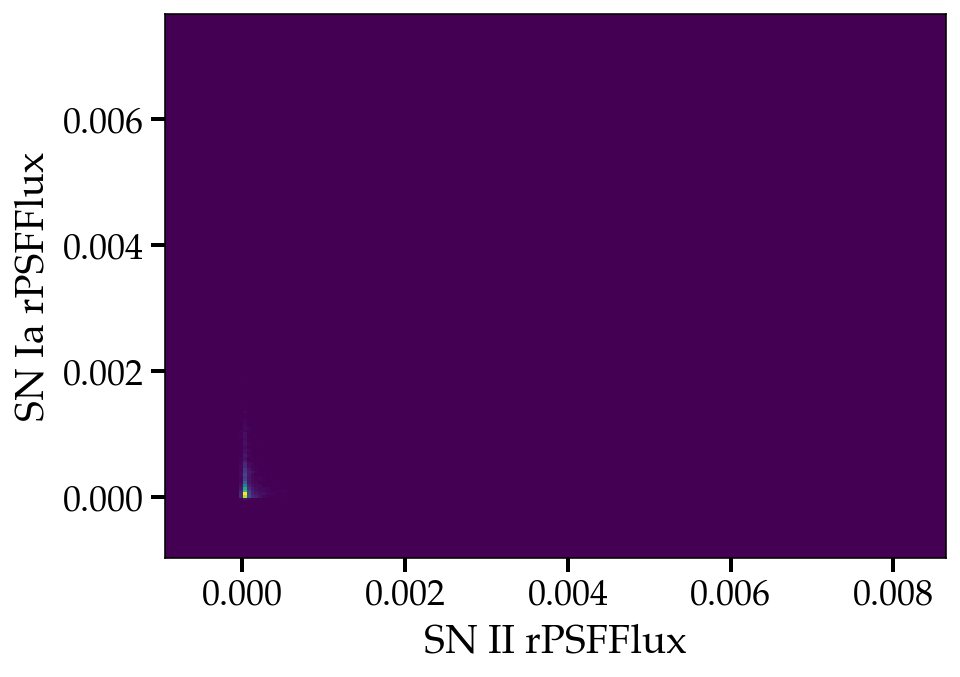

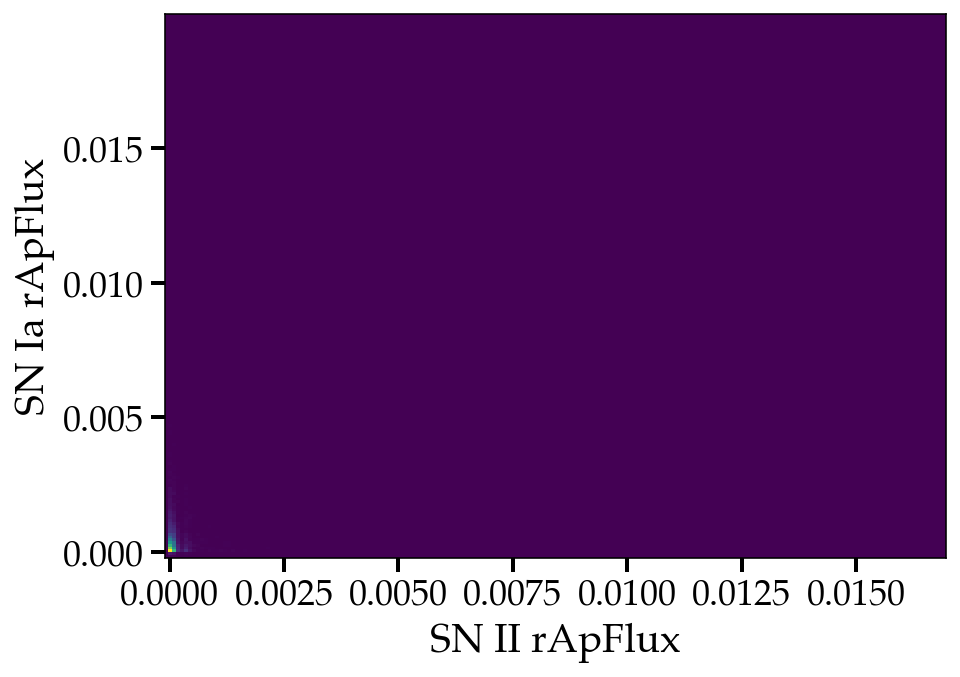

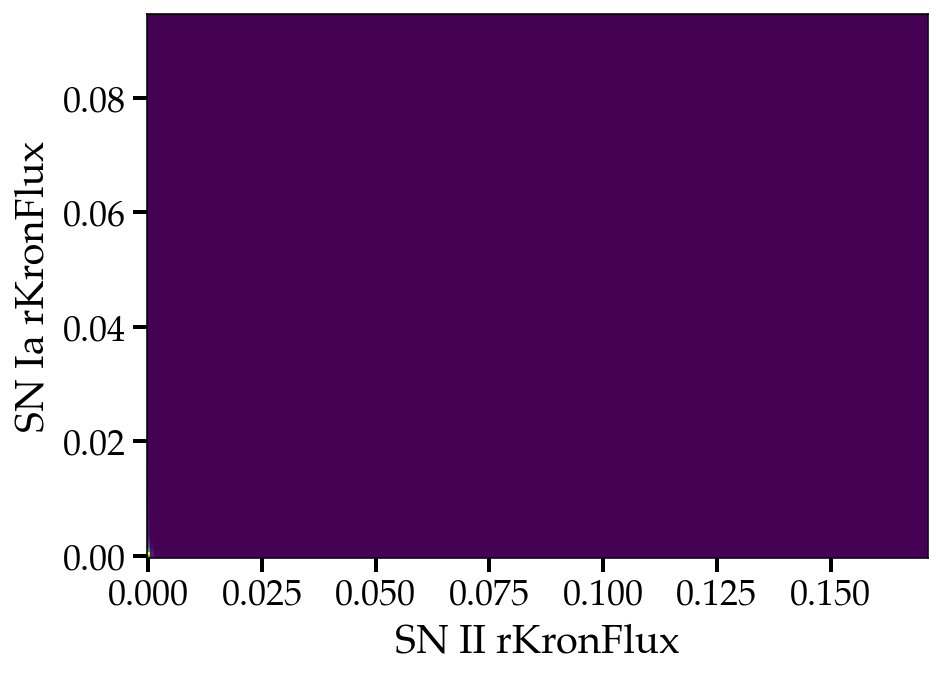

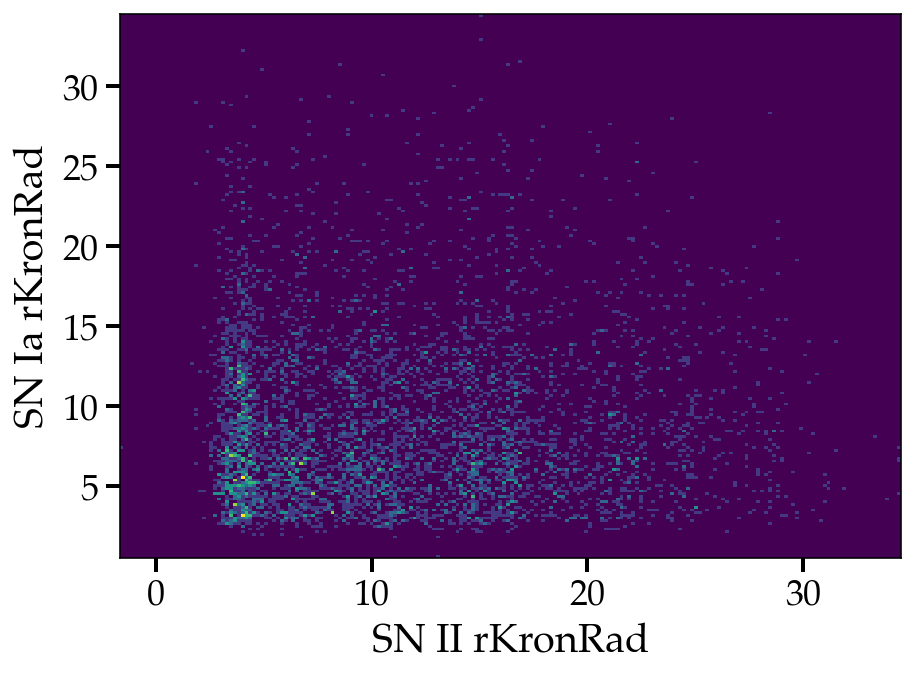

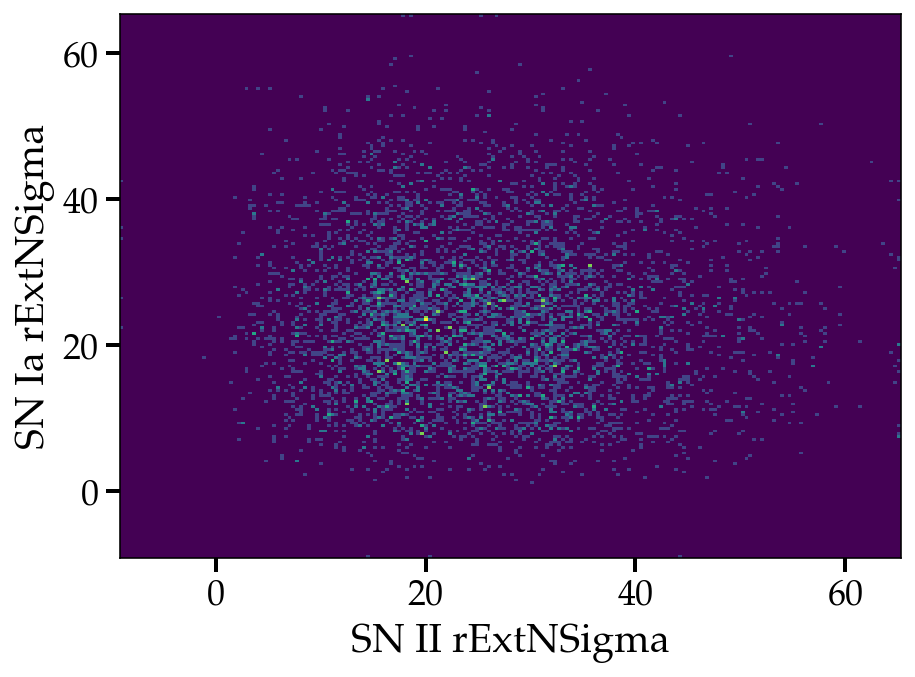

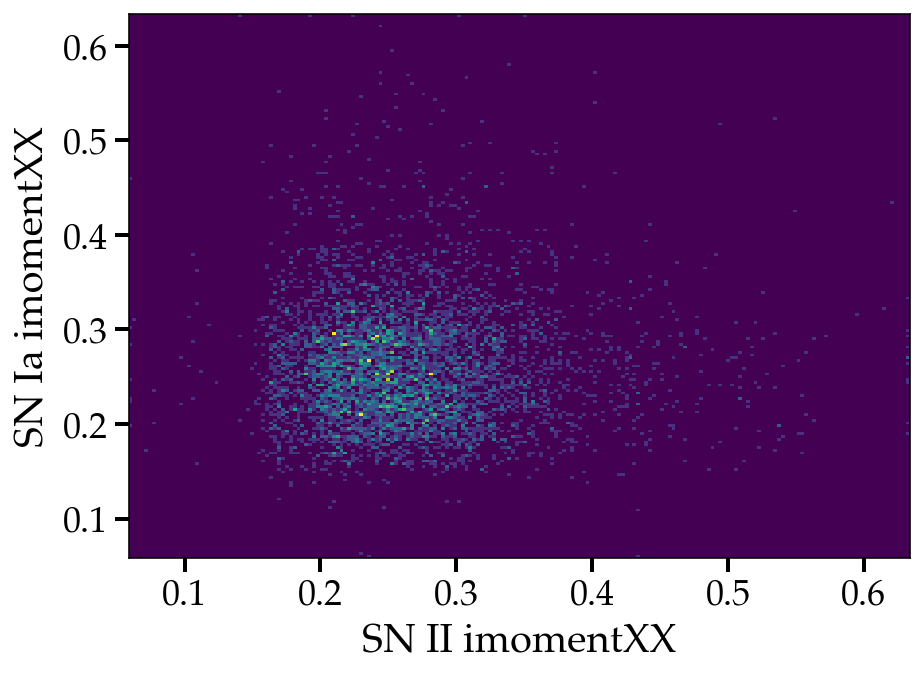

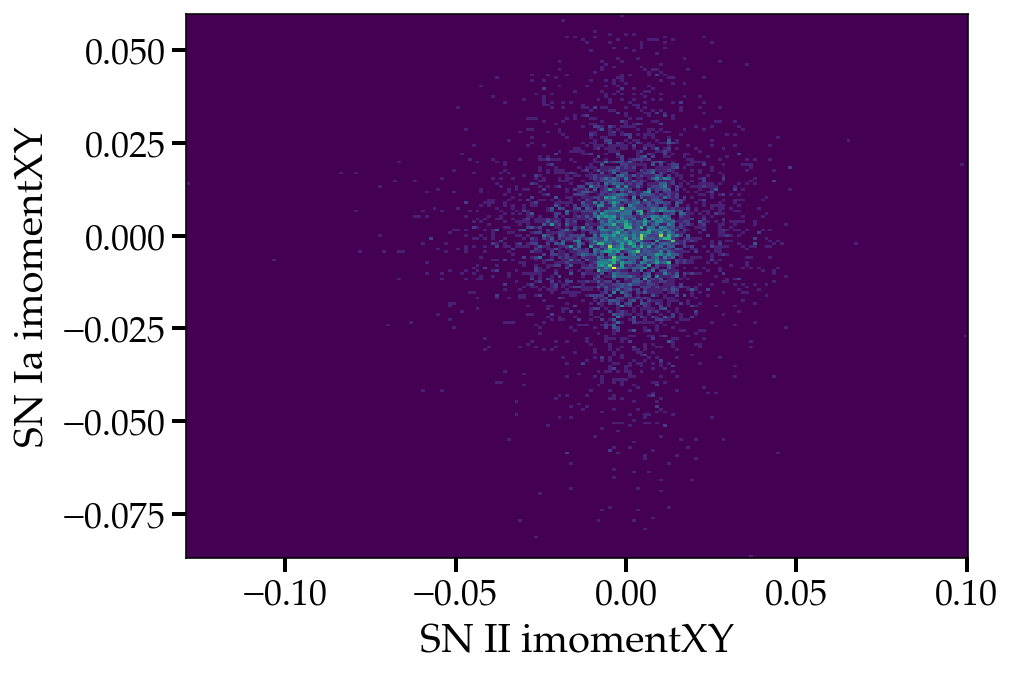

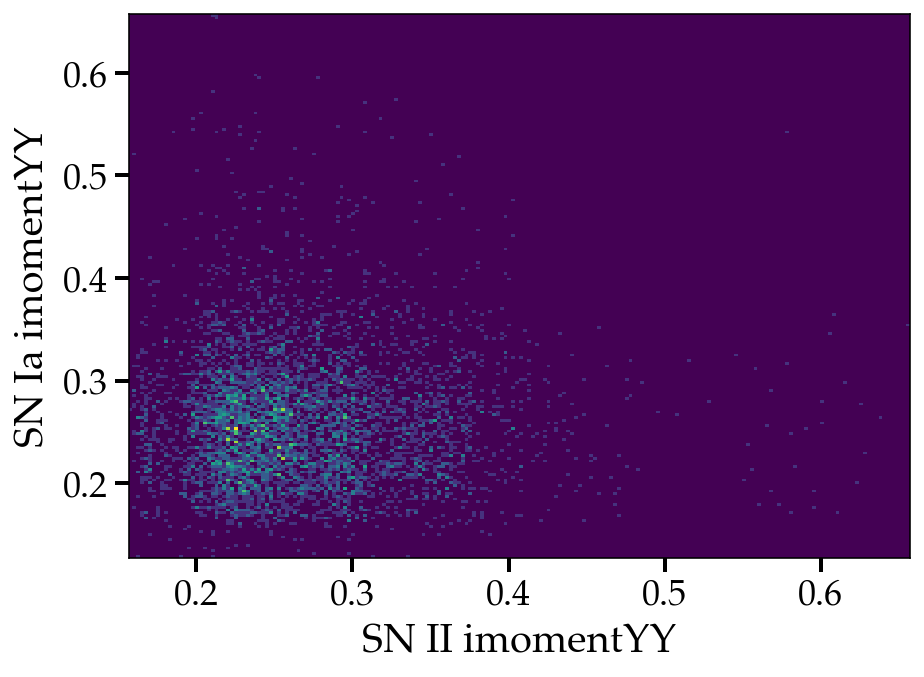

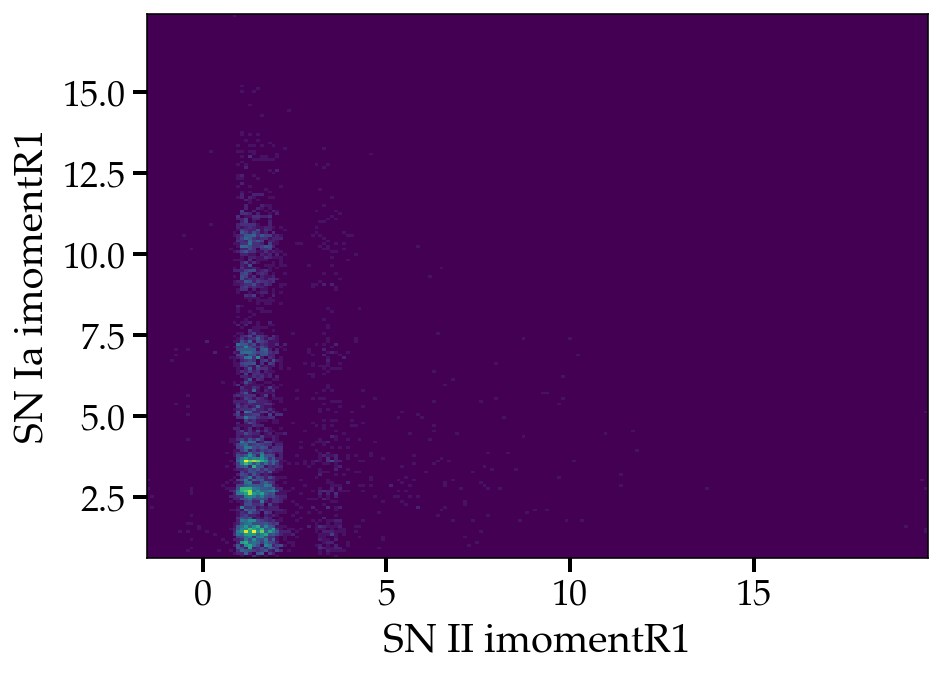

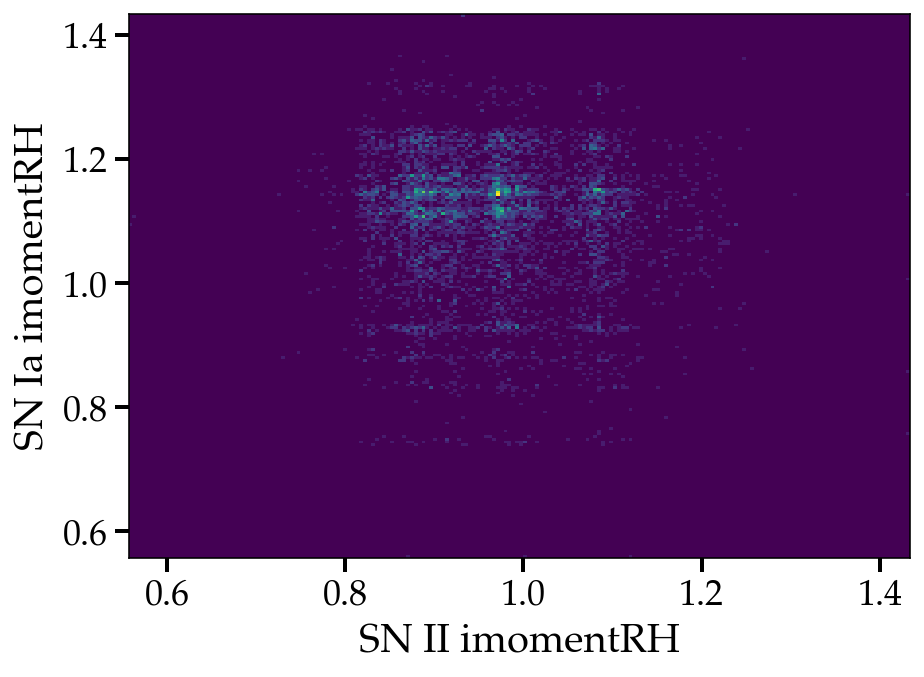

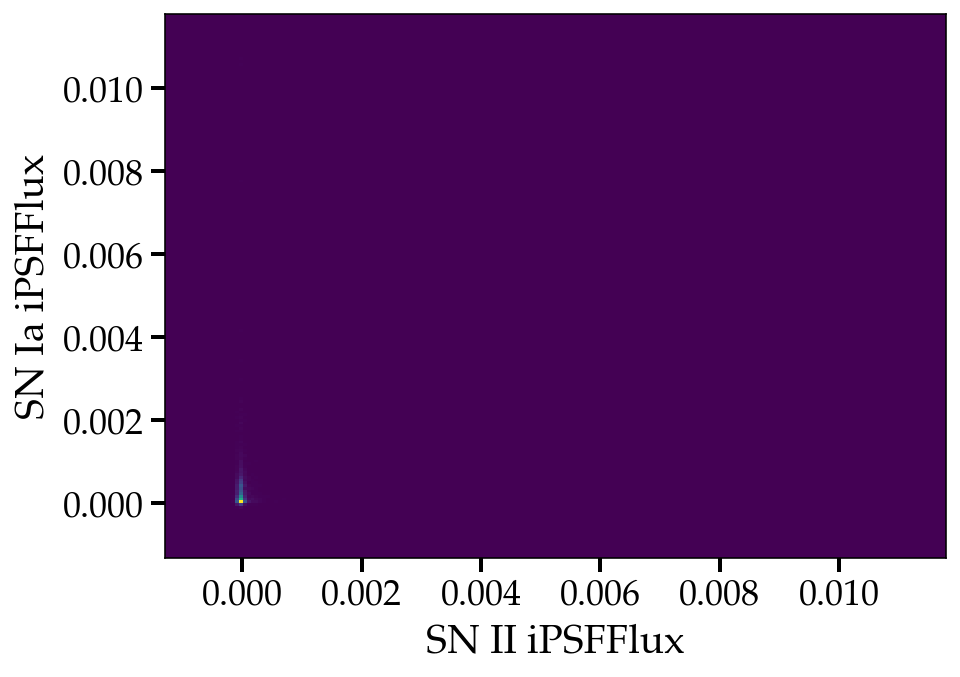

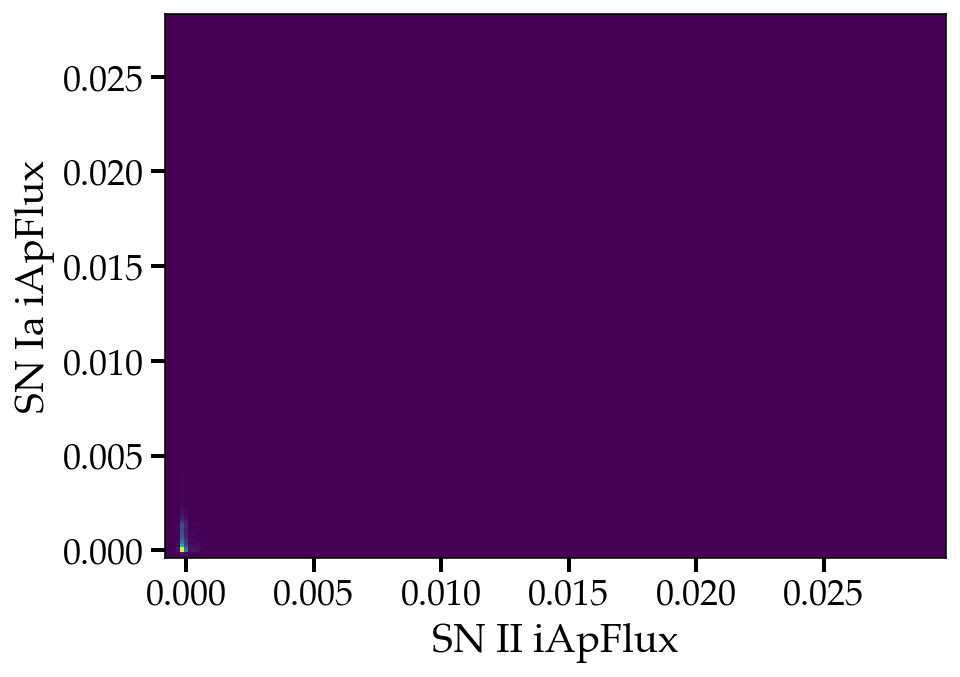

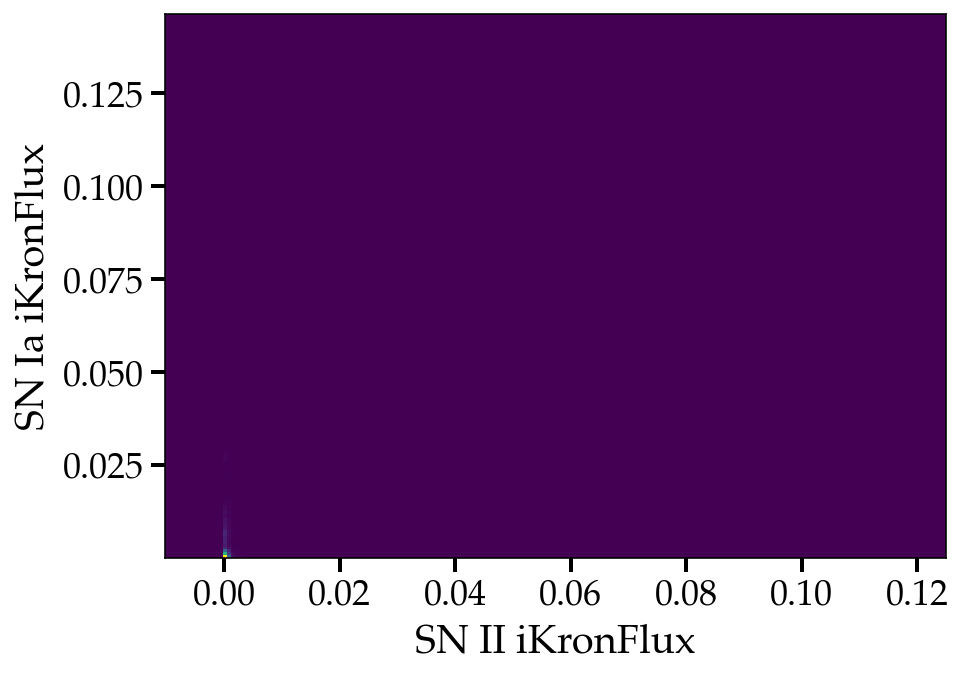

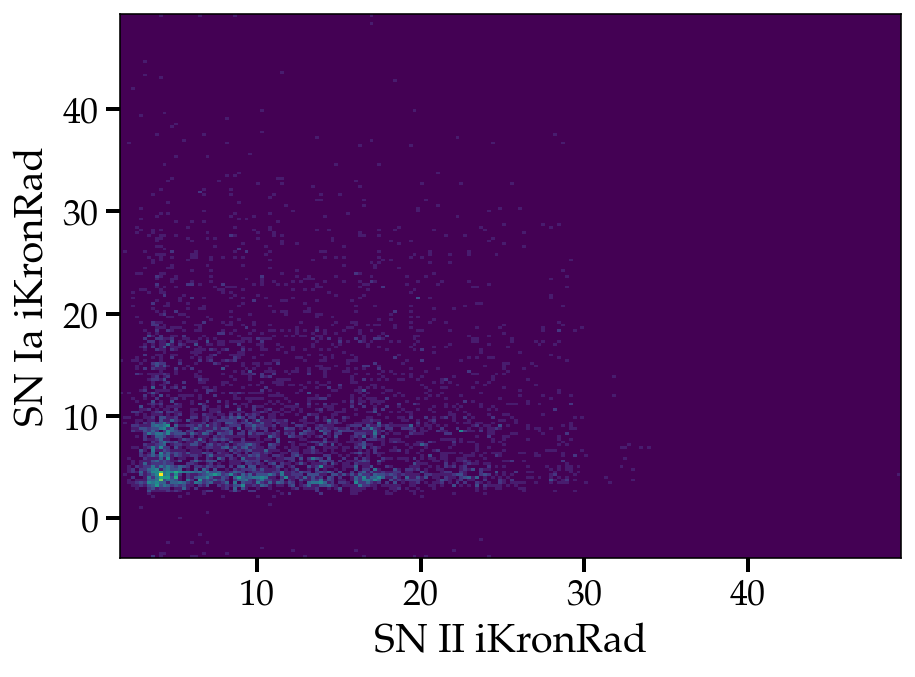

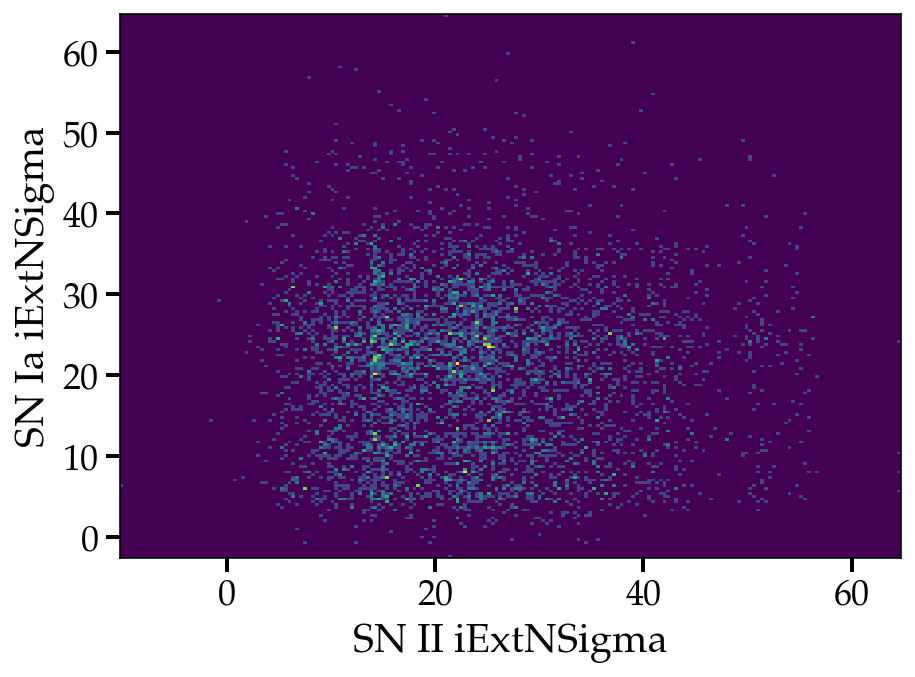

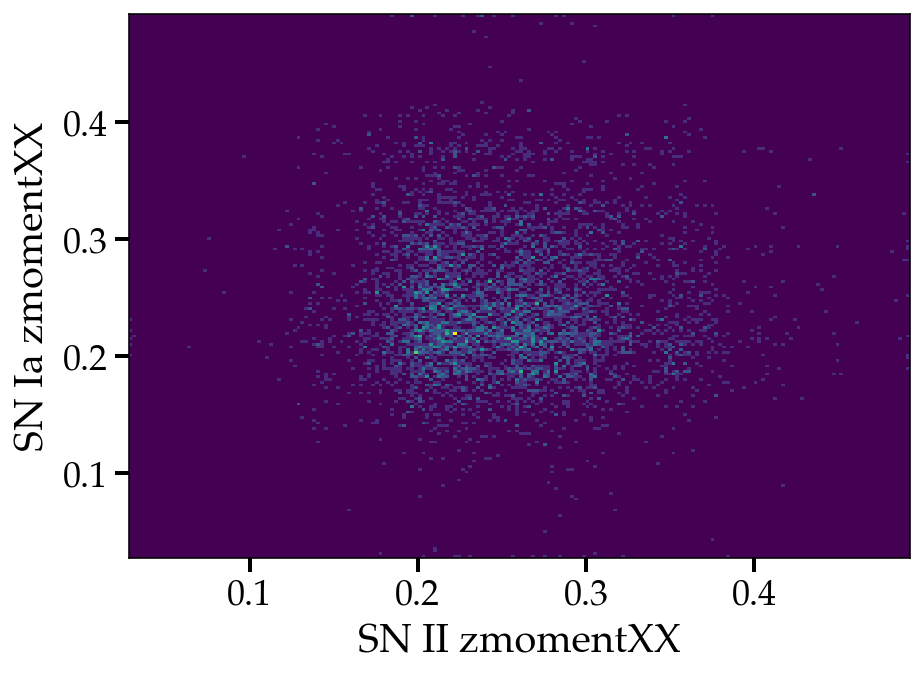

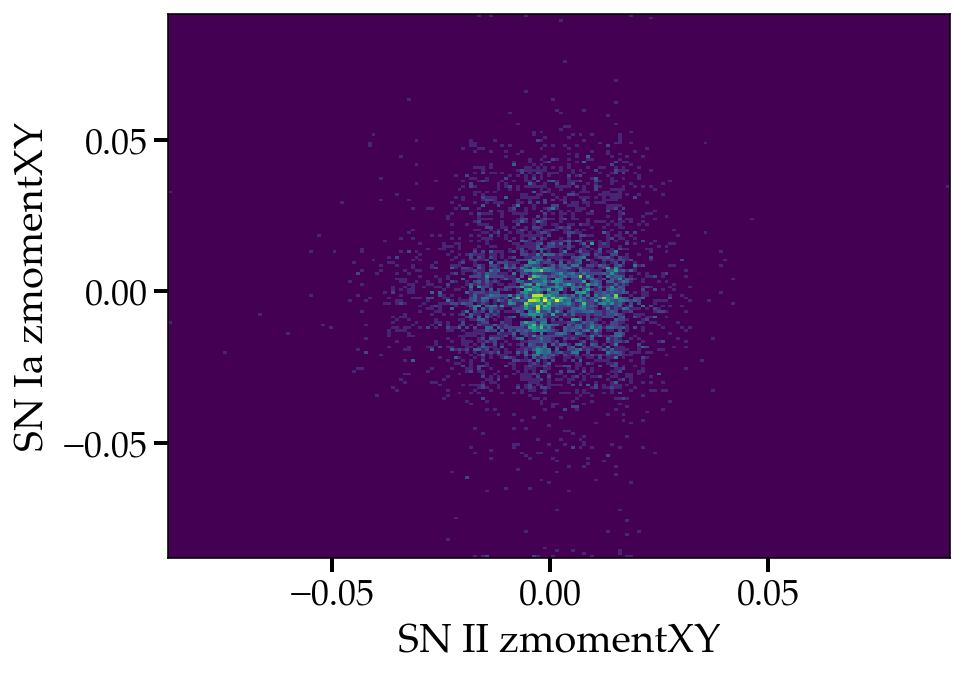

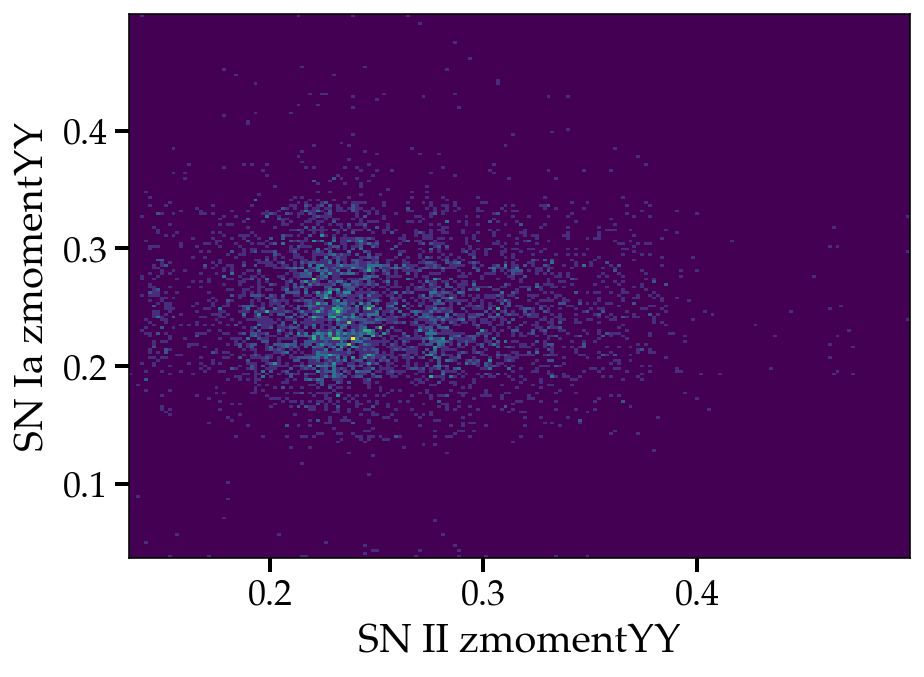

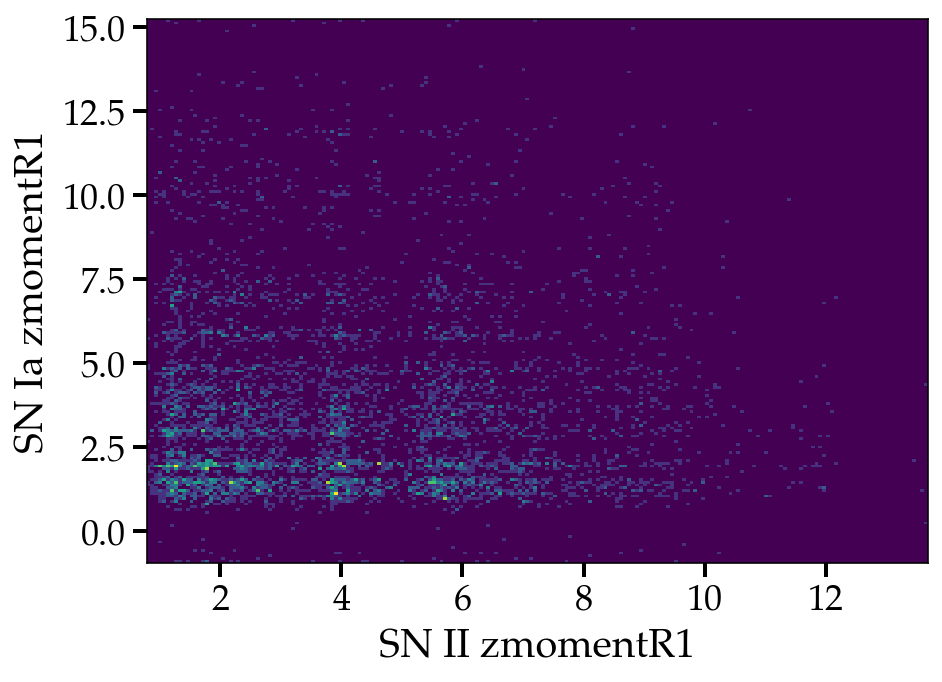

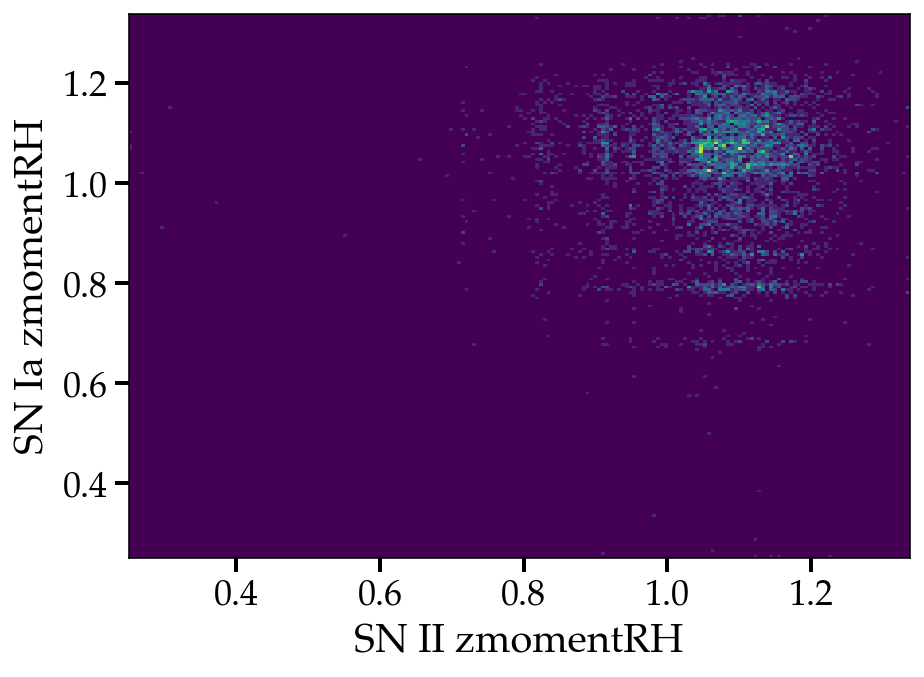

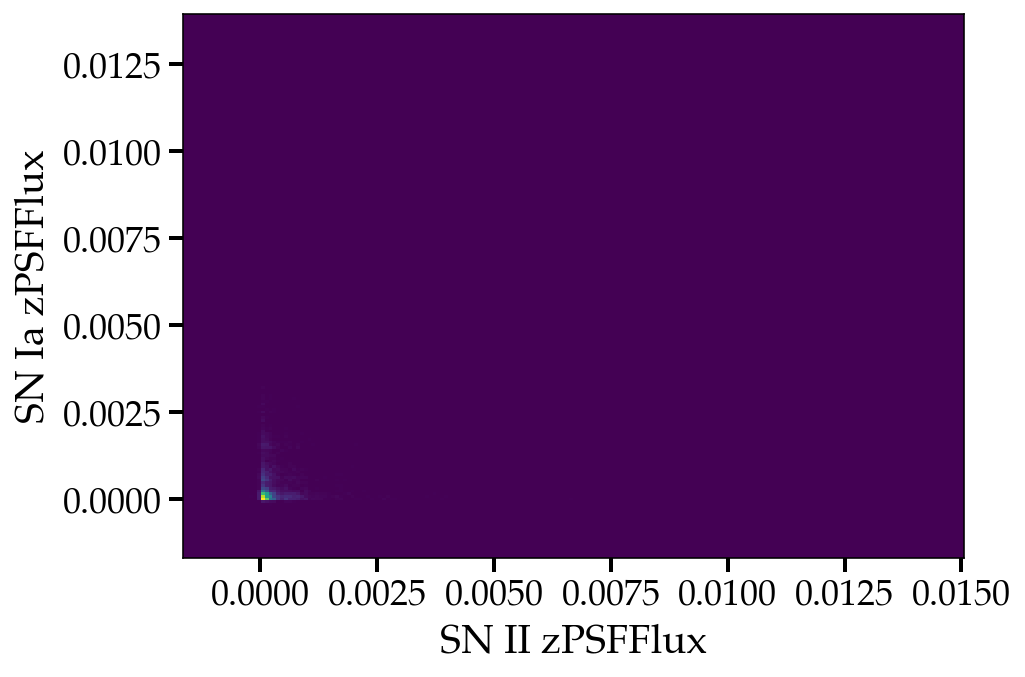

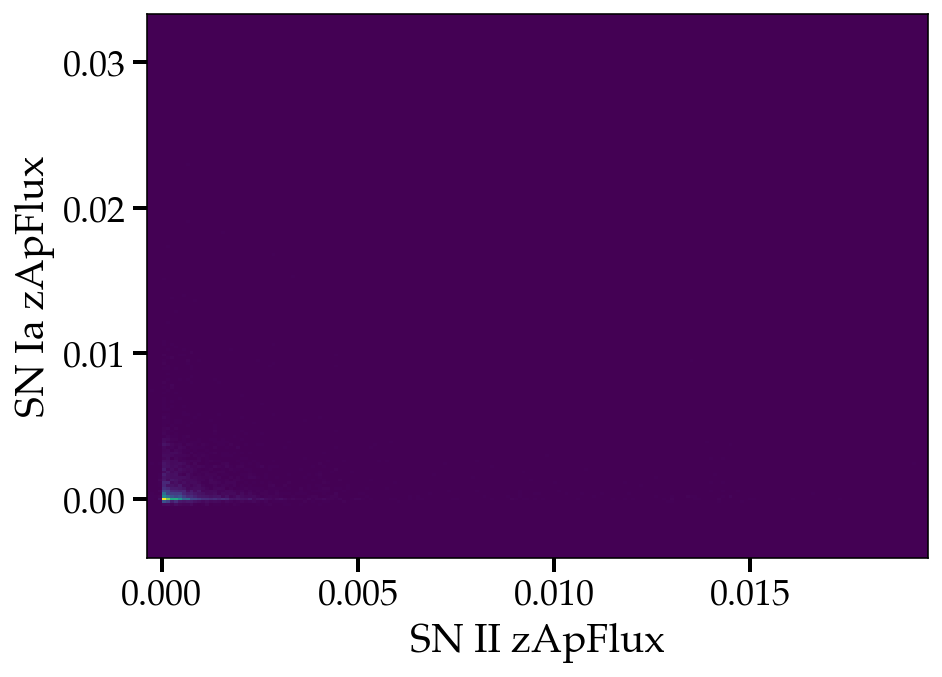

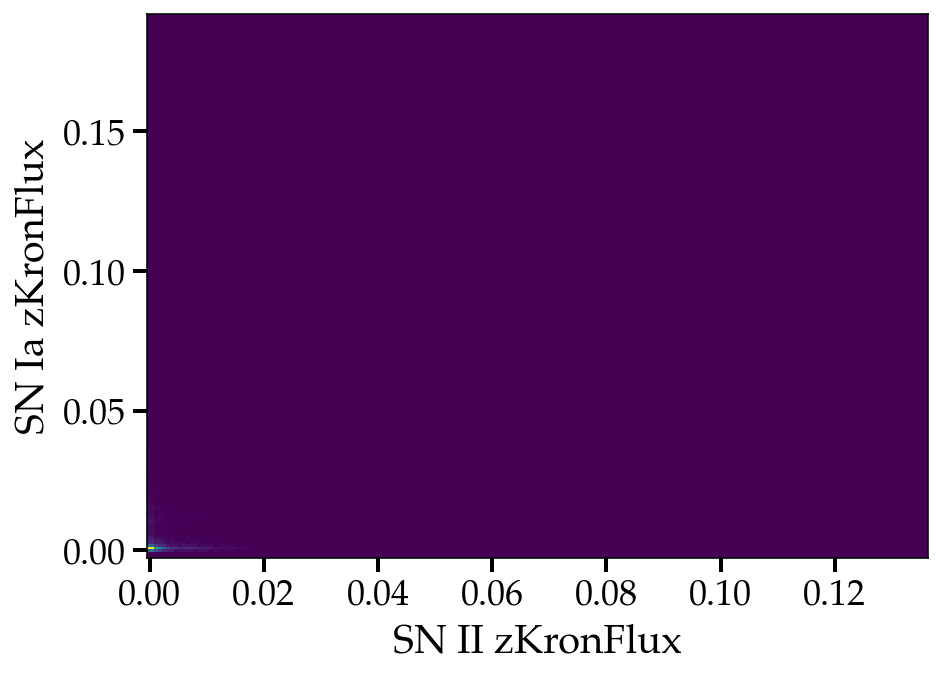

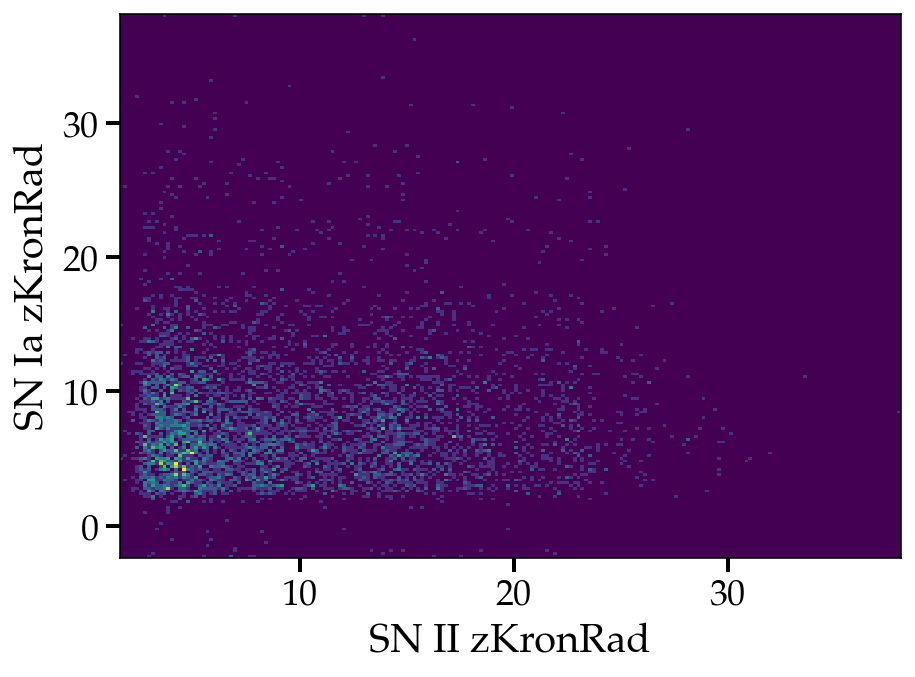

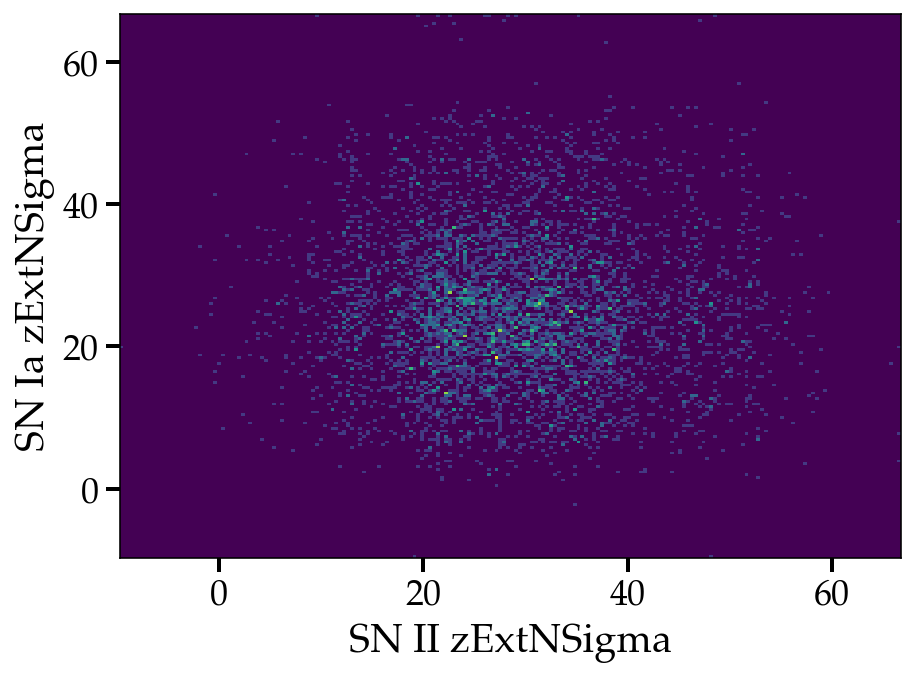

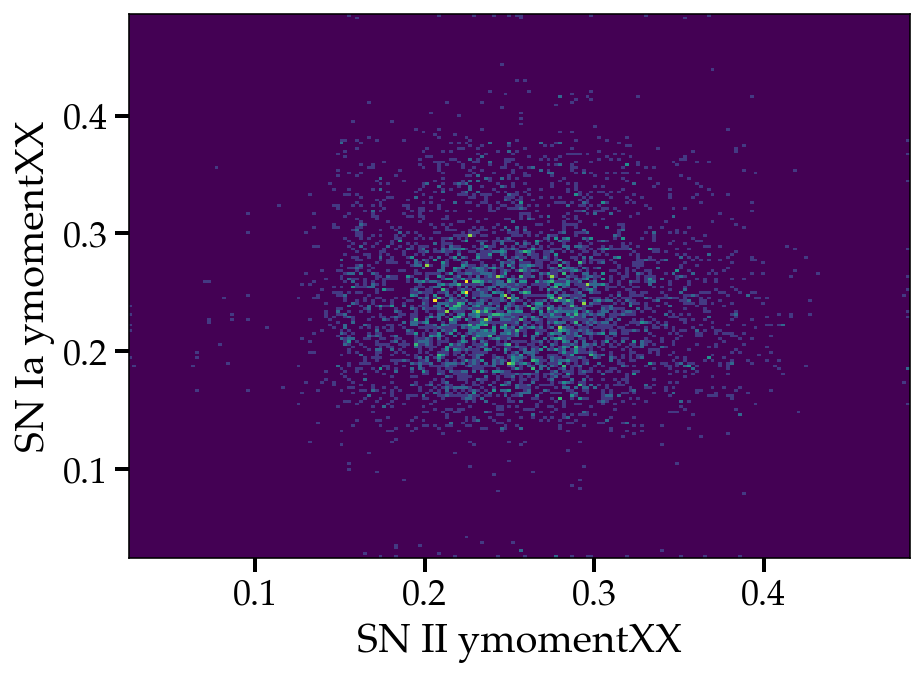

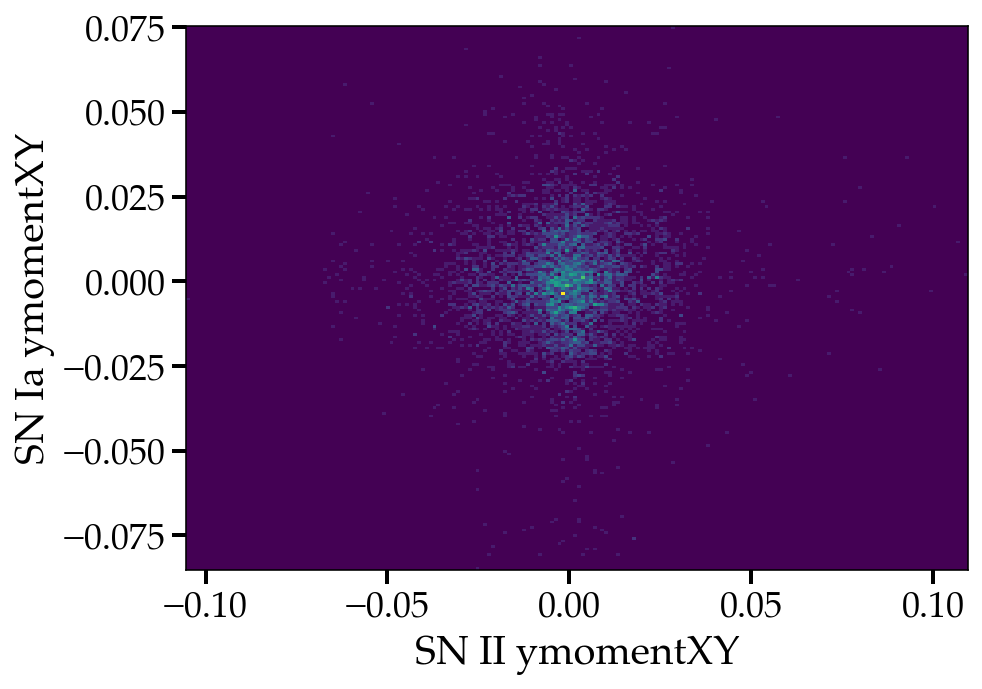

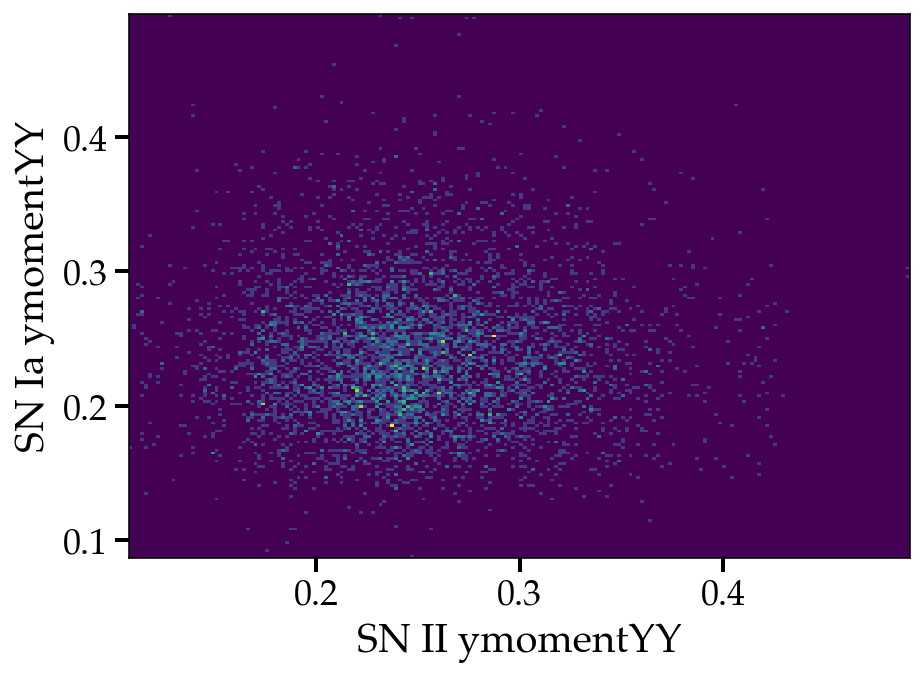

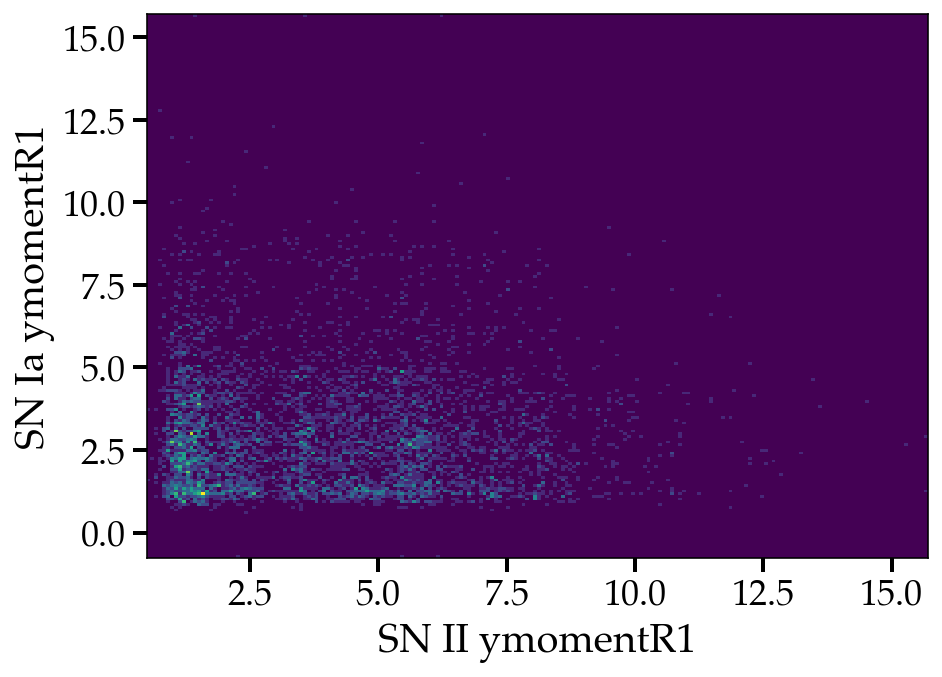

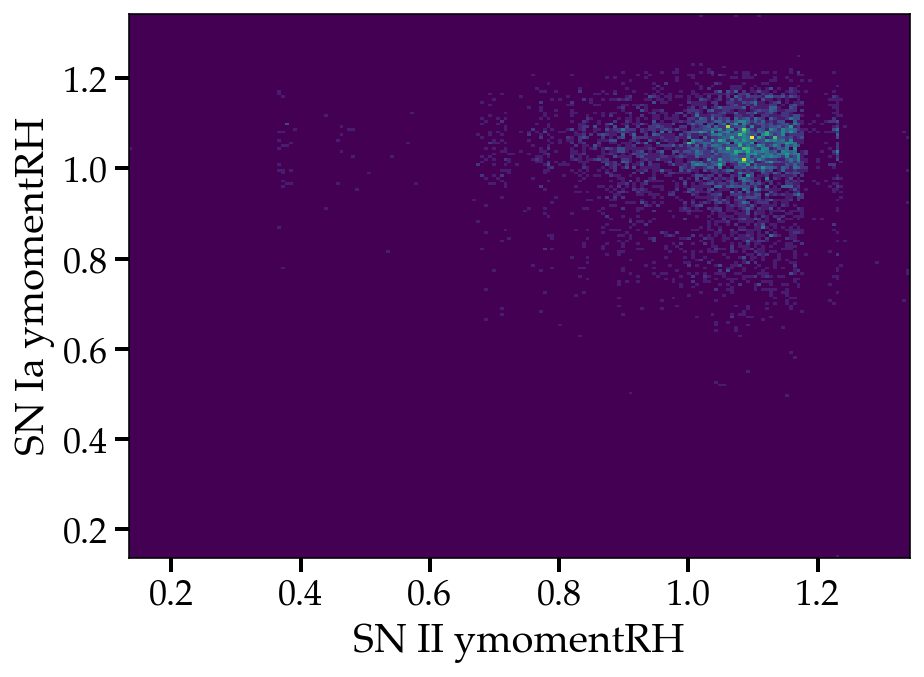

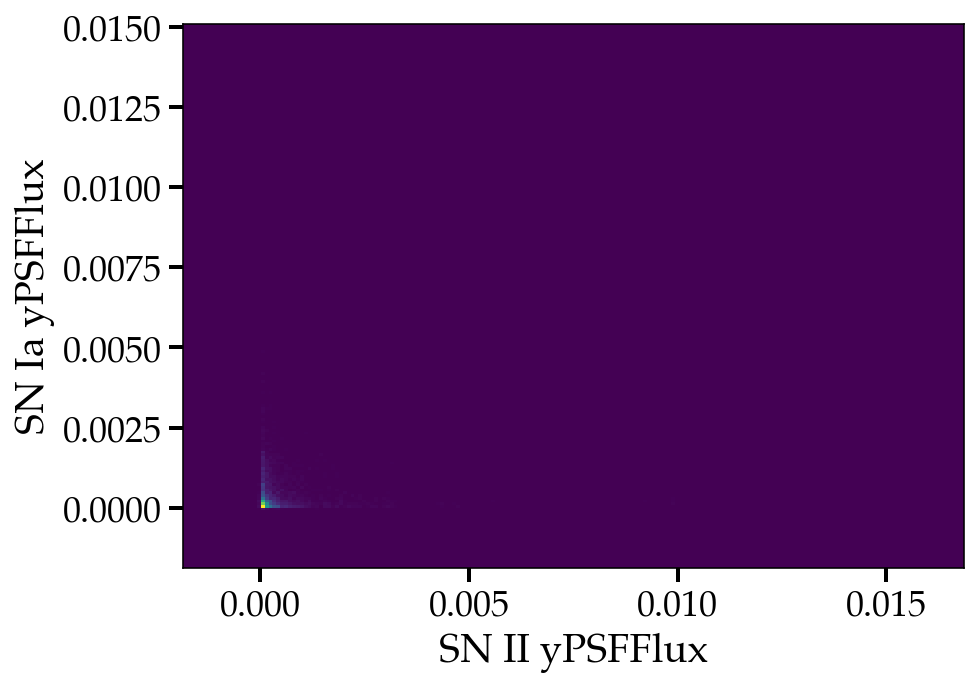

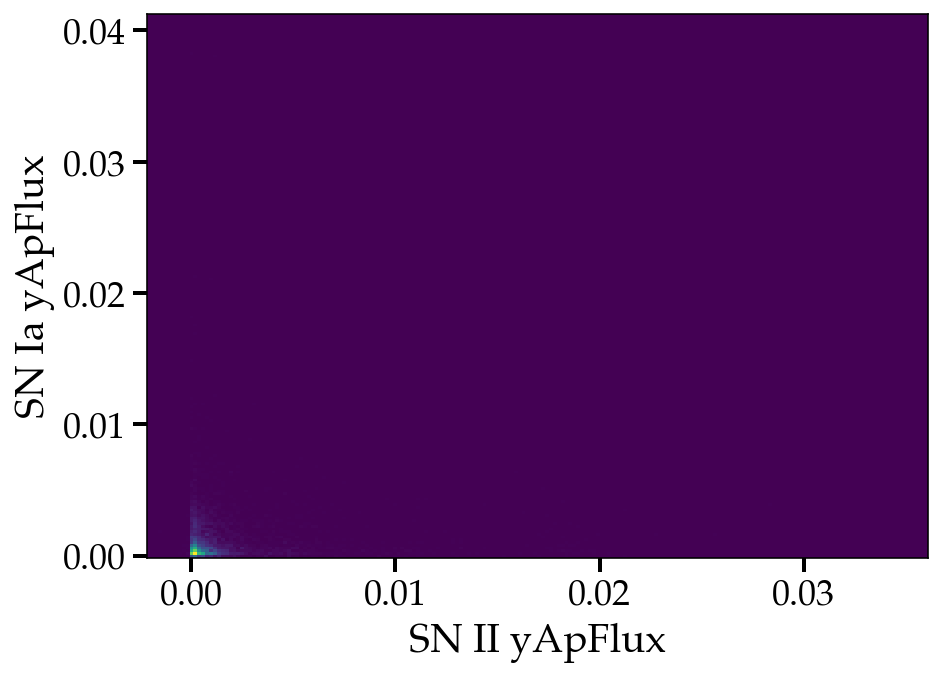

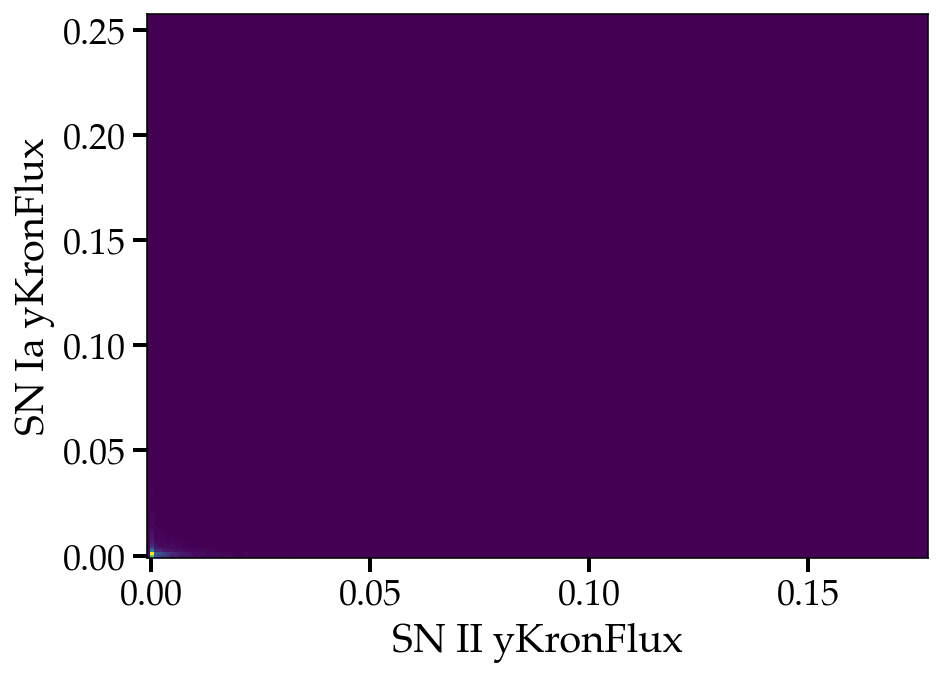

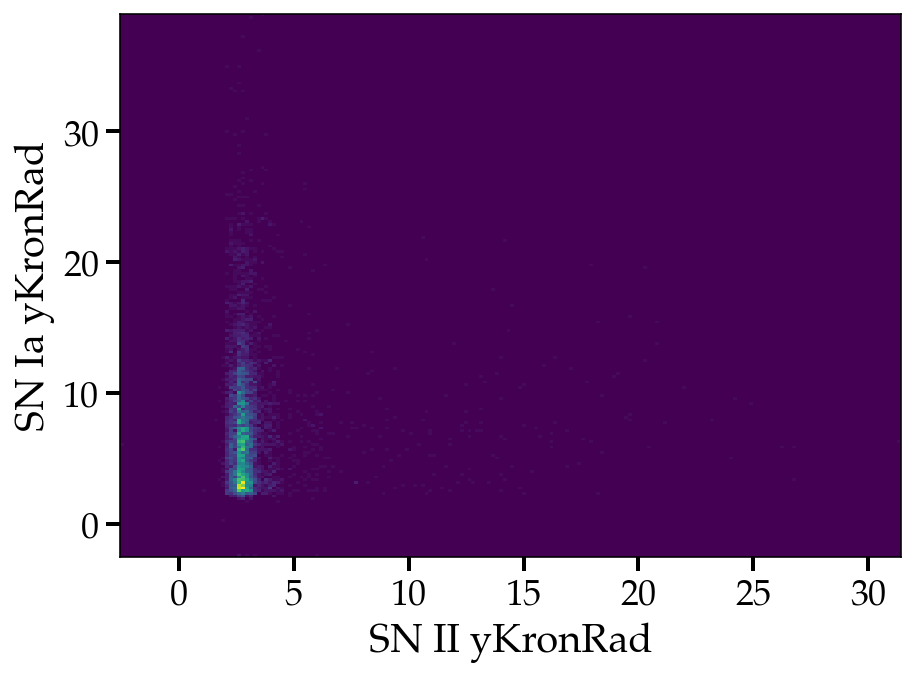

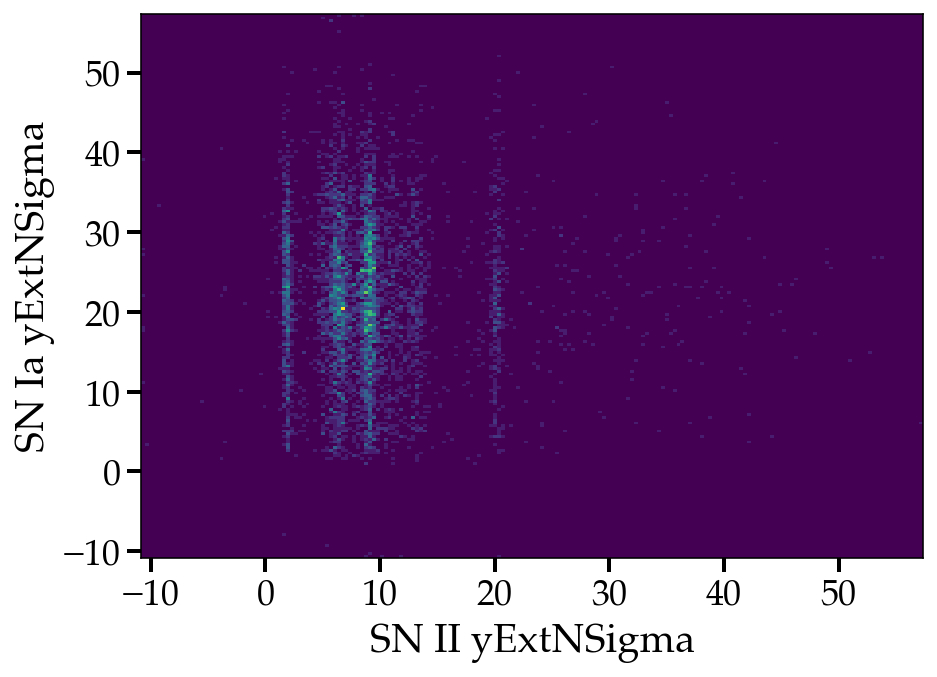

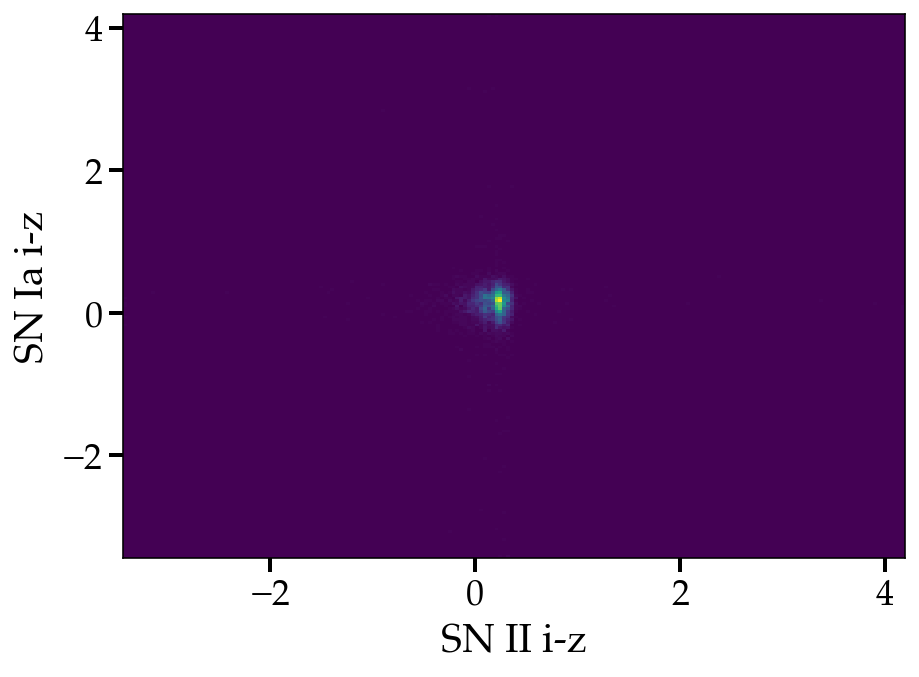

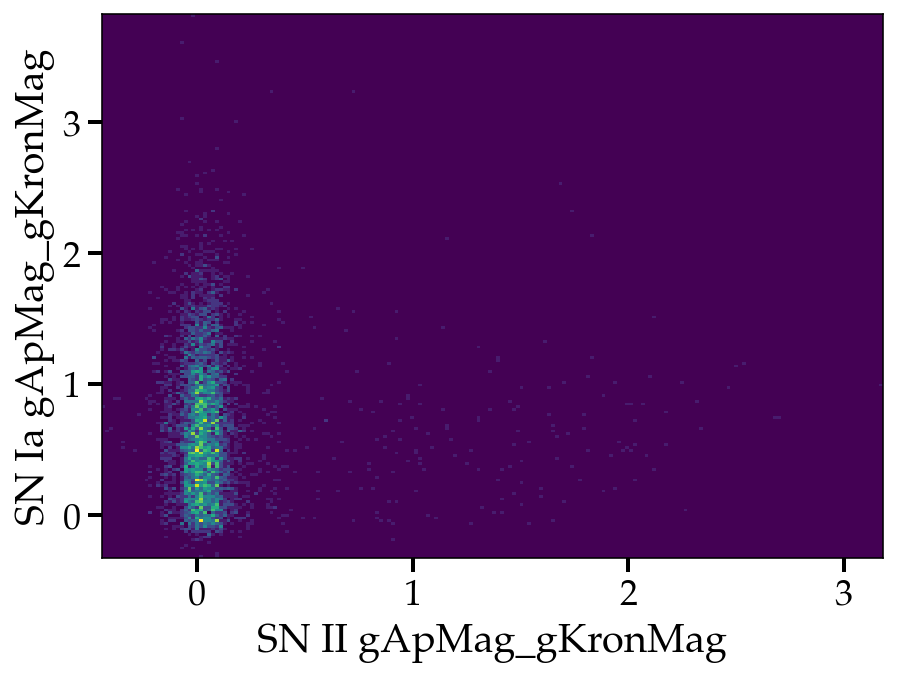

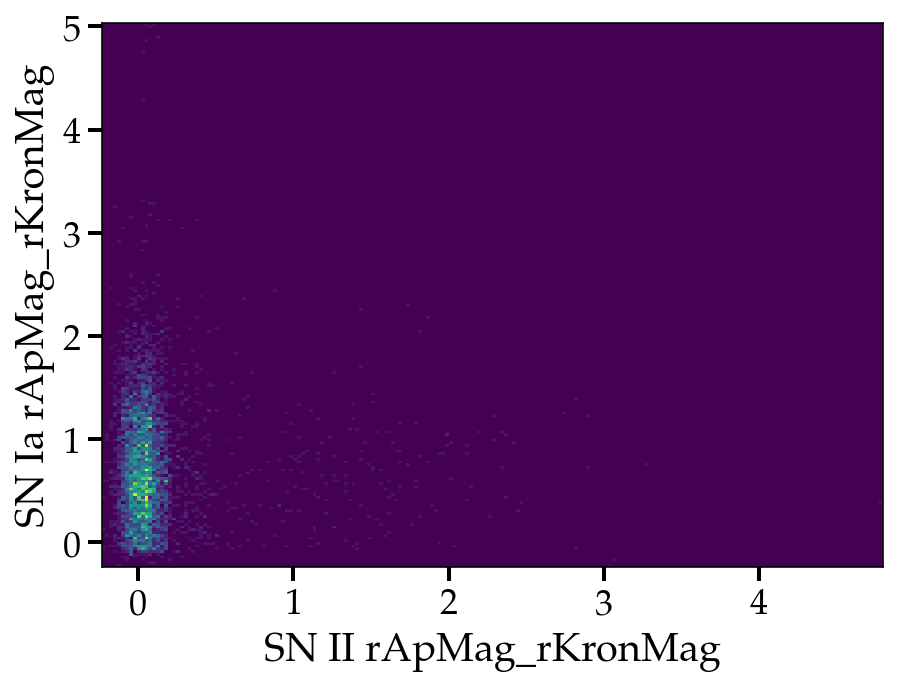

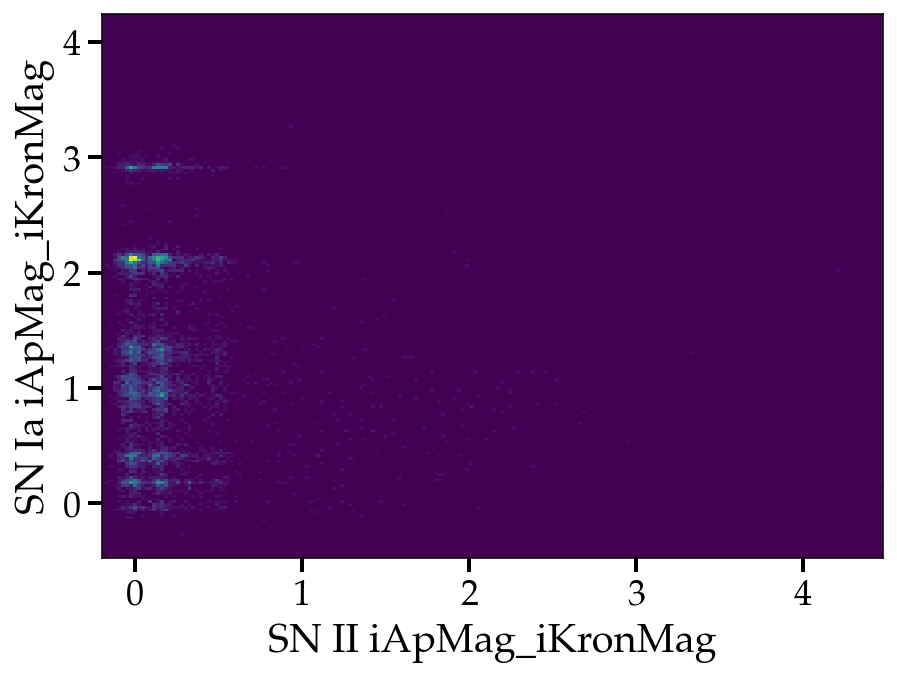

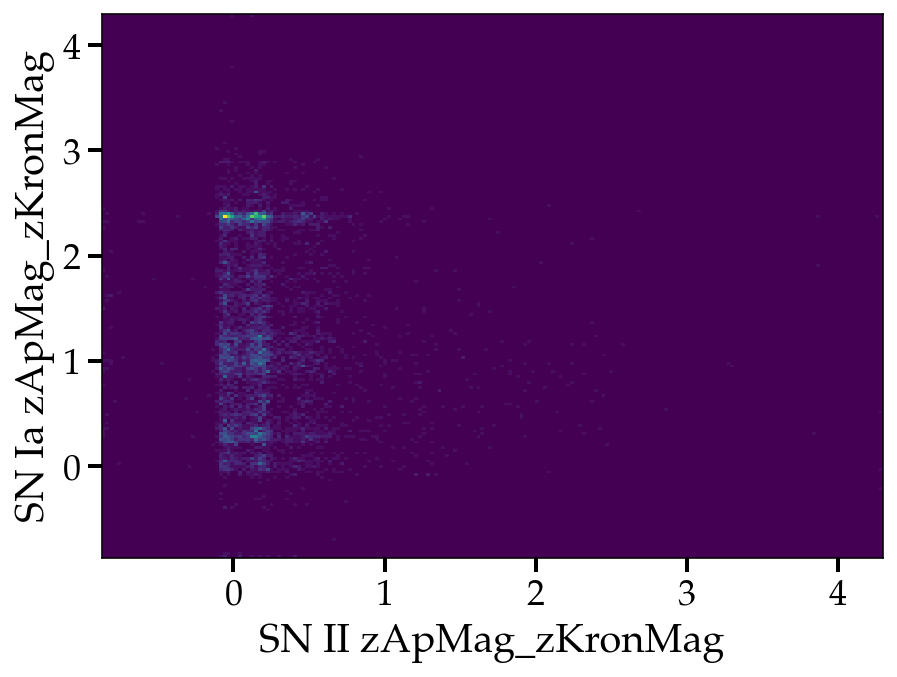

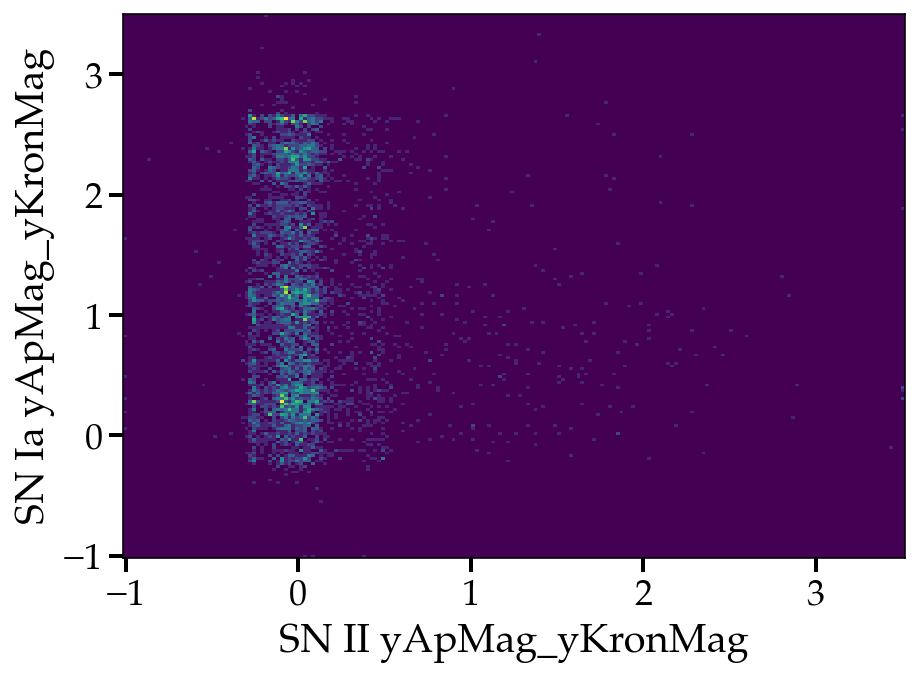

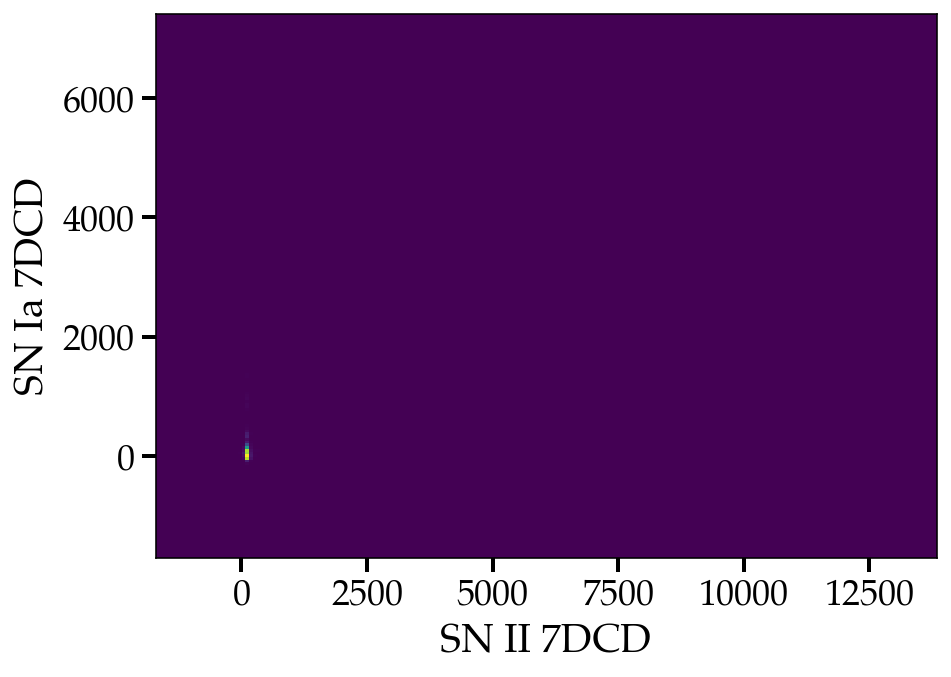

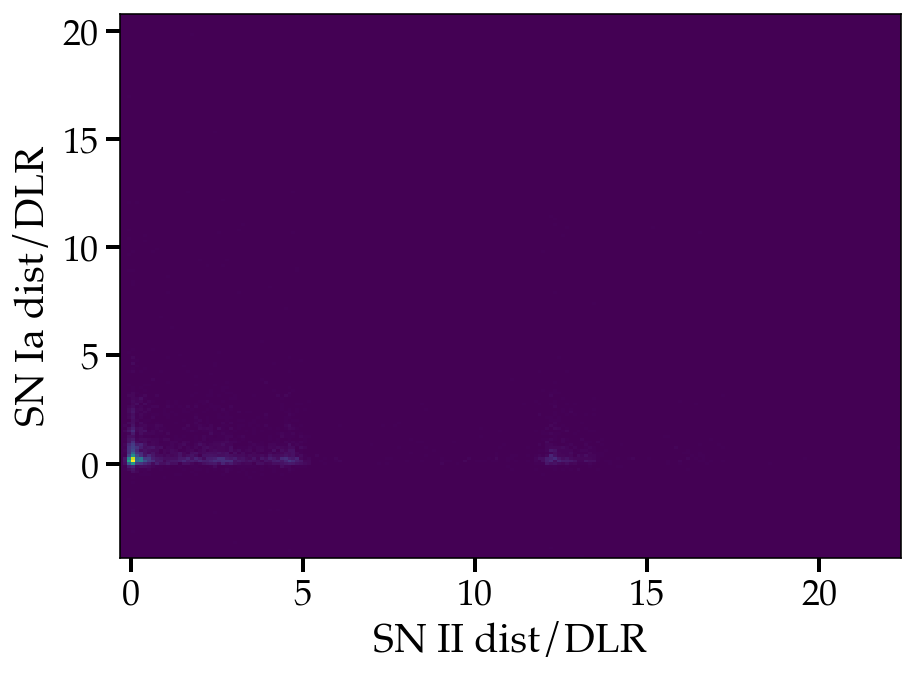

In [36]:
snii_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN II"]
snia_df = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train.tns_cls == "SN Ia"]

for i in range(0, 120, 1):
    feat = lc_and_host_features[0:120][i]
    plt.hist2d(snii_df[feat], snia_df[feat], bins=200)
    plt.xlabel(f"SN II {feat}")
    plt.ylabel(f"SN Ia {feat}")
    plt.show()